# Earthquake Damage Grade Analysis

Collaborators:
- Daffa Bilnadzary
- Samatha Marhaendra Putra

This notebook serves as the workplace for the Joints 2023 Data Competition Preliminary hosted in Kaggle: https://www.kaggle.com/competitions/penyisihan-joints-data-competition-2023.

The main goal is to create and analyze a model that can predict the damage grade of an earthquake happening in Indonesia, based on the assessed building structure in the aftermath of the earthquake.

In [175]:
## Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing packages and loading datasets

In [176]:
## Installing the skopt library
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [177]:
## Import Required Libraries
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, FunctionTransformer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.feature_selection import f_regression, VarianceThreshold
from xgboost import XGBClassifier, plot_importance, plot_tree

## Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

In [178]:
## Load required datasets from Google Drive
df_csv = pd.read_csv('/content/drive/MyDrive/Joints/train.csv', index_col = 0)
test_csv = pd.read_csv('/content/drive/MyDrive/Joints/test.csv', index_col = 0)
sample_submission = pd.read_csv('/content/drive/MyDrive/Joints/sample_submission.csv', index_col = 0)

<ipython-input-178-a7a9cd700b45>:2: DtypeWarning: Columns (1,3,5,6,7,8,9,10,11,12,13,16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_csv = pd.read_csv('/content/drive/MyDrive/Joints/train.csv', index_col = 0)


# Data Overview - 1

Check dataset features and each of the features distributions, to decide next development step

In [267]:
df_csv

floors_before_eq (total)  old_building plinth_area (ft^2)  \
0                     floor two           1.0           256 ft^2   
1                       Floor 3           3.0           985 ft^2   
2                     Two Floor           7.0                NaN   
3                           two          18.0           185 ft^2   
4                  just 2 floor          22.0           290 ft^2   
...                         ...           ...                ...   
520006   There is 2 Floor/Story           8.0           432 ft^2   
520007                  2 floor          26.0           392 ft^2   
520008                      NaN           NaN                NaN   
520009                        2          17.0           300 ft^2   
520010                  Floor 2           5.0           300 ft^2   

        height_before_eq (ft) land_surface_condition  \
0                        22.0                   Flat   
1                        18.0                   Flat   
2                        14.0                   Flat   
3                        15.0                   Flat   
4                        17.0                   Flat   
...                       ...                    ...   
520006                   14.0                   Flat   
520007                   19.0                   Flat   
520008                    NaN                    NaN   
520009                   16.0                   Flat   
520010                   14.0                   Flat   

                        type_of_foundation  \
0                         Bamboo or Timber   
1       Clay Sand Mixed mortar-Stone/Brick   
2                   Mud mortar-Stone/Brick   
3       Clay Sand Mixed mortar-Stone/Brick   
4       Clay Sand Mixed mortar-Stone/Brick   
...                                    ...   
520006                       Bamboo/Timber   
520007  Clay Sand Mixed mortar-Stone/Brick   
520008                                 NaN   
520009             Clay mortar-Stone/Brick   
520010                    Bamboo or Timber   

                                type_of_roof type_of_ground_floor  \
0                   Bamboo/Timber Light roof                 Clay   
1       Wood Light Roof or Bamboo Heavy Roof                 Clay   
2                                        NaN                 Clay   
3       Wood Light Roof or Bamboo Light Roof                 Clay   
4                Bamboo or Timber Light roof                 Clay   
...                                      ...                  ...   
520006  Wood Light Roof or Bamboo Heavy Roof                 Clay   
520007              Bamboo/TImber-Light Roof                 Clay   
520008                                   NaN                  NaN   
520009  Wood Light Roof or Bamboo Light Roof                 Clay   
520010              Bamboo/Timber Light roof                  mud   

             type_of_other_floor      position  ...  \
0              TImber/Bamboo-Mud  Not attached  ...   
1              TImber/Bamboo-Mud  Not attached  ...   
2         Wood-Mud or Bamboo Mud  Not attached  ...   
3              TImber/Bamboo-Mud  Not attached  ...   
4       Timber Mud or Bamboo-Mud  Not attached  ...   
...                          ...           ...  ...   
520006                Wood-Plank  Not attached  ...   
520007         TImber/Bamboo-Mud  Not attached  ...   
520008                       NaN           NaN  ...   
520009    Wood-Mud or Bamboo Mud  Not attached  ...   
520010         TImber/Bamboo-Mud  Not attached  ...   

       type_of_reinforcement_concrete residential_type no_family_residing  \
0                                 0.0  Non-residential                1.0   
1                                 0.0  Non-residential                1.0   
2                                 0.0  Non-residential                1.0   
3                                 0.0  Non-residential                1.0   
4                                 0.0  Non-residential                1.0   
...         

In [268]:
test_csv

floors_before_eq (total)  old_building plinth_area (ft^2)  \
id                                                                 
0                             2             7           418 ft^2   
1                          3.00            13           396 ft^2   
2                   Floor-three            40           400 ft^2   
3                  floor second            25           378 ft^2   
4                  just 2 floor             5           375 ft^2   
...                         ...           ...                ...   
242077                Two Floor            15           240 ft^2   
242078              floor third             4           174 ft^2   
242079                Two Floor            14           375 ft^2   
242080                        2             9           486 ft^2   
242081             floor second            70           600 ft^2   

        height_before_eq (ft) land_surface_condition  \
id                                                     
0                          14                   Flat   
1                          21                   Flat   
2                          18                   Flat   
3                          20                   Flat   
4                          20                   Flat   
...                       ...                    ...   
242077                     15         Moderate slope   
242078                     18                   Flat   
242079                     14                   Flat   
242080                     16         Moderate slope   
242081                     16         Moderate slope   

                        type_of_foundation  \
id                                           
0                  Clay mortar-Stone/Brick   
1                  Clay mortar-Stone/Brick   
2                  Clay mortar-Stone/Brick   
3                         Bamboo or Timber   
4                   Mud mortar-Stone/Brick   
...                                    ...   
242077             Clay mortar-Stone/Brick   
242078              Mud mortar-Stone/Brick   
242079             Clay mortar-Stone/Brick   
242080             Clay mortar-Stone/Brick   
242081  Clay Sand Mixed mortar-Stone/Brick   

                                type_of_roof type_of_ground_floor  \
id                                                                  
0                   Bamboo/TImber-Light Roof                 Clay   
1                   Bamboo/TImber-Heavy Roof       Brick or Stone   
2                   Bamboo/Timber Light roof                 Clay   
3                   Bamboo/Timber Heavy roof                  mud   
4       Wood Light Roof or Bamboo Light Roof                 Clay   
...                                      ...                  ...   
242077           Bamboo or Timber Light roof                 Clay   
242078              Bamboo/Timber Light roof                 Clay   
242079  Wood Light Roof or Bamboo Light Roof                 Clay   
242080              Bamboo/TImber-Light Roof                 Clay   
242081              Bamboo/TImber-Light Roof                 Clay   

           type_of_other_floor         position  ... has_secondary_use  \
id                                               ...                     
0            TImber/Bamboo-Mud     Not attached  ...               0.0   
1            TImber/Bamboo-Mud     Not attached  ...               0.0   
2           Wood or Bamboo Mud     Not attached  ...               0.0   
3            TImber/Bamboo-Mud  Attached-2 side  ...               0.0   
4       Wood-Mud or Bamboo Mud  Attached-1 side  ...               0.0   
...                        ...              ...  ...               ...   
242077       TImber/Bamboo-Mud     Not attached  ...               0.0   
242078       TImber/Bamboo-Mud     Not attached  ...               0.0   
242079       TImber/Bamboo-Mud     Not attached  ...               0.0   
242080       TImber/Bamboo-Mud  Attached-3 side  ...               0.0   
242081  

Checking duplicated rows in the training set

In [269]:
df_csv.index.has_duplicates

False

In [270]:
temp = df_csv.reset_index()
temp = temp.rename(columns = {"index": "ID"})

In [271]:
temp[temp['ID'].duplicated()]

Empty DataFrame
Columns: [ID, floors_before_eq (total), old_building, plinth_area (ft^2), height_before_eq (ft), land_surface_condition, type_of_foundation, type_of_roof, type_of_ground_floor, type_of_other_floor, position, building_plan_configuration, technical_solution_proposed, legal_ownership_status, has_secondary_use, type_of_reinforcement_concrete, residential_type, no_family_residing, public_place_type, industrial_use_type, govermental_use_type, flexible_superstructure, wall_binding, wall_material, damage_grade]
Index: []

[0 rows x 25 columns]

Apparently, rows from index number 520011 to 722814 are duplicated. We can safely remove this by slicing only the first 520010 rows.

In [272]:
## Checking the unique values of ID
df_csv.index.nunique()

520011

In [273]:
## Selecting up to the latest unique column only
df_csv = df_csv[:520011]

Checking dataset features and their types

In [274]:
df_csv.dtypes

floors_before_eq (total)           object
old_building                      float64
plinth_area (ft^2)                 object
height_before_eq (ft)             float64
land_surface_condition             object
type_of_foundation                 object
type_of_roof                       object
type_of_ground_floor               object
type_of_other_floor                object
position                           object
building_plan_configuration        object
technical_solution_proposed        object
legal_ownership_status             object
has_secondary_use                 float64
type_of_reinforcement_concrete    float64
residential_type                   object
no_family_residing                 object
public_place_type                  object
industrial_use_type                object
govermental_use_type               object
flexible_superstructure            object
wall_binding                      float64
wall_material                     float64
damage_grade                      

Lots of incorrect data type, from **plinth_area** (which should be numerical), to **damage_grade** (which should be an object since its the target label)

# Data Cleaning - 1

Based on the overview of the data, there are some columns that has little to no relationship at all to the target, so we can safely remove this first.

In [275]:
## _1 in the variable naming indicates the first step of the development.
columns_to_drop_1 = [
    'govermental_use_type', 'public_place_type', 
    'no_family_residing', 'residential_type', 'has_secondary_use', 
    'legal_ownership_status'
]

In [276]:
df_csv_1_cleaning = df_csv.copy()
df_csv_1_cleaning = df_csv_1_cleaning.drop(columns = columns_to_drop_1)

In [277]:
## Check current dataset features
df_csv_1_cleaning.head()

floors_before_eq (total)  old_building plinth_area (ft^2)  \
0                floor two           1.0           256 ft^2   
1                  Floor 3           3.0           985 ft^2   
2                Two Floor           7.0                NaN   
3                      two          18.0           185 ft^2   
4             just 2 floor          22.0           290 ft^2   

   height_before_eq (ft) land_surface_condition  \
0                   22.0                   Flat   
1                   18.0                   Flat   
2                   14.0                   Flat   
3                   15.0                   Flat   
4                   17.0                   Flat   

                   type_of_foundation                          type_of_roof  \
0                    Bamboo or Timber              Bamboo/Timber Light roof   
1  Clay Sand Mixed mortar-Stone/Brick  Wood Light Roof or Bamboo Heavy Roof   
2              Mud mortar-Stone/Brick                                   NaN   
3  Clay Sand Mixed mortar-Stone/Brick  Wood Light Roof or Bamboo Light Roof   
4  Clay Sand Mixed mortar-Stone/Brick           Bamboo or Timber Light roof   

  type_of_ground_floor       type_of_other_floor      position  \
0                 Clay         TImber/Bamboo-Mud  Not attached   
1                 Clay         TImber/Bamboo-Mud  Not attached   
2                 Clay    Wood-Mud or Bamboo Mud  Not attached   
3                 Clay         TImber/Bamboo-Mud  Not attached   
4                 Clay  Timber Mud or Bamboo-Mud  Not attached   

  building_plan_configuration technical_solution_proposed  \
0                 Rectangular                         NaN   
1                      Square                         NaN   
2                 Rectangular                         NaN   
3                 Rectangular                         NaN   
4                 Rectangular                         NaN   

   type_of_reinforcement_concrete industrial_use_type flexible_superstructure  \
0                             0.0      Non-industrial             unavailable   
1                             0.0      Non-industrial             unavailable   
2                             0.0      Non-industrial             unavailable   
3                             0.0      Non-industrial             unavailable   
4                             0.0      Non-industrial             unavailable   

   wall_binding  wall_material  damage_grade  
0           0.0            0.0           1.0  
1           5.0            2.0           5.0  
2           5.0            2.0           5.0  
3           5.0            2.0           4.0  
4           5.0            2.0           1.0

There are some null values in the dataset, we will look into this.

In [278]:
## Checking total dropped columns on train set
df_csv_1_cleaning.isna().sum()

floors_before_eq (total)          166403
old_building                      119602
plinth_area (ft^2)                218404
height_before_eq (ft)             166403
land_surface_condition            150803
type_of_foundation                119602
type_of_roof                      218404
type_of_ground_floor              166403
type_of_other_floor               150803
position                          156003
building_plan_configuration       150803
technical_solution_proposed       473210
type_of_reinforcement_concrete    145603
industrial_use_type                57201
flexible_superstructure            31200
wall_binding                       31200
wall_material                     114402
damage_grade                           0
dtype: int64

It seems like there are some null values in every features except for the target. And the feature **technical_solution_proposed** has the most, with over 80% of the data.

In [279]:
## Dropping the null rows
df_csv_1_cleaning_2 = df_csv_1_cleaning.dropna()
df_csv_1_cleaning_2 = df_csv_1_cleaning_2.reset_index()
df_csv_1_cleaning_2 = df_csv_1_cleaning_2.drop(columns = ['index'])

In [280]:
df_csv_1_cleaning_2

floors_before_eq (total)  old_building plinth_area (ft^2)  \
0                  Has 1 floor          22.0           300 ft^2   
1                  Three floor          22.0           360 ft^2   
2                      Floor 2           8.0           380 ft^2   
3                          two          22.0           250 ft^2   
4                    Floor two           7.0           312 ft^2   
...                        ...           ...                ...   
46796                        2           8.0           547 ft^2   
46797                floor one          24.0           234 ft^2   
46798                Floor two          10.0           415 ft^2   
46799                     3.00          85.0           410 ft^2   
46800              three Story          15.0           400 ft^2   

       height_before_eq (ft) land_surface_condition  \
0                       10.0         Moderate slope   
1                       18.0                   Flat   
2                       17.0                   Flat   
3                       14.0                   Flat   
4                       13.0                   Flat   
...                      ...                    ...   
46796                   17.0                   Flat   
46797                   10.0                   Flat   
46798                   16.0                   Flat   
46799                   22.0                   Flat   
46800                   18.0                   Flat   

                       type_of_foundation  \
0      Clay Sand Mixed mortar-Stone/Brick   
1                 Clay mortar-Stone/Brick   
2                 Clay mortar-Stone/Brick   
3                 Clay mortar-Stone/Brick   
4      Clay Sand Mixed mortar-Stone/Brick   
...                                   ...   
46796  Clay Sand Mixed mortar-Stone/Brick   
46797             Clay mortar-Stone/Brick   
46798             Clay mortar-Stone/Brick   
46799             Clay mortar-Stone/Brick   
46800  Clay Sand Mixed mortar-Stone/Brick   

                               type_of_roof type_of_ground_floor  \
0                  Bamboo/Timber Light roof                  mud   
1      Wood Light Roof or Bamboo Heavy Roof                 Clay   
2      Wood Light Roof or Bamboo Light Roof       Brick or Stone   
3                  Bamboo/Timber Light roof                 Clay   
4               Bamboo or Timber Light roof                 Clay   
...                                     ...                  ...   
46796           Bamboo or Timber Heavy roof                 Clay   
46797           Bamboo or Timber Light roof                 Clay   
46798              Bamboo/Timber Light roof                 Clay   
46799              Bamboo/Timber Light roof                 Clay   
46800              Bamboo/TImber-Light Roof                 Clay   

      type_of_other_floor         position building_plan_configuration  \
0          Not applicable     Not attached                 Rectangular   
1       TImber/Bamboo-Mud     Not attached                 Rectangular   
2           Timber-Planck     Not attached                 Rectangular   
3       TImber/Bamboo-Mud     Not attached                 Rectangular   
4       TImber/Bamboo-Mud     Not attached                 Rectangular   
...                   ...              ...                         ...   
46796   TImber/Bamboo-Mud  Attached-1 side                 Rectangular   
46797      Not applicable     Not attached                 Rectangular   
46798   TImber/Bamboo-Mud     Not attached                 Rectangular   
46799   TImber/Bamboo-Mud     Not attached                 Rectangular   
46800          Wood-Plank  Attached-1 side                 Rectangular   

      technical_solution_proposed  type_of_reinforcement_concrete  \
0                  Reconstruction                             0.0   
1                  Reconstruction                             0.0   
2                  Reconstruction                             0.0   
3                

After deleting every null values, we are now left with 48k data.

# Data Preprocessing - 1

We will now preprocess the data, dealing with different types of data, especially the numerical features

## Working with numerical features

- floors_before_eq
- plinth_area (ft^2)

In [281]:
## Checking the unique values of floors_before_eq feature
df_csv_1_cleaning_2['floors_before_eq (total)'].unique()

array(['Has 1 floor', 'Three floor', 'Floor 2', 'two', 'Floor two',
       '2 floor', ' just 2 floor', 'floor 1st', '2', 'Two Floor',
       'floor two', 'floor second', 'There is 2 Floor/Story', 'one',
       'two story', 'three Story', 'one story', ' has 3 Floor',
       'floor third', 'Floor 1', '1', 'four Floor', 'Floor-three',
       '1st Story', ' has Four fl', 'Fl four', 'Just 1 floor', 'Floor 3',
       '3.00', 'Three', 'Floor 4', 'floor one', 'Four', '4', '6',
       'Four Story', 'Floor Fifth', 'Fl Five', '5', 'floor four', 'fifth',
       'five Floor', ' Has Five fl', '7'], dtype=object)

Since some of the values are 'duplicated', we can group every each of them into the same class.

In [282]:
def floors_before_eq(df_csv):
  replace_dict = {'floor two': 2, 'Floor 3': 3, 'Two Floor': 2, 'two': 2, ' just 2 floor': 2,
                  'There is 2 Floor/Story': 2, 'Floor two': 2, '1st Story': 1, 'Floor 2': 2,
                  'fifth': 5, 'Three floor': 3, 'floor one': 1, '2': 2, 'Has 1 floor': 1,
                  'one story': 1, 'two story': 2, 'floor second': 2, 'floor third': 3, 
                  '3.00': 3, '1': 1, ' has 3 Floor': 3, '2 floor': 2, 'three Story': 3,
                  'Floor 1': 1, 'floor 1st': 1, 'one': 1, 'Just 1 floor': 1, 'Floor-three': 3,
                  'Three': 3, 'four floor': 4, 'Four Story': 4, 'Four': 4, 'Floor Fifth': 5,
                  'five Floor': 5, ' Has Five fl': 5, '8': 8, '9': 9, '7': 7, 'Has Five fl': 5,
                  'four Floor': 4, ' has Four fl': 4, 'Fl four': 4, 'Fl Five': 5, 'Floor 4': 4,
                  'floor four': 4, '6': 6, '5': 5, '4': 4}
  df_csv['floors_before_eq (total)'] = df_csv['floors_before_eq (total)'].replace(replace_dict)

  return df_csv

df_csv_1_preprocessed = floors_before_eq(df_csv_1_cleaning_2)

In [283]:
df_csv_1_preprocessed['floors_before_eq (total)'].unique()

array([1, 3, 2, 4, 6, 5, 7])

In [284]:
## Checking the unique values of plinth_area feature
df_csv_1_cleaning_2['plinth_area (ft^2)'].unique()

array(['300 ft^2', '360 ft^2', '380 ft^2', '250 ft^2', '312 ft^2',
       '438 ft^2', '297 ft^2', '176 ft^2', '210 ft^2', '660 ft^2',
       '400 ft^2', '310 ft^2', '375 ft^2', '264 ft^2', '648 ft^2',
       '174 ft^2', '800 ft^2', '173 ft^2', '478 ft^2', '299 ft^2',
       '155 ft^2', '820 ft^2', '256 ft^2', '240 ft^2', '320 ft^2',
       '160 ft^2', '263 ft^2', '567 ft^2', '230 ft^2', '204 ft^2',
       '500 ft^2', '420 ft^2', '456 ft^2', '850 ft^2', '729 ft^2',
       '450 ft^2', '900 ft^2', '303 ft^2', 'More than 1000 ft^2',
       '528 ft^2', '275 ft^2', '405 ft^2', '396 ft^2', '600 ft^2',
       '140 ft^2', '270 ft^2', '446 ft^2', '350 ft^2', '304 ft^2',
       '816 ft^2', '315 ft^2', '364 ft^2', '322 ft^2', '545 ft^2',
       '290 ft^2', '280 ft^2', '480 ft^2', '425 ft^2', '366 ft^2',
       '352 ft^2', '345 ft^2', '383 ft^2', '338 ft^2', '550 ft^2',
       '323 ft^2', '459 ft^2', '216 ft^2', '365 ft^2', '205 ft^2',
       '580 ft^2', '348 ft^2', '684 ft^2', '756 ft^2', '254 ft^

It also seems like the values can be divided into two: exact number and 'more than 1000'. Both of which has the string 'ft^2', which can be deleted.

In [285]:
## Plinth Area
df_csv_1_preprocessed_2 = df_csv_1_preprocessed.copy()
df_csv_1_preprocessed_2['plinth_area (ft^2)'] = df_csv_1_preprocessed_2['plinth_area (ft^2)'].astype('string')

def plinth_area(df):
  ## Dealing with the first part
  df['plinth_area (ft^2)'] = df['plinth_area (ft^2)'].replace({'More than 1000 ft^2': 1000})
  ## Dealing with the rest
  for i in range(0, len(df)):
      if df['plinth_area (ft^2)'][i] == 1000:
          pass
      else:
          df['plinth_area (ft^2)'][i] = df['plinth_area (ft^2)'][i][0:3]
  return df

df_csv_1_preprocessed_2 = plinth_area(df_csv_1_preprocessed)

<ipython-input-285-5521f29abe16>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['plinth_area (ft^2)'][i] = df['plinth_area (ft^2)'][i][0:3]


## Working with Categorical Features

In [286]:
## Checking the unique values of floors_before_eq feature
df_csv_1_preprocessed_2.dtypes

floors_before_eq (total)            int64
old_building                      float64
plinth_area (ft^2)                 object
height_before_eq (ft)             float64
land_surface_condition             object
type_of_foundation                 object
type_of_roof                       object
type_of_ground_floor               object
type_of_other_floor                object
position                           object
building_plan_configuration        object
technical_solution_proposed        object
type_of_reinforcement_concrete    float64
industrial_use_type                object
flexible_superstructure            object
wall_binding                      float64
wall_material                     float64
damage_grade                      float64
dtype: object

Possible object features:
- land_surface_condition
- type_of_foundation
- type_of_roof
- type_of_ground_floor
- position
- building_plan_configuration
- technical_solution_proposed
- type_of_reinforcement_concrete
- industrial_use_type
- flexible_superstructure
- wall_binding
- wall_material

We will check every unique value of every features

In [287]:
cat_columns = ['land_surface_condition', 'type_of_foundation', 'type_of_roof', 'type_of_ground_floor', 'position', 'building_plan_configuration',
               'technical_solution_proposed', 'type_of_reinforcement_concrete', 'industrial_use_type', 'flexible_superstructure', 'wall_binding', 'wall_material']

for names in cat_columns:
  print("Feature:", names, "| Unique Values:", str(df_csv_1_preprocessed_2[names].unique()))
  print("")

Feature: land_surface_condition | Unique Values: ['Moderate slope' 'Flat' 'Steep slope']

Feature: type_of_foundation | Unique Values: ['Clay Sand Mixed mortar-Stone/Brick' 'Clay mortar-Stone/Brick'
 'Cement-Stone or Cement-Brick' 'Mud mortar-Stone/Brick'
 'Reinforced Concrete' 'Bamboo/Timber' 'Bamboo or Timber' 'Bamboo/TImber'
 'Others' 'RC' 'Cement-Stone/Brick' 'Other']

Feature: type_of_roof | Unique Values: ['Bamboo/Timber Light roof' 'Wood Light Roof or Bamboo Heavy Roof'
 'Wood Light Roof or Bamboo Light Roof' 'Bamboo or Timber Light roof'
 'Bamboo/TImber-Light Roof' 'reinforced cement concrete/rb/rbc'
 'Bamboo/Timber Heavy roof' 'Reinforced Brick Slab/rcc/rbc' 'rcc/rb/rbc'
 'Bamboo/TImber-Heavy Roof' 'Bamboo or Timber Heavy roof'
 'Reinforced brick concrete/rcc/rbc']

Feature: type_of_ground_floor | Unique Values: ['mud' 'Clay' 'Brick or Stone' 'reinforced concrete' 'Other' 'RC'
 'Reinforced Concrete' 'Mud' 'soil, water, loam Mixed' 'Lumber'
 'Brick/Stone' 'brick/stone' 'Wood' '

Based on the observation above, there are some values that can be grouped as one, like we did in the **floors_before_eq** feature before.

In [288]:
## Grouping Categorical Features

def categorical_grouping(df):
    ## Type of Foundation
    replace_dict_1 = {
        'Bamboo/TImber': 'Bamboo/Timber', 
        'Bamboo or Timber': 'Bamboo/Timber',
        'RC': 'Reinforced Concrete',
        'Cement-Stone or Cement-Brick': 'Cement-Stone/Brick',
        'Clay Sand Mixed mortar-Stone/Brick': 'Clay/Mud mortar-Stone/Brick',
        'Clay mortar-Stone/Brick': 'Clay/Mud mortar-Stone/Brick',
        'Mud mortar-Stone/Brick': 'Clay/Mud mortar-Stone/Brick',
        'Other': 'Others'
    }

    replace_dict_2 = {
        'Bamboo/Timber Light roof': 'Bamboo/Wood/Timber Light Roof', 
        'Bamboo/TImber-Light Roof': 'Bamboo/Wood/Timber Light Roof',
        'Bamboo or Timber Light roof': 'Bamboo/Wood/Timber Light Roof',
        'Bamboo/Timber Heavy roof': 'Bamboo/Wood/Timber Heavy Roof',
        'Bamboo/TImber-Heavy Roof': 'Bamboo/Wood/Timber Heavy Roof',
        'Bamboo or Timber Heavy roof': 'Bamboo/Wood/Timber Heavy Roof',
        'reinforced cement concrete/rb/rbc': 'rcc/rb/rbc',
        'Wood Light Roof or Bamboo Heavy Roof': 'Bamboo/Wood/Timber Heavy Roof',
        'Wood Light Roof or Bamboo Light Roof': 'Bamboo/Wood/Timber Light Roof',
        'Reinforced Brick Slab/rcc/rbc': 'rcc/rb/rbc',
        'Reinforced brick concrete/rcc/rbc': 'rcc/rb/rbc'
    }

    replace_dict_3 = {
        'Brick or Stone': 'Brick/Stone',
        'Clay': 'Mud/Clay',
        'brick/stone': 'Brick/Stone',
        'Brick/Stone': 'Brick/Stone',
        'TImber': 'Wood/Timber',
        'Timber': 'Wood/Timber',
        'Lumber': 'Wood/Timber',
        'Wood': 'Wood/Timber',
        'mud': 'Mud/Clay',
        'reinforced concrete': 'RC',
        'Reinforced Concrete': 'RC',
        'soil, water, loam Mixed': 'Other'
    }

    replace_dict_4 = {
        'reinforced cement concrete/rb/rbc': 'RC',
        'Reinforced brick concrete/rcc/rbc': 'RC',
        'rcc/rb/rbc': 'RC',
        'TImber/Bamboo-Mud': 'Timber/Wood/Bamboo Mud',
        'Wood or Bamboo Mud': 'Timber/Wood/Bamboo Mud',
        'Timber Mud or Bamboo-Mud': 'Timber/Wood/Bamboo Mud',
        'Wood-Mud or Bamboo Mud': 'Timber/Wood/Bamboo Mud',
        'Timber-Planck': 'Timber/Wood Plank',
        'Lumber-plank': 'Timber/Wood Plank',
        'Wood-Plank': 'Timber/Wood Plank'
    }

    replace_dict_5 = {
        0.0: 'No reinforcement concrete',
        1.0: 'Has non-engineered reinforcement concrete',
        2.0: 'Has engineered reinforcement concrete',
        3.0: 'Has both',
    }

    replace_dict_6 = {
        0.0: 'Unknown/not stated',
        1.0: 'Clay',
        2.0: 'Mortar + Cement',
        3.0: 'Mortar + Cement',
        5.0: 'Mud + Mortar',
        7.0: 'Mud + Mortar'
    }

    replace_dict_7 = {
        0.0: 'Unknown/not stated',
        1.0: 'Red Bricks',
        2.0: 'Stone Bricks',
        3.0: 'Red Bricks, Stone Bricks',
    }


    df['type_of_foundation'] = df['type_of_foundation'].replace(replace_dict_1)
    df['type_of_roof'] = df['type_of_roof'].replace(replace_dict_2)
    df['type_of_ground_floor'] = df['type_of_ground_floor'].replace(replace_dict_3)
    df['type_of_other_floor'] = df['type_of_other_floor'].replace(replace_dict_4)
    df['type_of_reinforcement_concrete'] = df['type_of_reinforcement_concrete'].replace(replace_dict_5)
    df['wall_binding'] = df['wall_binding'].replace(replace_dict_6)
    df['wall_material'] = df['wall_material'].replace(replace_dict_7)

    return df

df_csv_1_preprocessed_3 = categorical_grouping(df_csv_1_preprocessed_2)

## Correcting the data type

In [289]:
df_csv_1_preprocessed_3.dtypes

floors_before_eq (total)            int64
old_building                      float64
plinth_area (ft^2)                 object
height_before_eq (ft)             float64
land_surface_condition             object
type_of_foundation                 object
type_of_roof                       object
type_of_ground_floor               object
type_of_other_floor                object
position                           object
building_plan_configuration        object
technical_solution_proposed        object
type_of_reinforcement_concrete     object
industrial_use_type                object
flexible_superstructure            object
wall_binding                       object
wall_material                      object
damage_grade                      float64
dtype: object

In [290]:
df_csv_1_preprocessed_3 = df_csv_1_preprocessed_3.astype(
    {
        'floors_before_eq (total)': 'int64',
        'old_building': 'int64',
        'plinth_area (ft^2)': 'int64',
        'height_before_eq (ft)': 'int64',
        'damage_grade': 'object',
    }
)

# Exploratory Data Analysis - 1

In [291]:
df_csv_1_cleaned = df_csv_1_preprocessed_3.copy()

We will be focusing on the target features, looking at the correlation between each features to the label

## General Distribution - Damage Grade

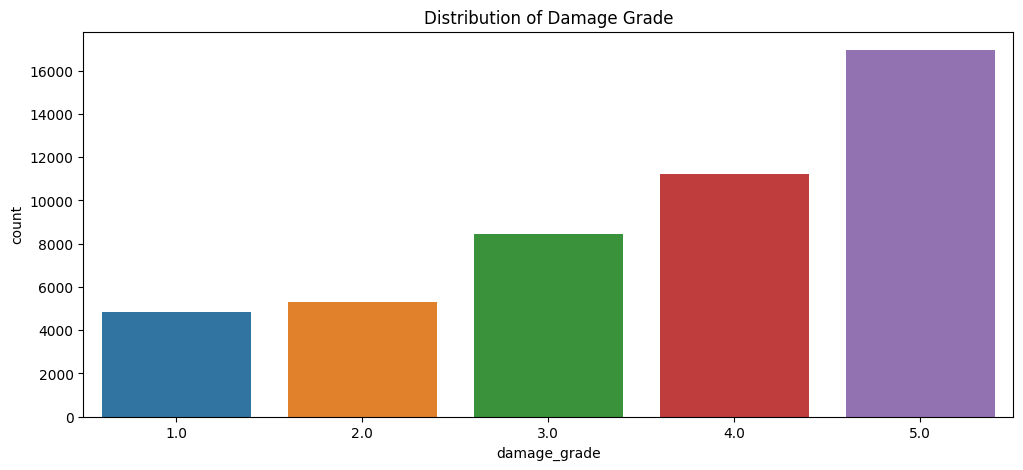

In [31]:
plt.figure(figsize = (12, 5))
ax = sns.countplot(x = 'damage_grade', data = df_csv_1_cleaned)
plt.title("Distribution of Damage Grade")
plt.show()

The distributions are as showed above. Damage grade 5.0 has the most out of the other four.

## Categorical EDA

### 1. Superstructure Flexibility Usage

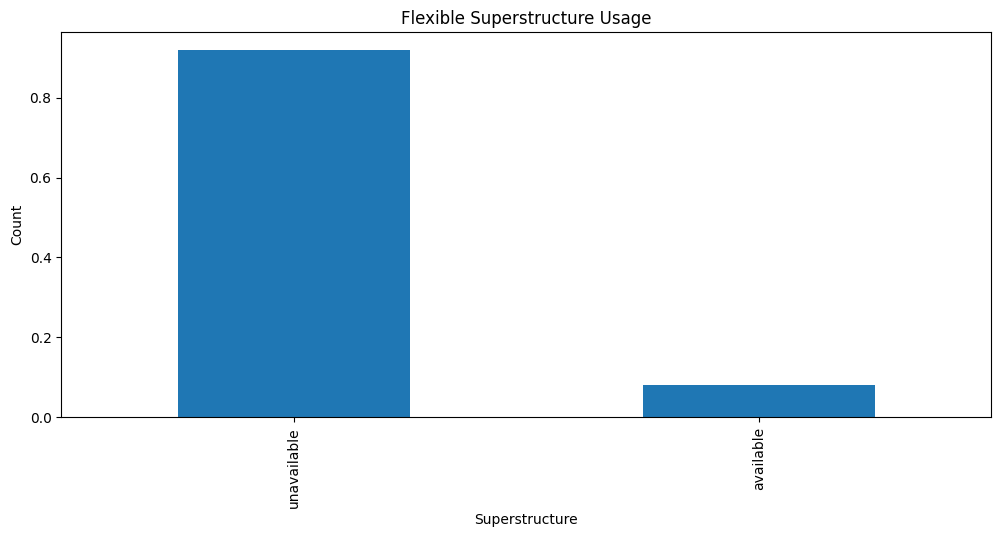

In [292]:
plt.figure(figsize = (12, 5))
ax = df_csv_1_cleaned.flexible_superstructure.value_counts(normalize = True).plot(kind = "bar")

plt.title("Flexible Superstructure Usage")
plt.ylabel("Count")
plt.xlabel("Superstructure")
plt.show()

<ipython-input-293-ed22048ca9b0>:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


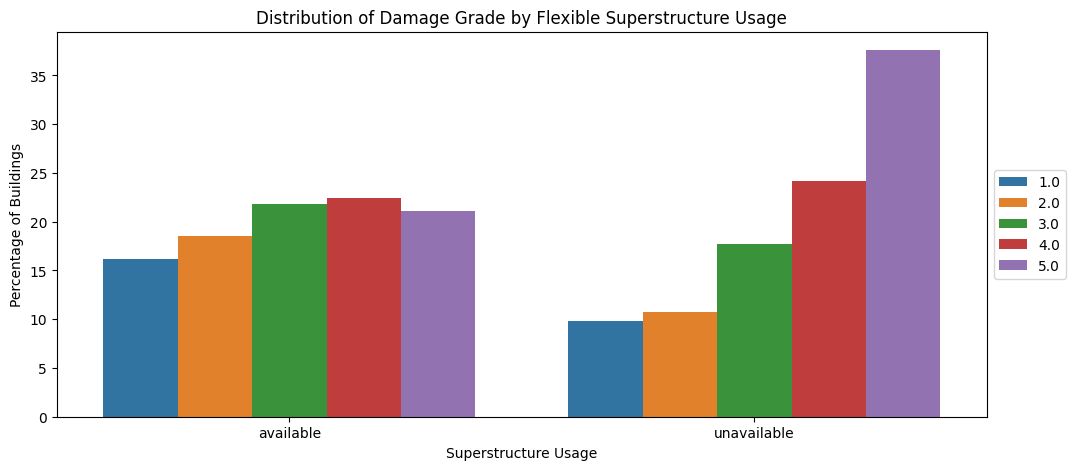

In [293]:
df_temp = df_csv_1_cleaned.groupby(['flexible_superstructure','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['flexible_superstructure', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

plt.figure(figsize = (12, 5))
ax = sns.barplot(data = df_temp, 
                 x = 'flexible_superstructure', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Flexible Superstructure Usage")
plt.xlabel("Superstructure Usage")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-294-ab243b1afc6a>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


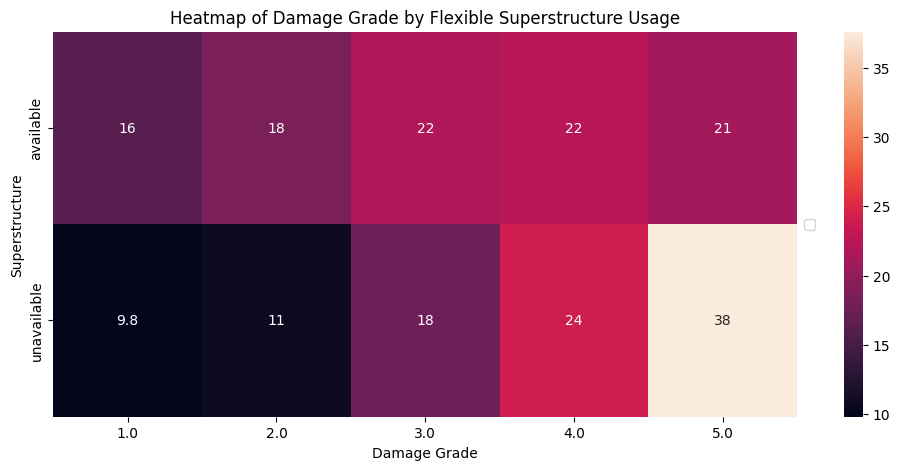

In [294]:
## Heatmap
df_temp = df_csv_1_cleaned.groupby(['flexible_superstructure','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['flexible_superstructure', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['flexible_superstructure'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Flexible Superstructure Usage")
plt.xlabel("Damage Grade")
plt.ylabel("Superstructure")
plt.show()

### 2. Floors before Earthquake

<ipython-input-35-8fecacb3d916>:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


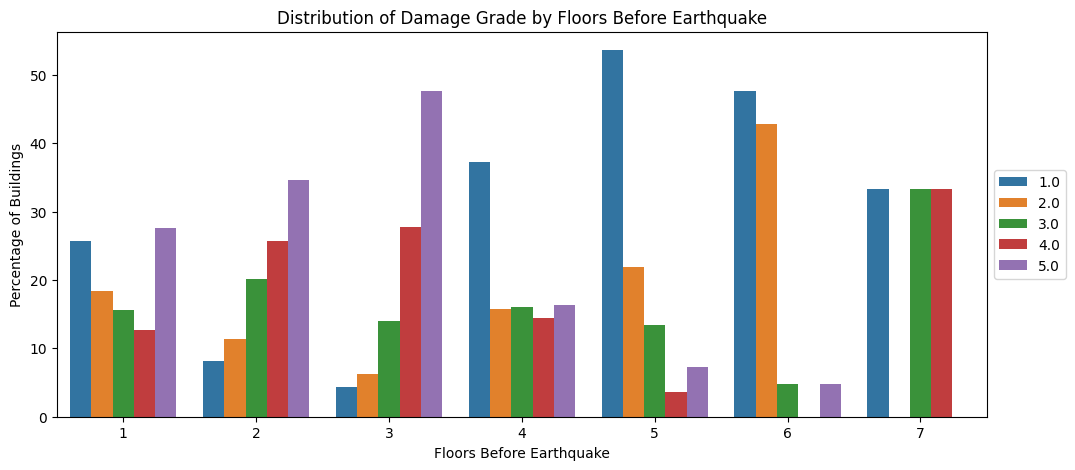

In [35]:
df_temp = df_csv_1_cleaned.groupby(['floors_before_eq (total)','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['floors_before_eq (total)', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (12, 5))
ax = sns.barplot(data = df_temp, 
                 x = 'floors_before_eq (total)', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Floors Before Earthquake")
plt.xlabel("Floors Before Earthquake")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-36-0c3d9cc94daa>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


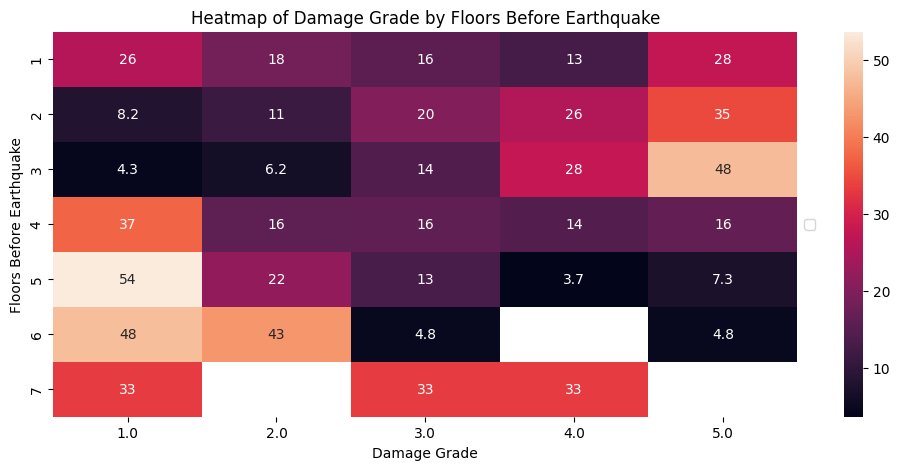

In [36]:
## Heatmap
df_temp = df_csv_1_cleaned.groupby(['floors_before_eq (total)','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['floors_before_eq (total)', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['floors_before_eq (total)'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Floors Before Earthquake")
plt.xlabel("Damage Grade")
plt.ylabel("Floors Before Earthquake")
plt.show()

### 3. Land Surface Condition

<ipython-input-37-068b4f789279>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


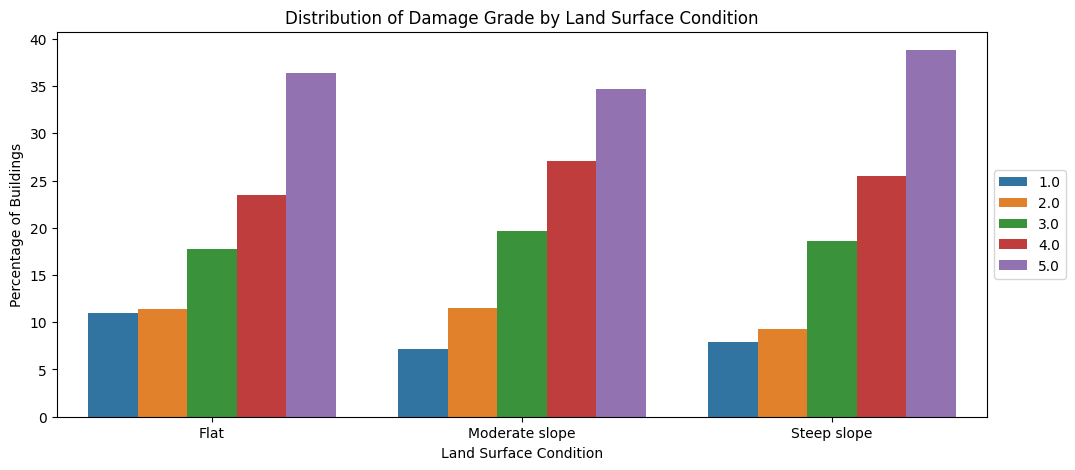

In [37]:
# Calculate counts
df_temp = df_csv_1_cleaned.groupby(['land_surface_condition','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['land_surface_condition', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (12, 5))
ax = sns.barplot(data = df_temp, 
                 x = 'land_surface_condition', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Land Surface Condition")
plt.xlabel("Land Surface Condition")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-38-2537baf03b33>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


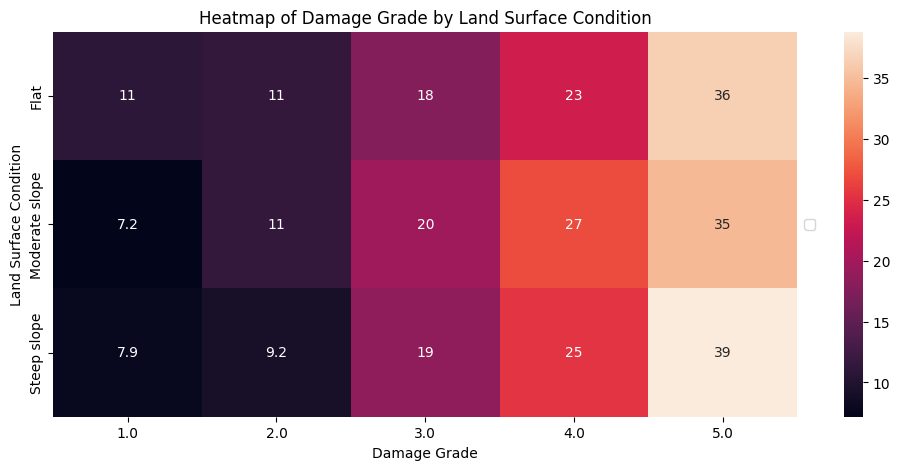

In [38]:
## Heatmap
df_temp = df_csv_1_cleaned.groupby(['land_surface_condition','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['land_surface_condition', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['land_surface_condition'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Land Surface Condition")
plt.xlabel("Damage Grade")
plt.ylabel("Land Surface Condition")
plt.show()

### 4. Type of Foundation

<ipython-input-39-65080f9e944d>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


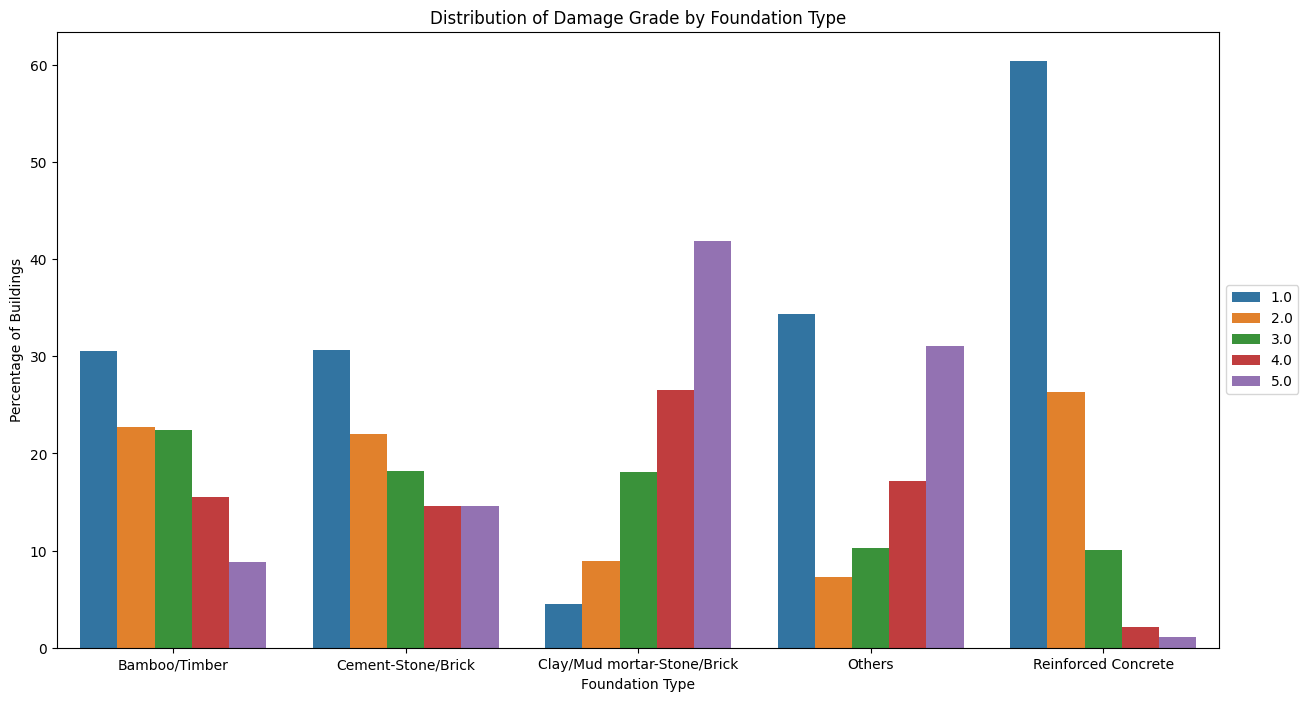

In [39]:
# Calculate counts
df_temp = df_csv_1_cleaned.groupby(['type_of_foundation','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_foundation', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'type_of_foundation', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Foundation Type")
plt.xlabel("Foundation Type")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-40-ccfed1621672>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


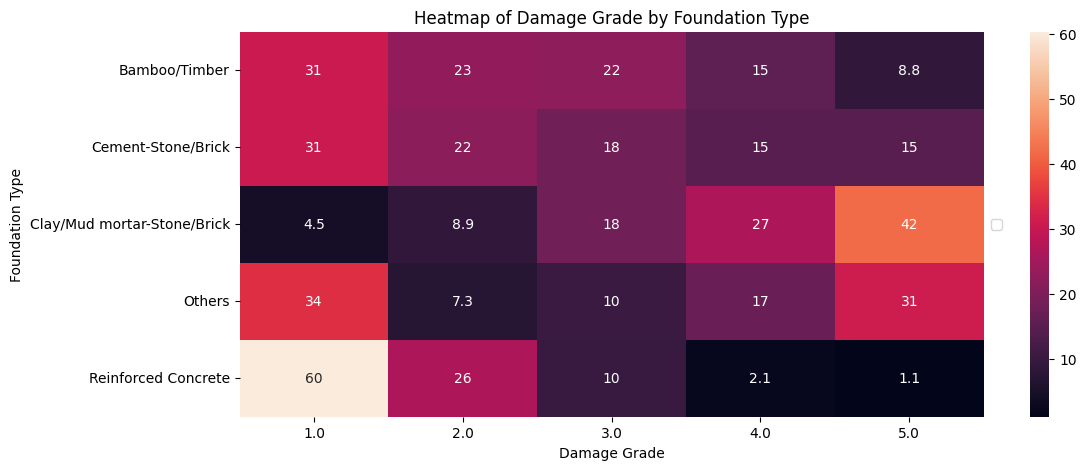

In [40]:
## Heatmap
df_temp = df_csv_1_cleaned.groupby(['type_of_foundation','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_foundation', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['type_of_foundation'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Foundation Type")
plt.xlabel("Damage Grade")
plt.ylabel("Foundation Type")
plt.show()

### 5. Type of Roof

<ipython-input-41-08b53bb95731>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


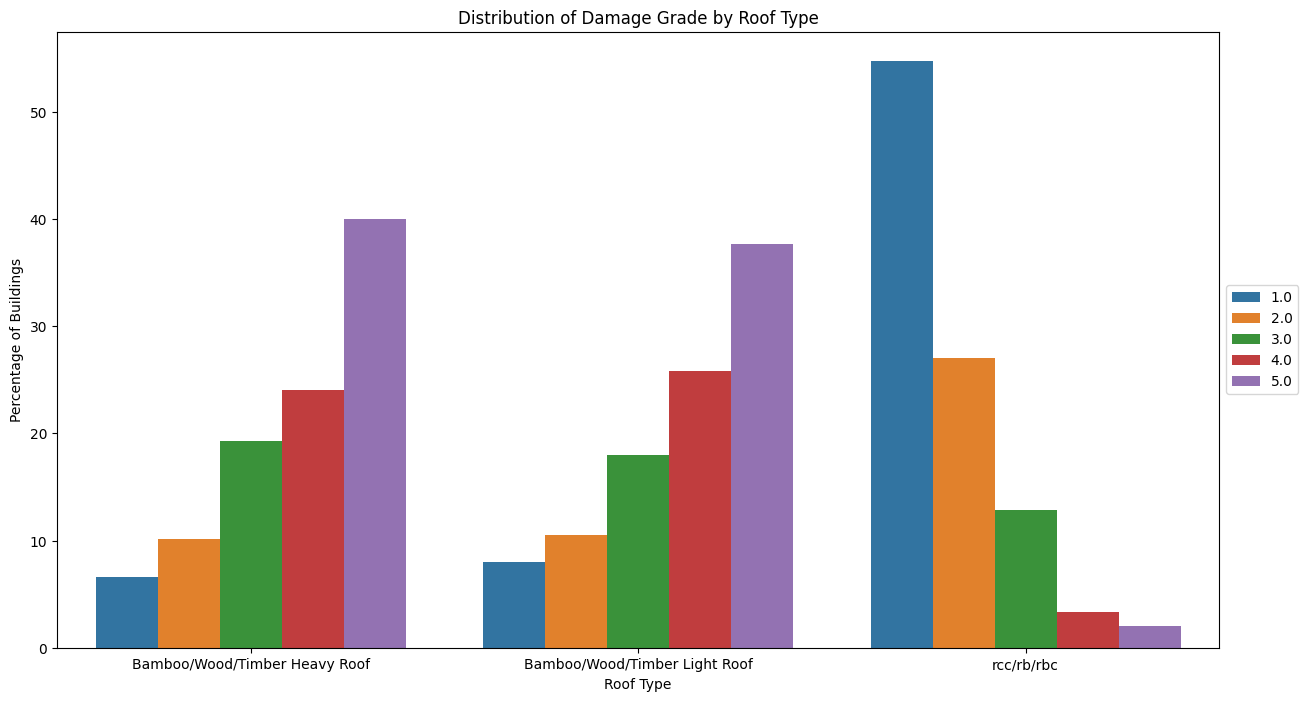

In [41]:
# Calculate counts
df_temp = df_csv_1_cleaned.groupby(['type_of_roof','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_roof', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'type_of_roof', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Roof Type")
plt.xlabel("Roof Type")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-42-5355b4b45c77>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


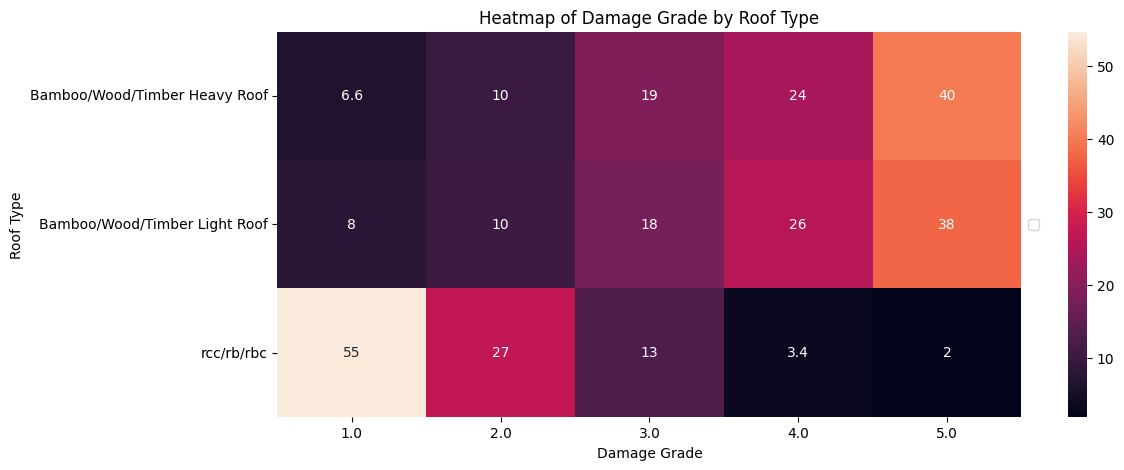

In [42]:
## Heatmap
df_temp = df_csv_1_cleaned.groupby(['type_of_roof','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_roof', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['type_of_roof'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Roof Type")
plt.xlabel("Damage Grade")
plt.ylabel("Roof Type")
plt.show()

### 6. Type of Ground Floor

<ipython-input-43-dc0f0d045f3b>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


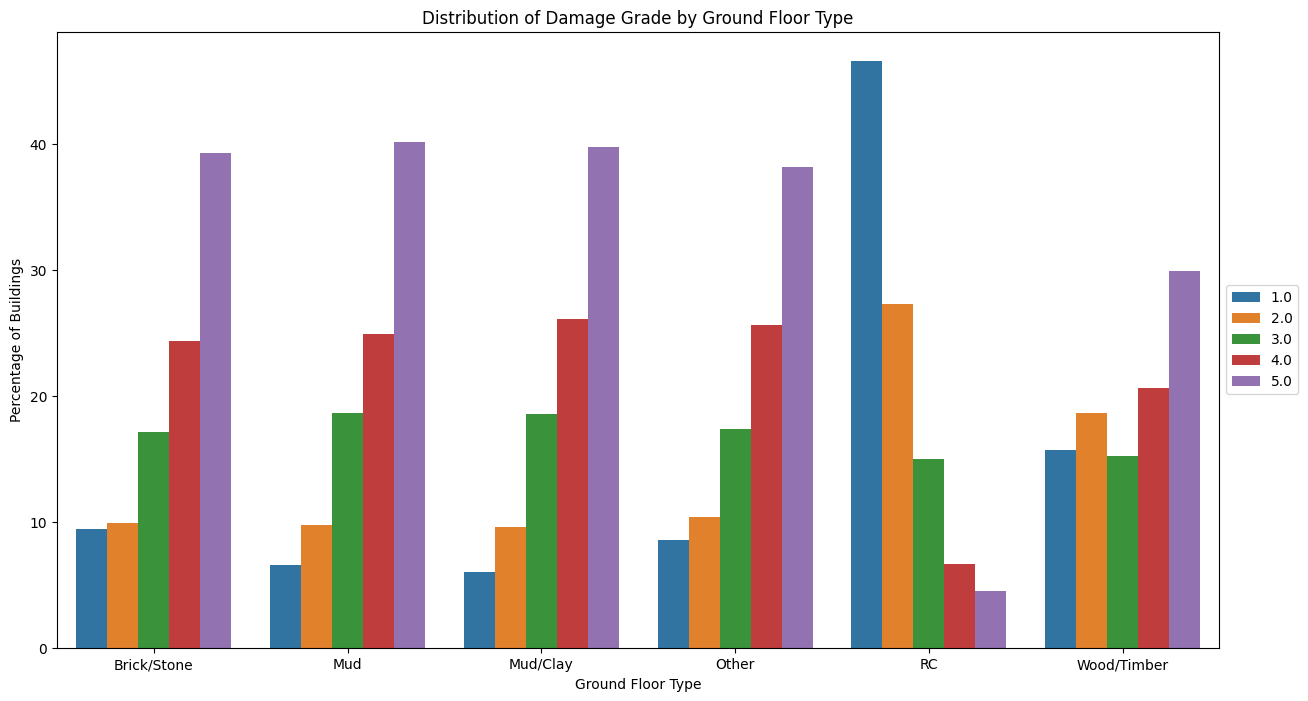

In [43]:
# Calculate counts
df_temp = df_csv_1_cleaned.groupby(['type_of_ground_floor','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_ground_floor', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'type_of_ground_floor', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Ground Floor Type")
plt.xlabel("Ground Floor Type")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-44-904268751592>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


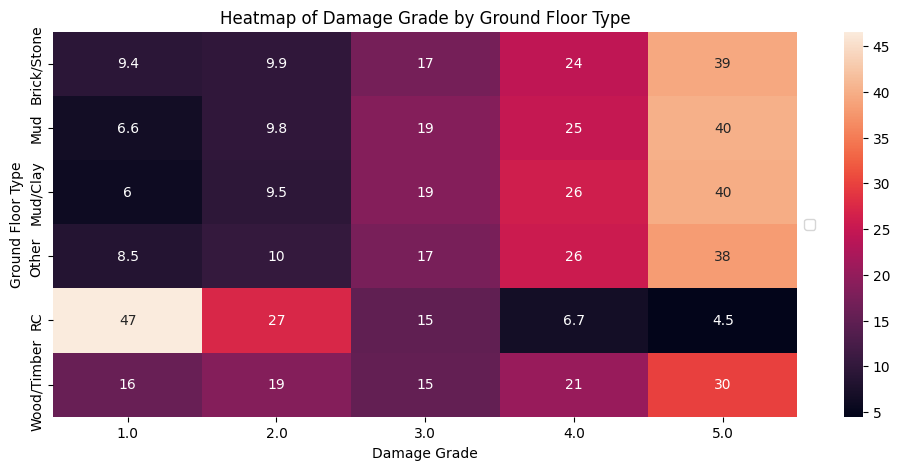

In [44]:
## Heatmap
df_temp = df_csv_1_cleaned.groupby(['type_of_ground_floor','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_ground_floor', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['type_of_ground_floor'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Ground Floor Type")
plt.xlabel("Damage Grade")
plt.ylabel("Ground Floor Type")
plt.show()

### 7. Type of Other Floor

<ipython-input-45-0c338a13258f>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


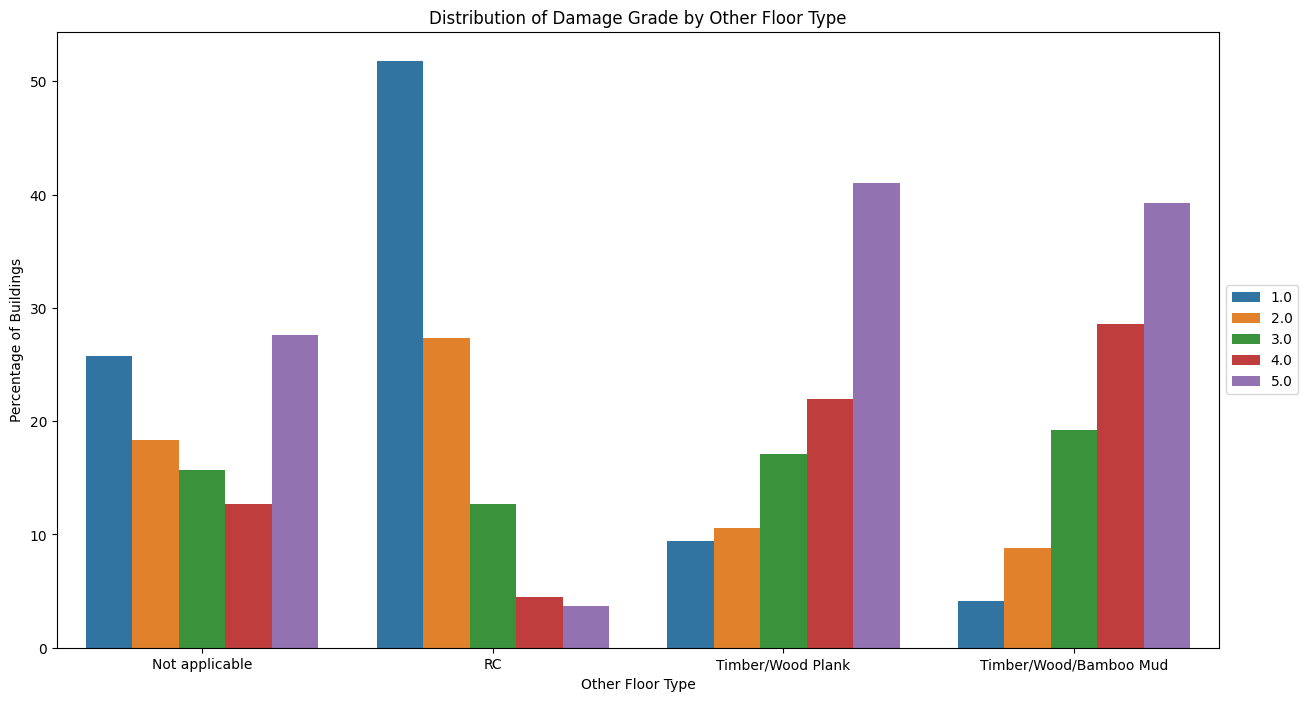

In [45]:
# Calculate counts
df_temp = df_csv_1_cleaned.groupby(['type_of_other_floor','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_other_floor', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'type_of_other_floor', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Other Floor Type")
plt.xlabel("Other Floor Type")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-46-d0293835e733>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


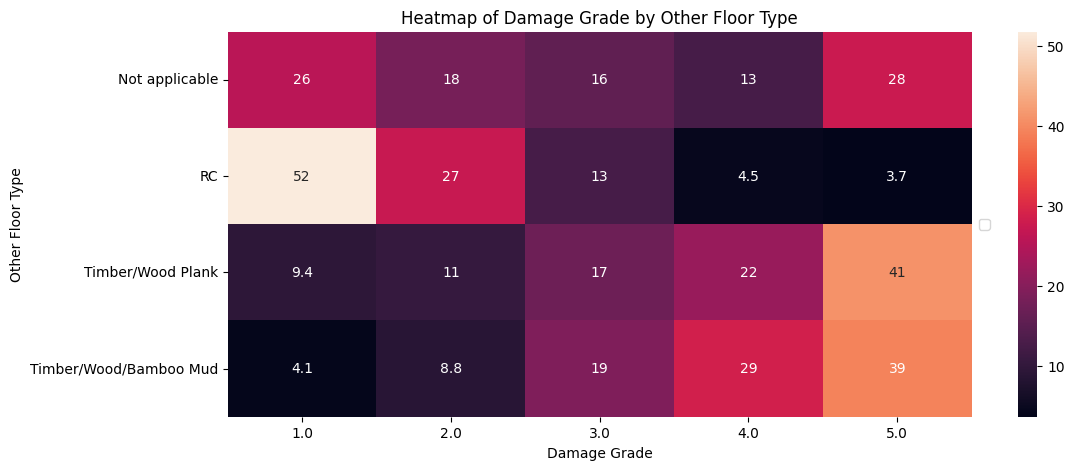

In [46]:
## Heatmap
df_temp = df_csv_1_cleaned.groupby(['type_of_other_floor','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_other_floor', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['type_of_other_floor'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Other Floor Type")
plt.xlabel("Damage Grade")
plt.ylabel("Other Floor Type")
plt.show()

### 8. Position

<ipython-input-47-c9165250ab50>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


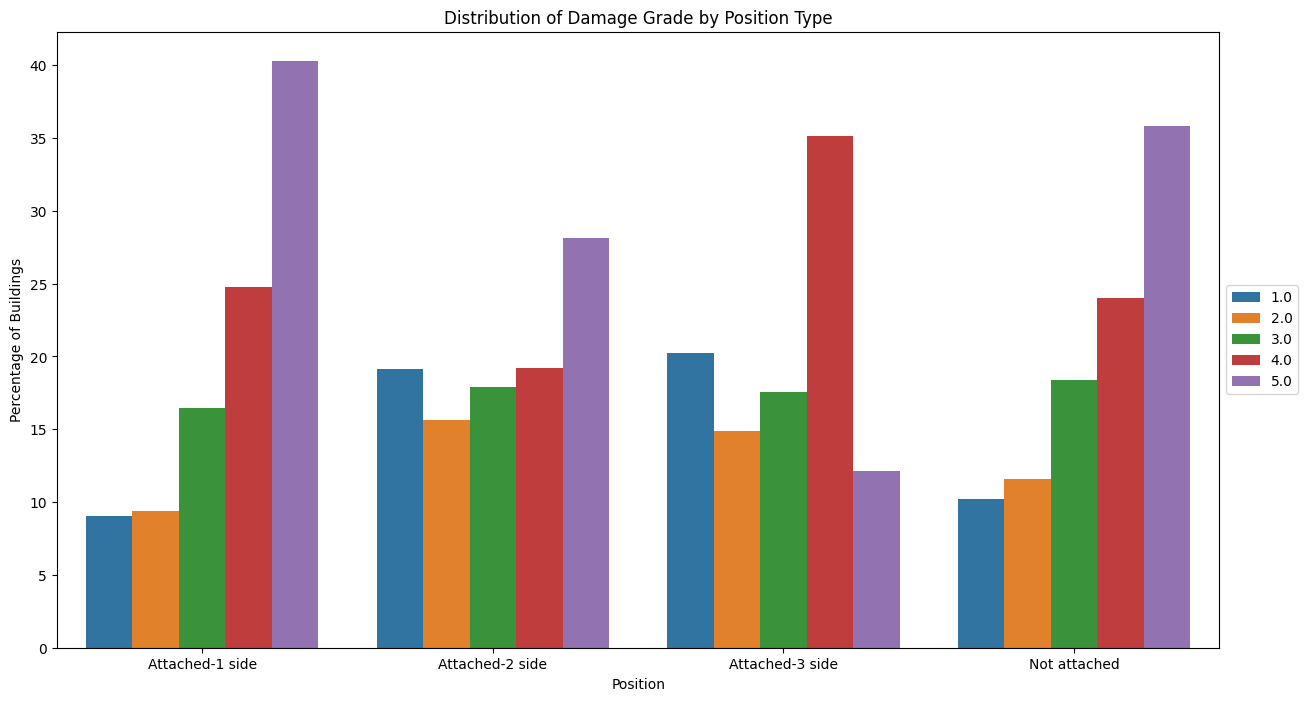

In [47]:
# Calculate counts
df_temp = df_csv_1_cleaned.groupby(['position','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['position', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'position', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Position Type")
plt.xlabel("Position")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-48-38dfd956bd6e>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


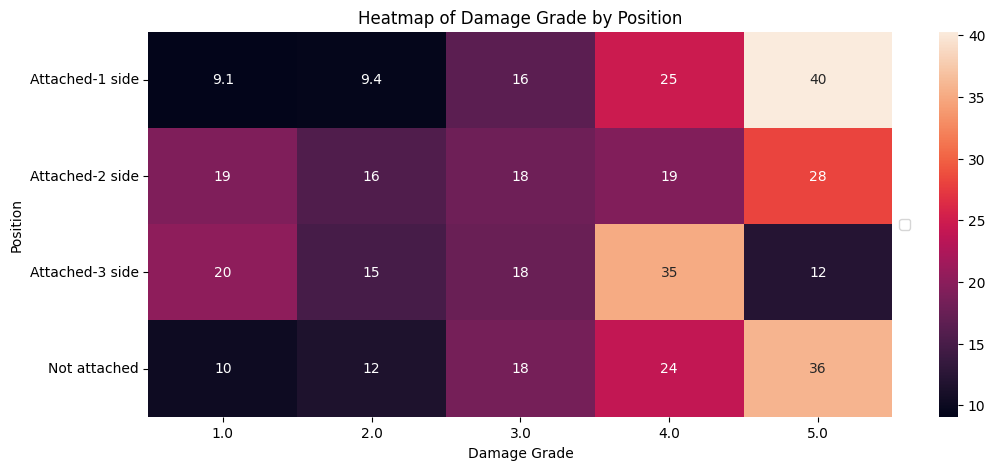

In [48]:
## Heatmap
df_temp = df_csv_1_cleaned.groupby(['position','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['position', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['position'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Position")
plt.xlabel("Damage Grade")
plt.ylabel("Position")
plt.show()

### 9. Industrial Use Type

<ipython-input-49-1e17d41530d4>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


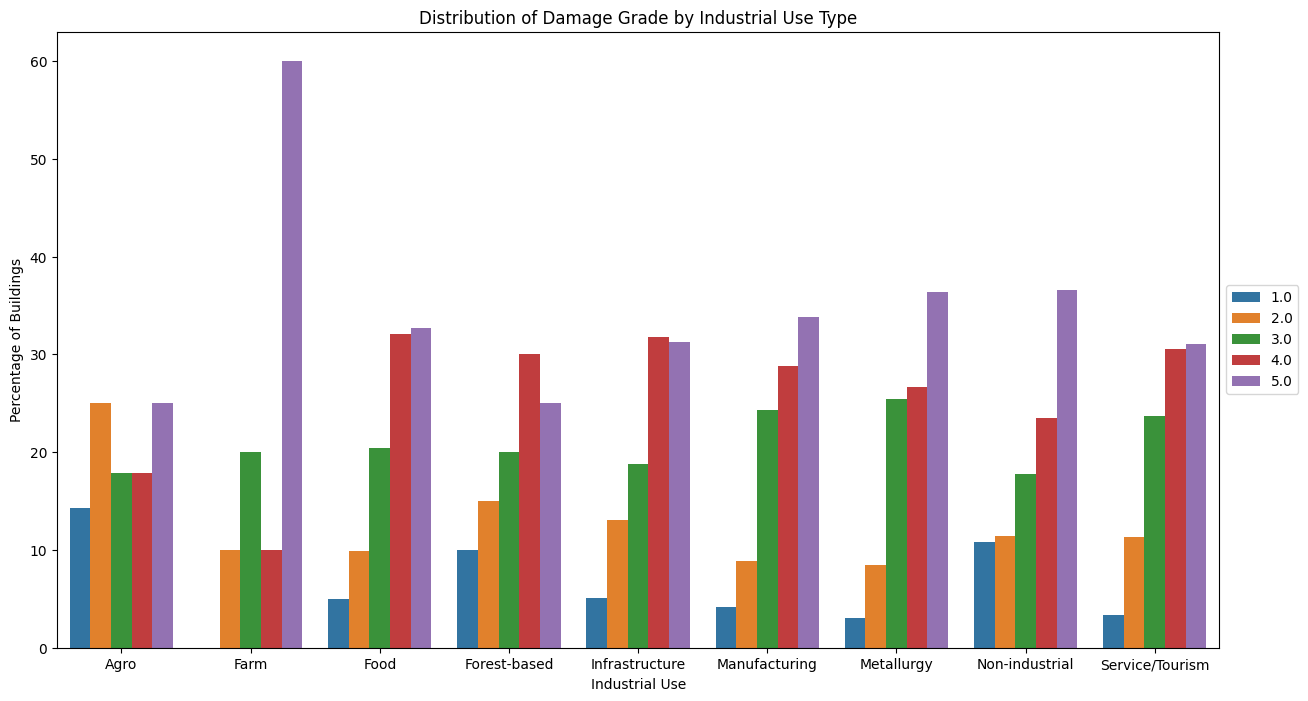

In [49]:
# Calculate counts
df_temp = df_csv_1_cleaned.groupby(['industrial_use_type','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['industrial_use_type', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'industrial_use_type', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Industrial Use Type")
plt.xlabel("Industrial Use")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-50-3d63a5c7b1d1>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


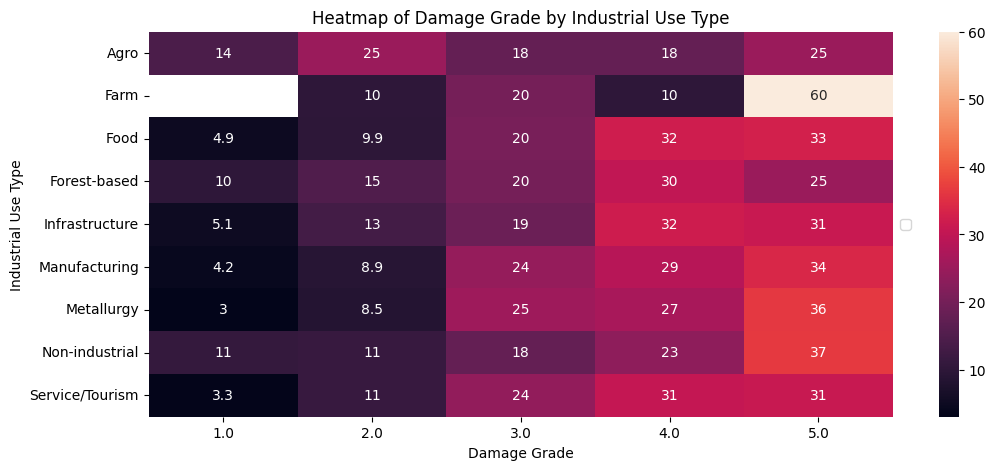

In [50]:
## Heatmap
df_temp = df_csv_1_cleaned.groupby(['industrial_use_type','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['industrial_use_type', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['industrial_use_type'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Industrial Use Type")
plt.xlabel("Damage Grade")
plt.ylabel("Industrial Use Type")
plt.show()

### 10. Type of Reinforcement Concrete

<ipython-input-51-3818fa92a05f>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


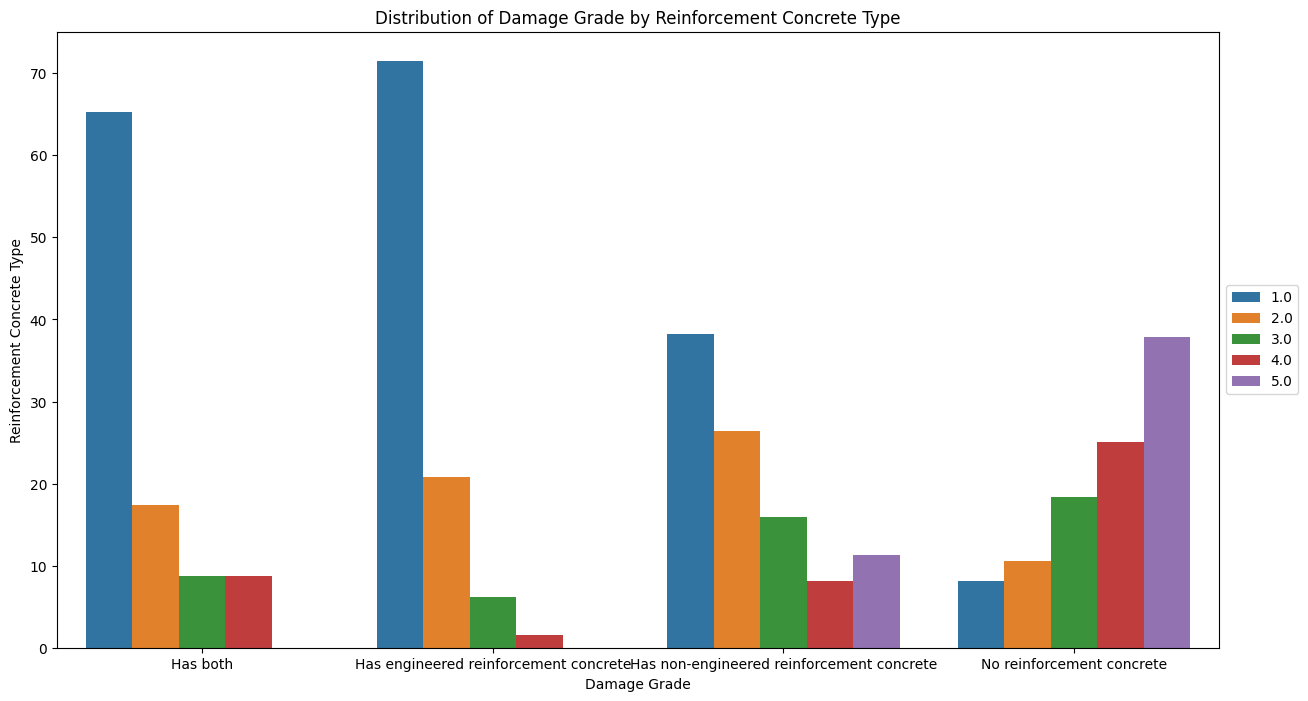

In [51]:
# Calculate counts
df_temp = df_csv_1_cleaned.groupby(['type_of_reinforcement_concrete','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_reinforcement_concrete', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'type_of_reinforcement_concrete', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Reinforcement Concrete Type")
plt.xlabel("Damage Grade")
plt.ylabel("Reinforcement Concrete Type")
plt.show()

<ipython-input-52-668660aa63b1>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


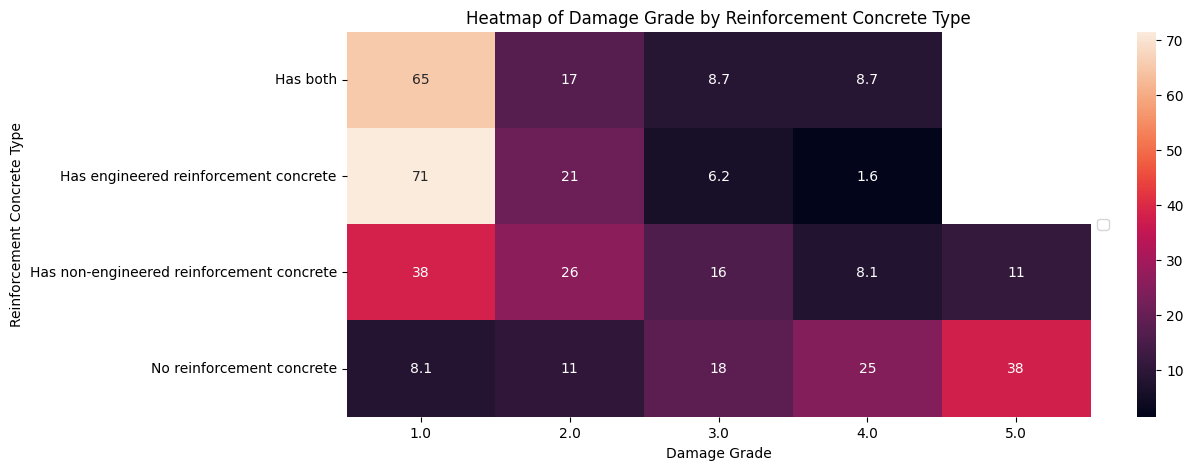

In [52]:
## Heatmap
df_temp = df_csv_1_cleaned.groupby(['type_of_reinforcement_concrete','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_reinforcement_concrete', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['type_of_reinforcement_concrete'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Reinforcement Concrete Type")
plt.xlabel("Damage Grade")
plt.ylabel("Reinforcement Concrete Type")
plt.show()

### 11. Wall Binding

<ipython-input-53-94c86ddd0fea>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


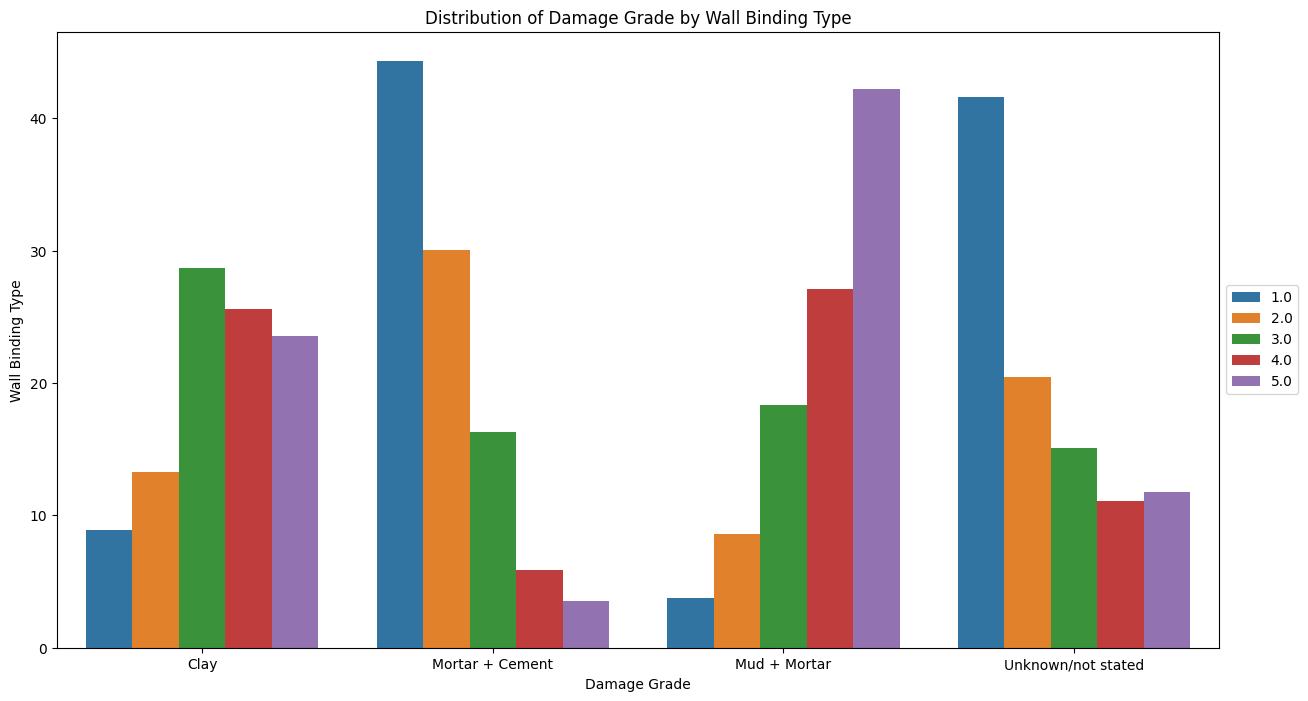

In [53]:
# Calculate counts
df_temp = df_csv_1_cleaned.groupby(['wall_binding','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['wall_binding', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'wall_binding', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Wall Binding Type")
plt.xlabel("Damage Grade")
plt.ylabel("Wall Binding Type")
plt.show()

<ipython-input-54-837960a0b078>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


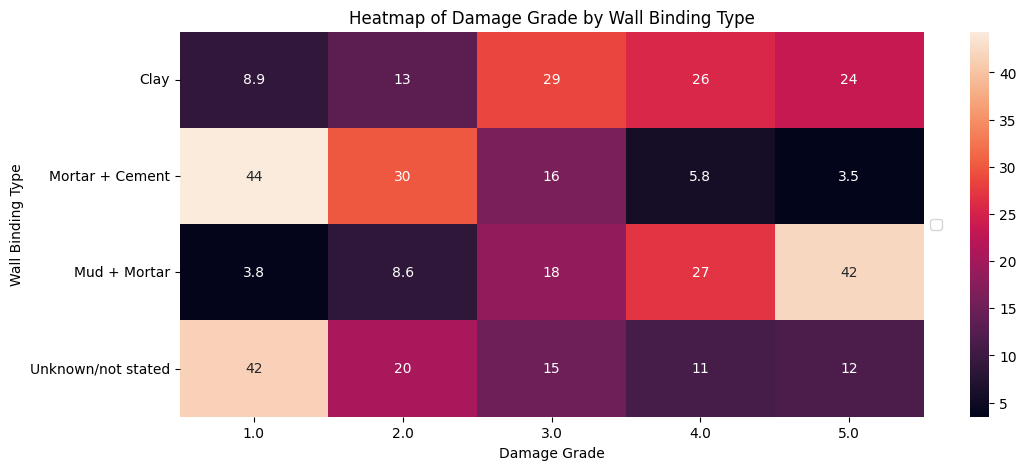

In [54]:
## Heatmap
df_temp = df_csv_1_cleaned.groupby(['wall_binding','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['wall_binding', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['wall_binding'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Wall Binding Type")
plt.xlabel("Damage Grade")
plt.ylabel("Wall Binding Type")
plt.show()

### 12. Wall Materials

<ipython-input-55-1762f58507cf>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


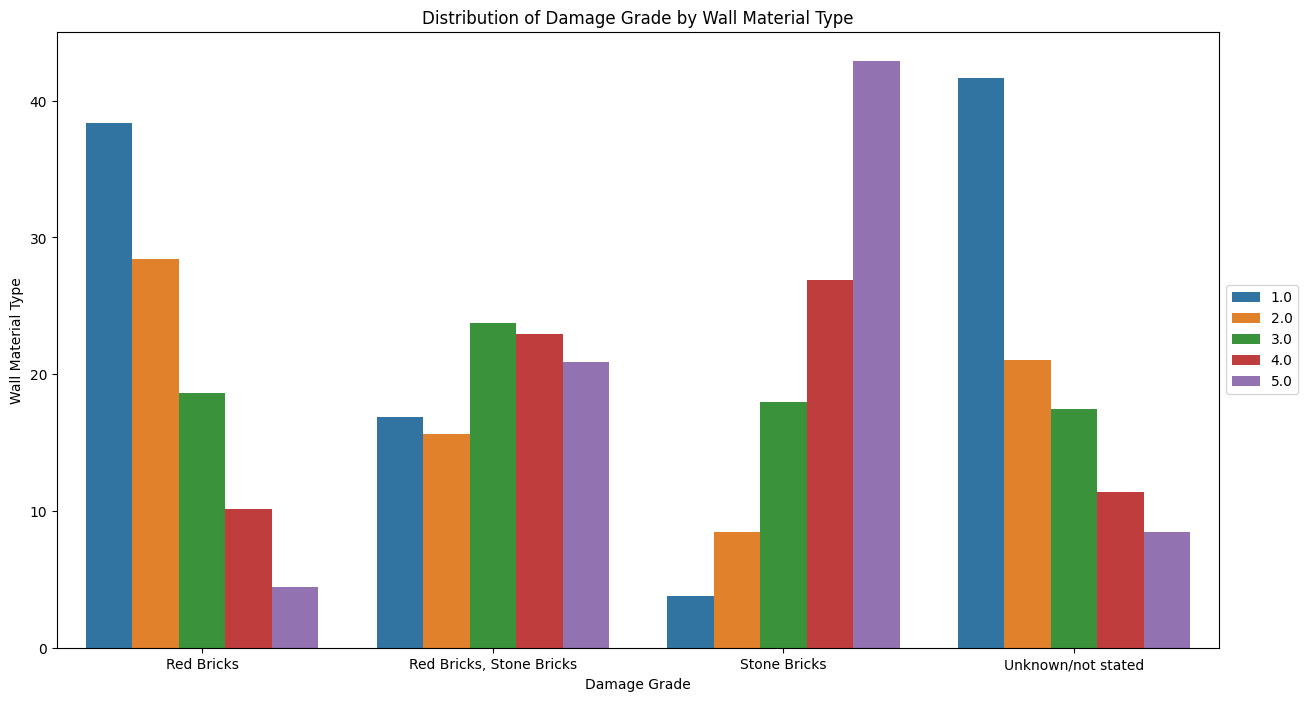

In [55]:
# Calculate counts
df_temp = df_csv_1_cleaned.groupby(['wall_material','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['wall_material', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'wall_material', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Wall Material Type")
plt.xlabel("Damage Grade")
plt.ylabel("Wall Material Type")
plt.show()

<ipython-input-56-8c4a9ae0dd68>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


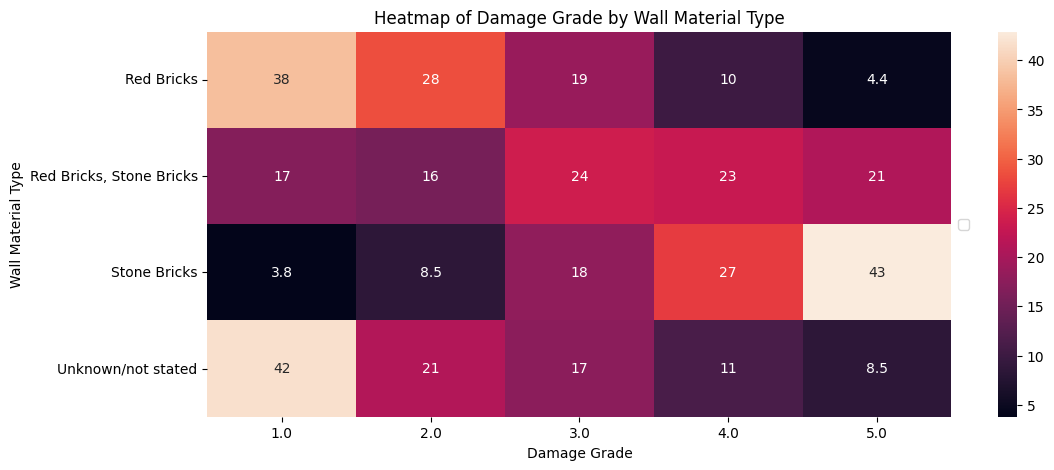

In [56]:
## Heatmap
df_temp = df_csv_1_cleaned.groupby(['wall_material','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['wall_material', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['wall_material'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Wall Material Type")
plt.xlabel("Damage Grade")
plt.ylabel("Wall Material Type")
plt.show()

### 13. Building Plan Config

<ipython-input-57-6914233e9264>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


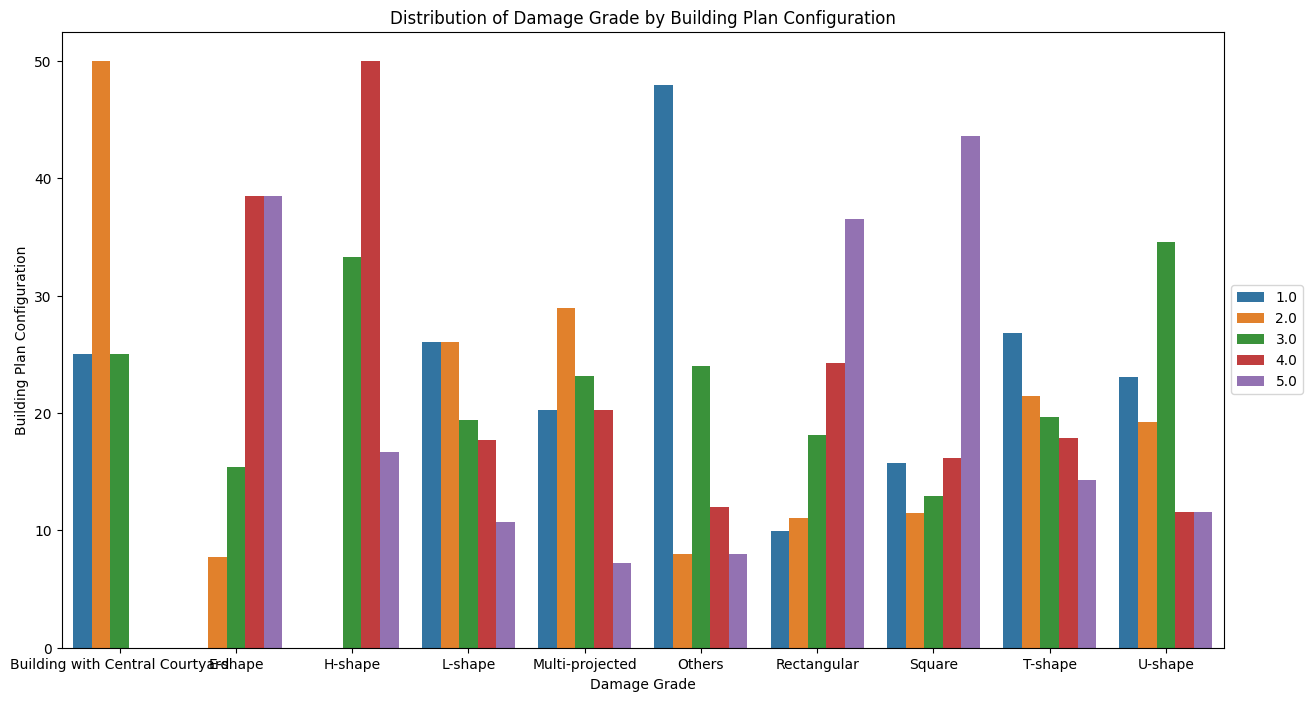

In [57]:
# Calculate counts
df_temp = df_csv_1_cleaned.groupby(['building_plan_configuration','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['building_plan_configuration', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'building_plan_configuration', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Building Plan Configuration")
plt.xlabel("Damage Grade")
plt.ylabel("Building Plan Configuration")
plt.show()

<ipython-input-58-7f79c106ef32>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


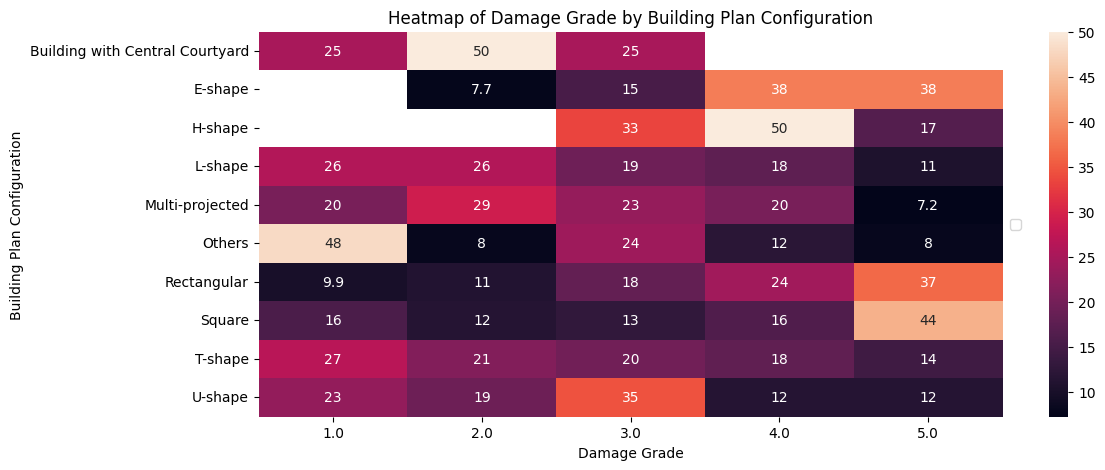

In [58]:
## Heatmap
df_temp = df_csv_1_cleaned.groupby(['building_plan_configuration','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['building_plan_configuration', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['building_plan_configuration'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Building Plan Configuration")
plt.xlabel("Damage Grade")
plt.ylabel("Building Plan Configuration")
plt.show()

### 14. Technical Solution Proposed

<ipython-input-59-b1a6ee9203d0>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


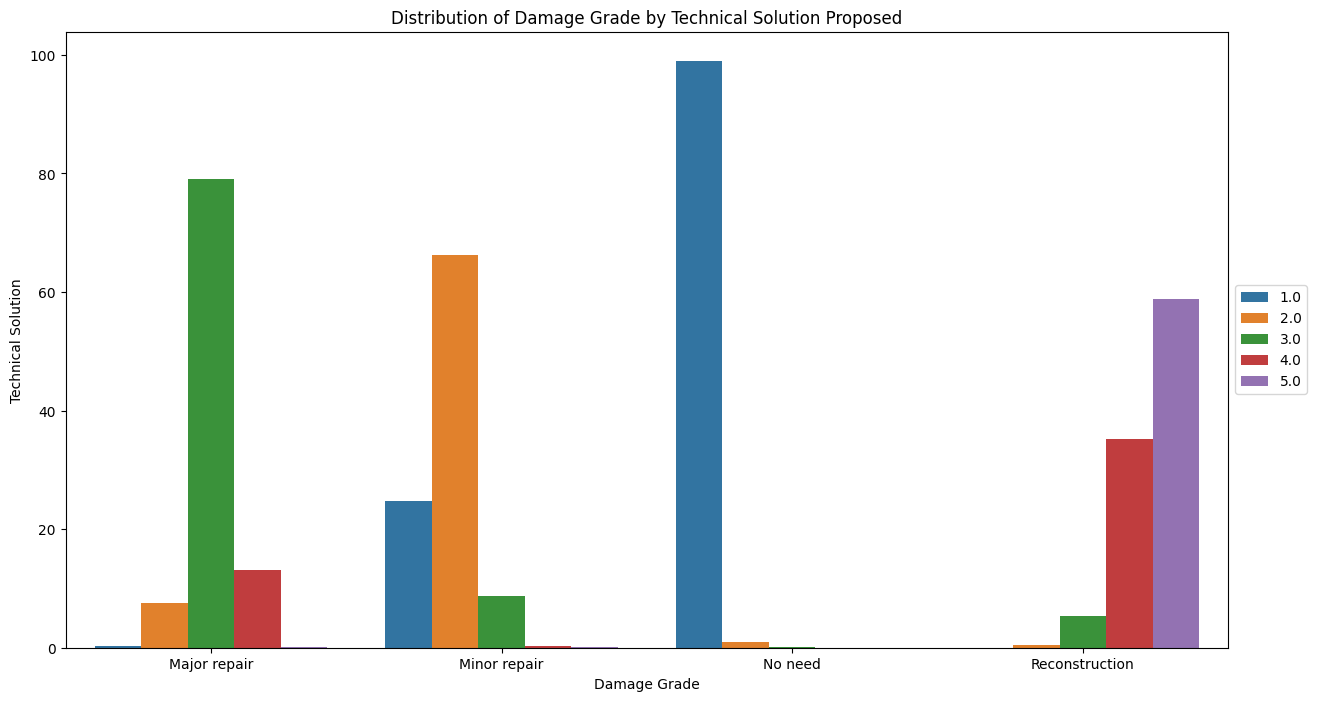

In [59]:
# Calculate counts
df_temp = df_csv_1_cleaned.groupby(['technical_solution_proposed','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['technical_solution_proposed', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'technical_solution_proposed', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Technical Solution Proposed")
plt.xlabel("Damage Grade")
plt.ylabel("Technical Solution")
plt.show()

<ipython-input-60-cc9c9733fd71>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


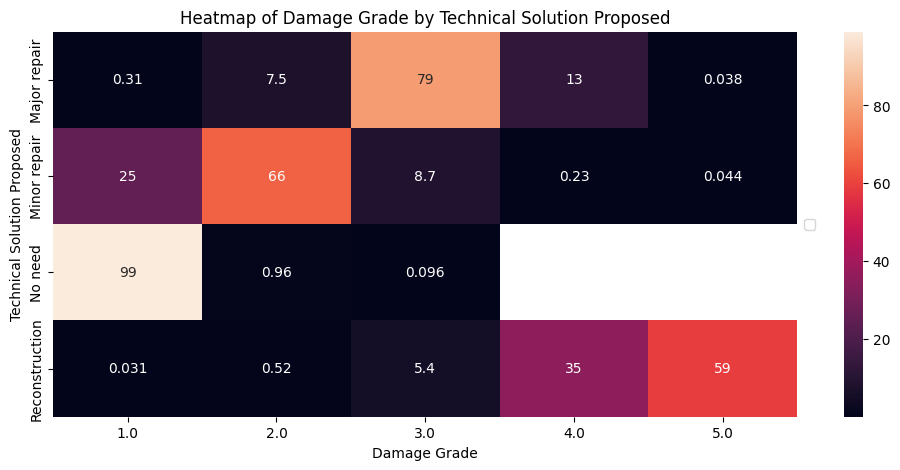

In [60]:
## Heatmap
df_temp = df_csv_1_cleaned.groupby(['technical_solution_proposed','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['technical_solution_proposed', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['technical_solution_proposed'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Technical Solution Proposed")
plt.xlabel("Damage Grade")
plt.ylabel("Technical Solution Proposed")
plt.show()

<ipython-input-295-eb3e02028450>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


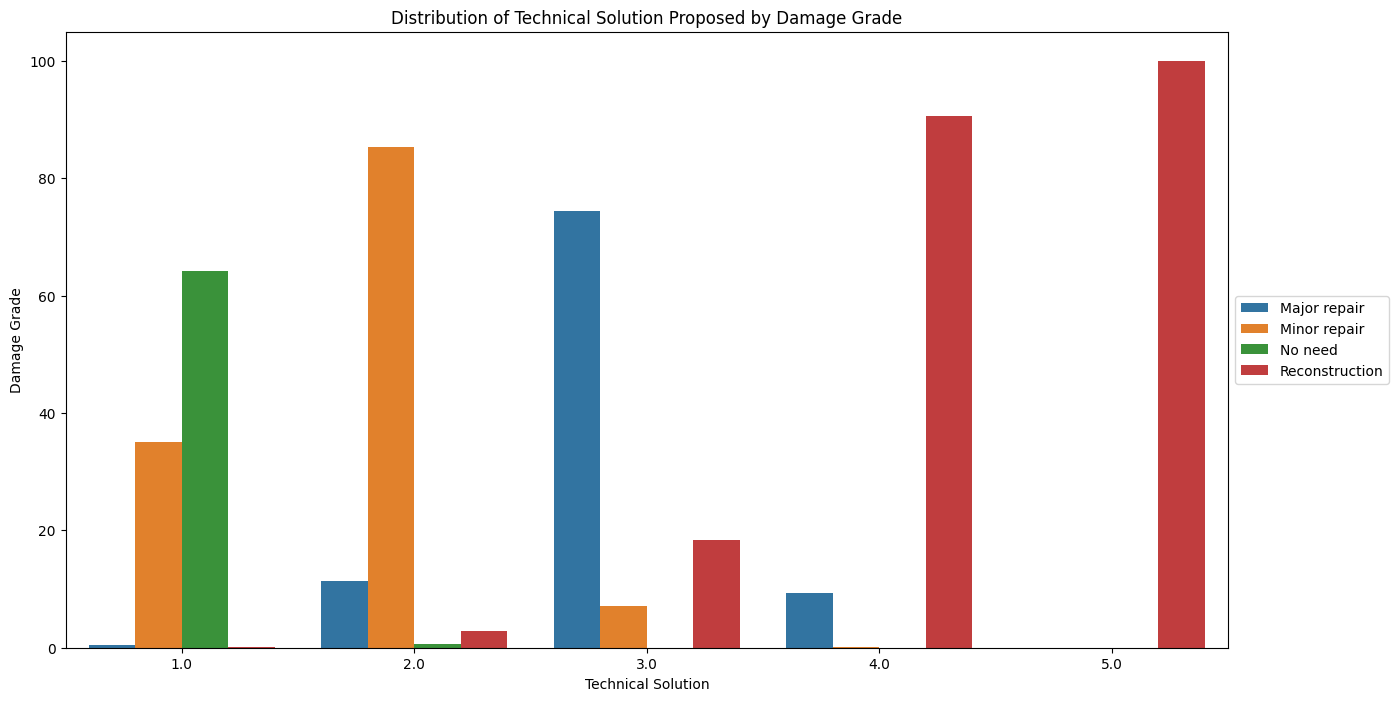

In [295]:
# Calculate counts
df_temp = df_csv_1_cleaned.groupby(['damage_grade','technical_solution_proposed']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['damage_grade', 'technical_solution_proposed'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'damage_grade', 
                 y = 'count', 
                 hue = 'technical_solution_proposed')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Technical Solution Proposed by Damage Grade")
plt.xlabel("Technical Solution")
plt.ylabel("Damage Grade")
plt.show()

## Numerical Data

Since there are a lot of unique values in the numerical features, we will group them into bins.

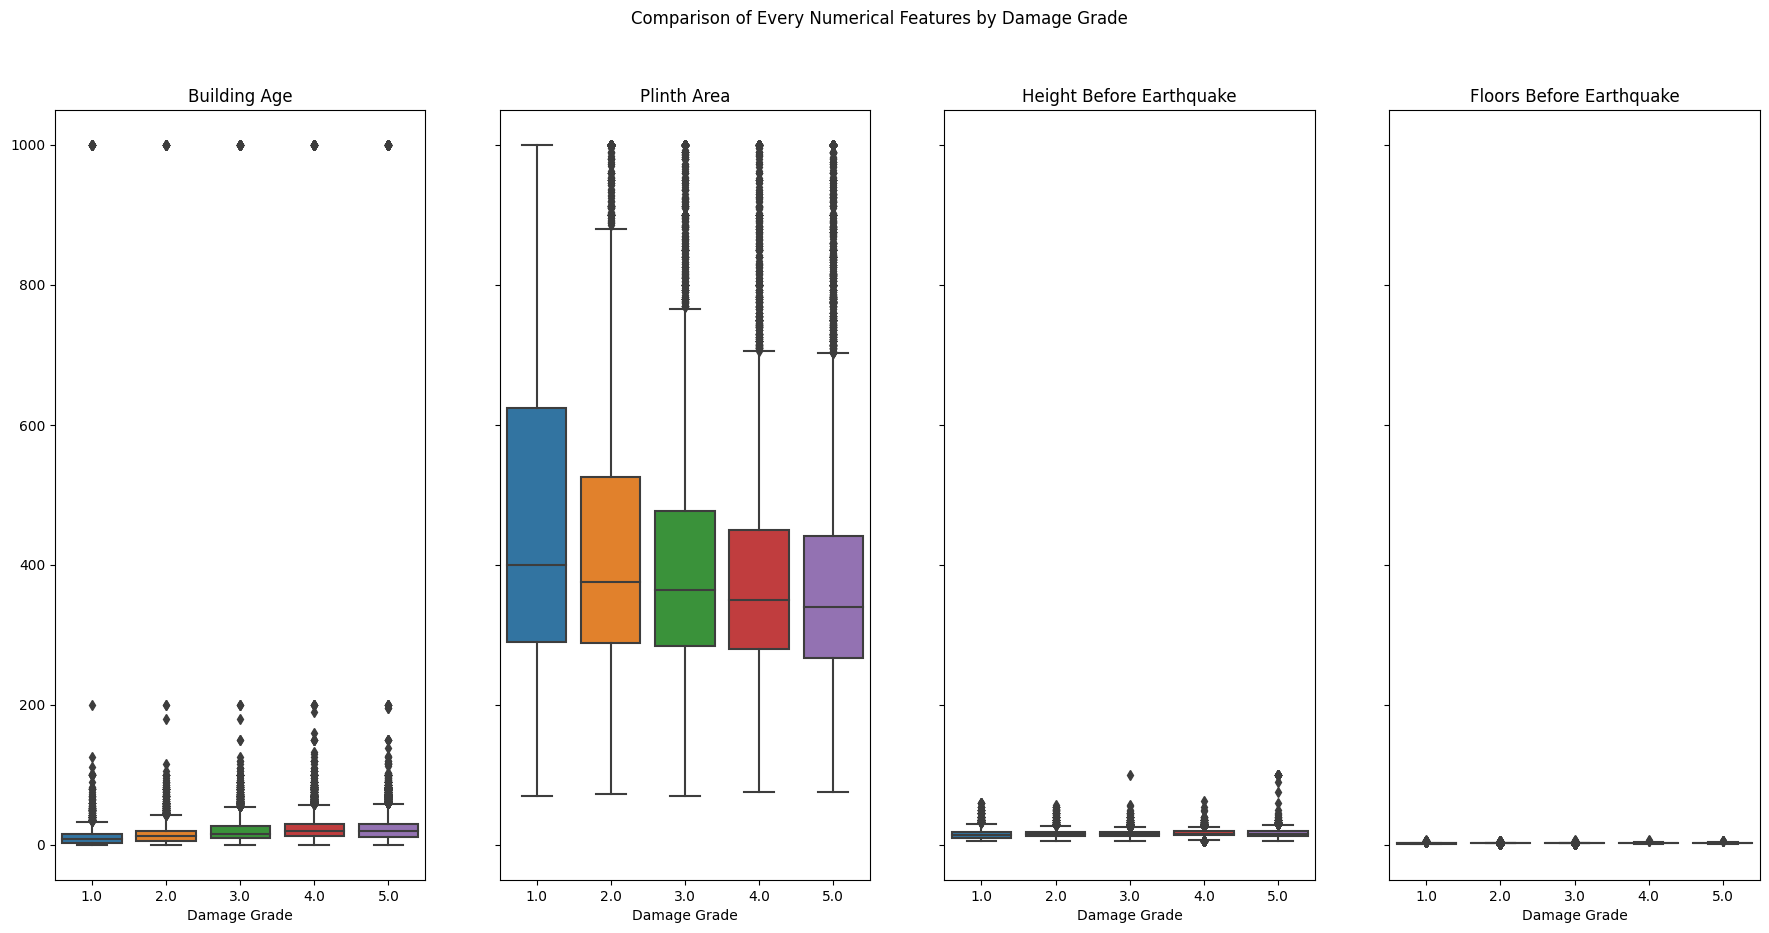

In [69]:
## Checking the distribution using boxplot
fig, ax = plt.subplots(1, 4, figsize = (22, 10), sharey = 'row')
fig.suptitle("Comparison of Every Numerical Features by Damage Grade")

ax[0].set_title("Building Age")
ax[1].set_title("Plinth Area")
ax[2].set_title("Height Before Earthquake")
ax[3].set_title("Floors Before Earthquake")

sns.boxplot(data = df_csv_1_cleaned, 
            x = "damage_grade", 
            y = "old_building", 
            ax = ax[0])
sns.boxplot(data = df_csv_1_cleaned, 
            x = "damage_grade", 
            y = "plinth_area (ft^2)", 
            ax = ax[1])
sns.boxplot(data = df_csv_1_cleaned, 
            x = "damage_grade", 
            y = "height_before_eq (ft)", 
            ax = ax[2])
sns.boxplot(data = df_csv_1_cleaned, 
            x = "damage_grade", 
            y = "floors_before_eq (total)", 
            ax = ax[3])

plt.setp(ax[:], xlabel = 'Damage Grade')
plt.setp(ax[0], ylabel = None)
plt.setp(ax[1], ylabel = None)
plt.setp(ax[2], ylabel = None)
plt.setp(ax[3], ylabel = None)
plt.show()

As we can see, both old_building and plinth_area feature should be normalized especially old_building since it has an outlier with the value of 999. 

### 1. Old Building

In [61]:
df_csv_1_cleaned['old_building_cat'] = pd.cut(df_csv_1_cleaned['old_building'], [0, 20, 40, 60, 80, 100, 998, 999], include_lowest=True)

<ipython-input-62-880bd8a9dd59>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


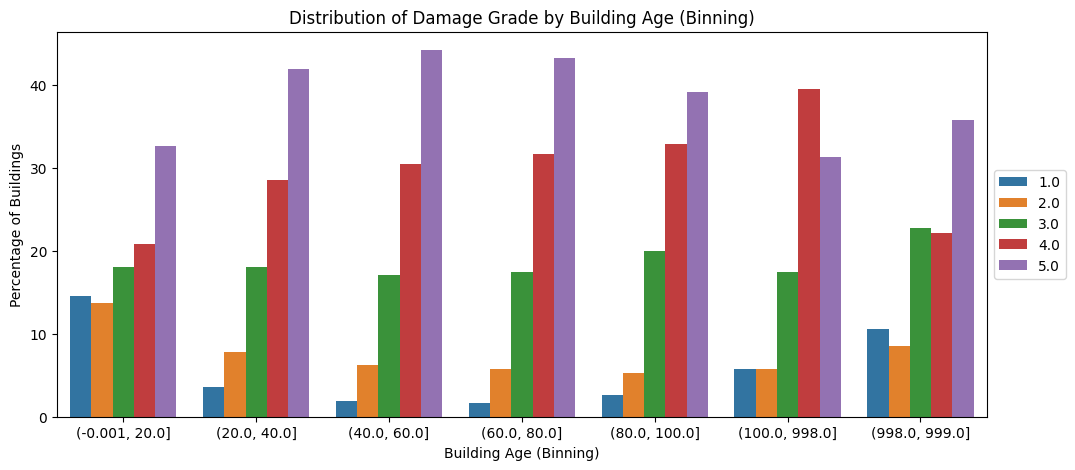

In [62]:
# Calculate counts
df_temp = df_csv_1_cleaned.groupby(['old_building_cat','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['old_building_cat', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (12, 5))
ax = sns.barplot(data = df_temp, 
                 x = 'old_building_cat', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Building Age (Binning)")
plt.xlabel("Building Age (Binning)")
plt.ylabel("Percentage of Buildings")
plt.show()

### 2. Plinth Area

In [63]:
df_csv_1_cleaned['plinth_area_cat'] = pd.cut(df_csv_1_cleaned['plinth_area (ft^2)'], [0, 250, 500, 750, 999, 1001], include_lowest=True)

<ipython-input-64-64c45b293cc9>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


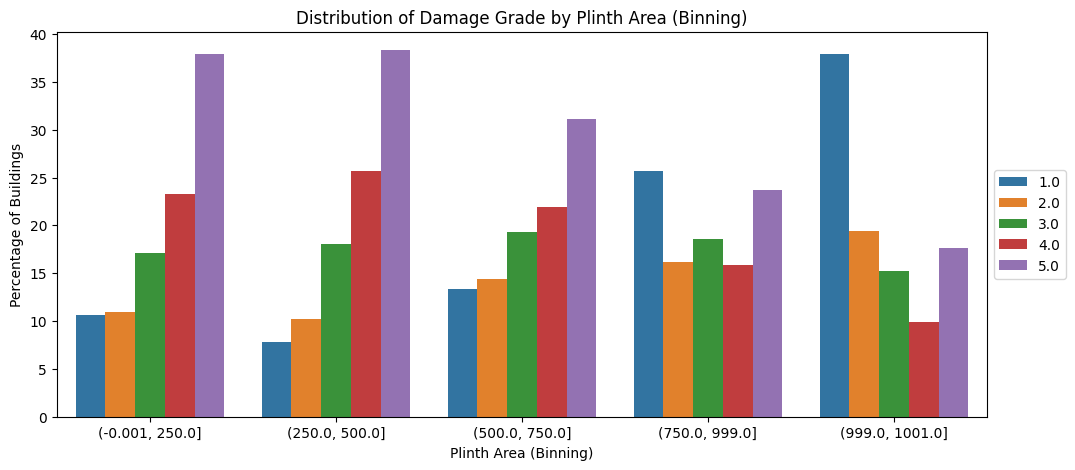

In [64]:
# Calculate counts
df_temp = df_csv_1_cleaned.groupby(['plinth_area_cat','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['plinth_area_cat', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (12, 5))
ax = sns.barplot(data = df_temp, 
                 x = 'plinth_area_cat', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Plinth Area (Binning)")
plt.xlabel("Plinth Area (Binning)")
plt.ylabel("Percentage of Buildings")
plt.show()

## Analysis

Out of all the features, feature "technical_solution_proposed" has the best correlation to the target, meaning almost each value of the feature correspond to each damage grade uniquely. We will look further into this feature

In [65]:
df_csv_1_cleaned['technical_solution_proposed'].value_counts()

Reconstruction    28847
Major repair       7963
Minor repair       6852
No need            3139
Name: technical_solution_proposed, dtype: int64

<Figure size 3000x800 with 0 Axes>

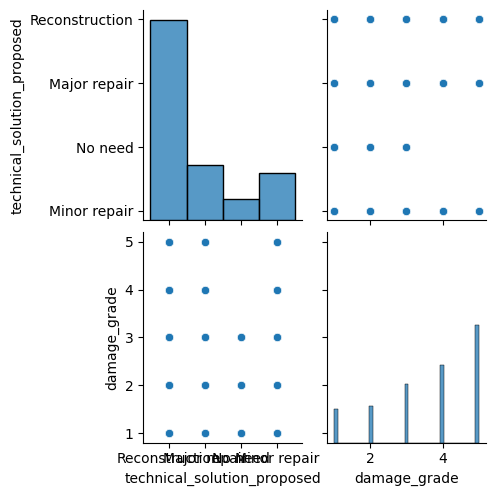

In [66]:
## Pairplot
plt.figure(figsize = (30, 8))
sns.pairplot(data = df_csv_1_cleaned, vars = ['technical_solution_proposed', 'damage_grade'])
plt.show()

Note that technical_solution_proposed is the only feature with the highest null value in the original dataset. Meaning we can add more of this to create a better model to predict damage_grade. One way is to create another model; to predict technical_solution_proposed.

# Creating Model to Predict 'technical_solution_proposed'

We will continue with the last preprocessed data, and do feature engineering next

In [68]:
## Looking once again at the preprocessed dataset
df_csv_1_preprocessed_3

floors_before_eq (total)  old_building  plinth_area (ft^2)  \
0                             1            22                 300   
1                             3            22                 360   
2                             2             8                 380   
3                             2            22                 250   
4                             2             7                 312   
...                         ...           ...                 ...   
46796                         2             8                 547   
46797                         1            24                 234   
46798                         2            10                 415   
46799                         3            85                 410   
46800                         3            15                 400   

       height_before_eq (ft) land_surface_condition  \
0                         10         Moderate slope   
1                         18                   Flat   
2                         17                   Flat   
3                         14                   Flat   
4                         13                   Flat   
...                      ...                    ...   
46796                     17                   Flat   
46797                     10                   Flat   
46798                     16                   Flat   
46799                     22                   Flat   
46800                     18                   Flat   

                type_of_foundation                   type_of_roof  \
0      Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
1      Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Heavy Roof   
2      Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
3      Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
4      Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
...                            ...                            ...   
46796  Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Heavy Roof   
46797  Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
46798  Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
46799  Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
46800  Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   

      type_of_ground_floor     type_of_other_floor         position  \
0                 Mud/Clay          Not applicable     Not attached   
1                 Mud/Clay  Timber/Wood/Bamboo Mud     Not attached   
2              Brick/Stone       Timber/Wood Plank     Not attached   
3                 Mud/Clay  Timber/Wood/Bamboo Mud     Not attached   
4                 Mud/Clay  Timber/Wood/Bamboo Mud     Not attached   
...                    ...                     ...              ...   
46796             Mud/Clay  Timber/Wood/Bamboo Mud  Attached-1 side   
46797             Mud/Clay          Not applicable     Not attached   
46798             Mud/Clay  Timber/Wood/Bamboo Mud     Not attached   
46799             Mud/Clay  Timber/Wood/Bamboo Mud     Not attached   
46800             Mud/Clay       Timber/Wood Plank  Attached-1 side   

      building_plan_configuration technical_solution_proposed  \
0                     Rectangular              Reconstruction   
1                     Rectangular              Reconstruction   
2                     Rectangular              Reconstruction   
3                     Rectangular              Reconstruction   
4                     Rectangular                Major repair   
...                           ...                         ...   
46796                 Rectangular              Reconstruction   
46797                 Rectangular              Reconstruction   
46798                 Rectangular              Reconstruction   
46799                 Rectangular              Reconstruction   
46800                 Rectangular              Reconstruction   

      type_of_reinforcement_concrete industrial_use_ty

In [79]:
df_csv_1_engineered = df_csv_1_preprocessed_3.copy()

## Data Resampling

Since the target we'll be dealing with is 'technical_solution_proposed', we should first undersample all the values since based on previous EDA, it shows that the values are not balanced.

In [80]:
## Overview of the value counts
df_csv_1_engineered['technical_solution_proposed'].value_counts()

Reconstruction    28847
Major repair       7963
Minor repair       6852
No need            3139
Name: technical_solution_proposed, dtype: int64

We will do undersampling, meaning each values will be resampled to exactly 3139.

In [81]:
temp = df_csv_1_engineered.copy()

count_1, count_2, count_3, count_4 = temp.technical_solution_proposed.value_counts()

temp_class_0 = temp[temp['technical_solution_proposed'] == 'No need']
temp_class_1 = temp[temp['technical_solution_proposed'] == 'Minor repair']
temp_class_2 = temp[temp['technical_solution_proposed'] == 'Major repair']
temp_class_3 = temp[temp['technical_solution_proposed'] == 'Reconstruction']

temp_class_3_under = temp_class_3.sample(count_4)
temp_class_2_under = temp_class_2.sample(count_4)
temp_class_1_under = temp_class_1.sample(count_4)

temp_under = pd.concat([temp_class_3_under, temp_class_2_under, temp_class_1_under, temp_class_0], axis=0)

In [82]:
temp_under = temp_under.reset_index()
temp_under = temp_under.drop(columns = 'index')
df_csv_1_engineered = temp_under

In [83]:
## Checking current size
df_csv_1_engineered

floors_before_eq (total)  old_building  plinth_area (ft^2)  \
0                             3             1                 405   
1                             3            13                 490   
2                             2            30                 225   
3                             3            13                 450   
4                             2            20                 160   
...                         ...           ...                 ...   
12551                         1             2                 900   
12552                         1             3                 180   
12553                         2             5                 754   
12554                         2             0                 203   
12555                         1             0                 560   

       height_before_eq (ft) land_surface_condition  \
0                         25                   Flat   
1                         18         Moderate slope   
2                         14                   Flat   
3                         21                   Flat   
4                         19                   Flat   
...                      ...                    ...   
12551                     10                   Flat   
12552                      8                   Flat   
12553                     20                   Flat   
12554                     14                   Flat   
12555                      8                   Flat   

                type_of_foundation                   type_of_roof  \
0      Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
1      Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
2      Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
3      Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
4      Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
...                            ...                            ...   
12551          Reinforced Concrete                     rcc/rb/rbc   
12552           Cement-Stone/Brick  Bamboo/Wood/Timber Light Roof   
12553          Reinforced Concrete                     rcc/rb/rbc   
12554                Bamboo/Timber  Bamboo/Wood/Timber Heavy Roof   
12555           Cement-Stone/Brick  Bamboo/Wood/Timber Light Roof   

      type_of_ground_floor     type_of_other_floor         position  \
0              Brick/Stone       Timber/Wood Plank  Attached-1 side   
1                 Mud/Clay  Timber/Wood/Bamboo Mud     Not attached   
2                 Mud/Clay  Timber/Wood/Bamboo Mud     Not attached   
3                 Mud/Clay  Timber/Wood/Bamboo Mud     Not attached   
4                 Mud/Clay  Timber/Wood/Bamboo Mud  Attached-1 side   
...                    ...                     ...              ...   
12551                   RC          Not applicable     Not attached   
12552                   RC          Not applicable     Not attached   
12553                   RC                      RC  Attached-2 side   
12554             Mud/Clay  Timber/Wood/Bamboo Mud     Not attached   
12555                   RC          Not applicable  Attached-1 side   

      building_plan_configuration technical_solution_proposed  \
0                     Rectangular              Reconstruction   
1                     Rectangular              Reconstruction   
2                     Rectangular              Reconstruction   
3                     Rectangular              Reconstruction   
4                     Rectangular              Reconstruction   
...                           ...                         ...   
12551                 Rectangular                     No need   
12552                 Rectangular                     No need   
12553                 Rectangular                     No need   
12554                 Rectangular                     No need   
12555                 Rectangular                     No need   

                  type_of_reinforcement_concrete indus

## Outlier Removal

Based on previous EDA, we found out that both plinth_area and old_building's distributions are not 'normal', since we can't just delete the rows containing the outliers (otherwise we would need to also remove ones in the test data, which we should avoid), we will normalize this by using scalers.

In [84]:
## 1st Scaler: RobustScaler(), used for dealing with outliers
robust_scaler = RobustScaler(quantile_range = (0, 0.8))
df_csv_1_engineered[['old_building', 'plinth_area (ft^2)']] = robust_scaler.fit_transform(df_csv_1_engineered[['old_building', 'plinth_area (ft^2)']])

In [85]:
## 2nd Scaler: StandardScaler() and MinMaxScaler(), applied on every numerical features
features_num = df_csv_1_engineered.drop(columns = 'damage_grade').select_dtypes(np.number).columns ## Listing all the numerical features
features_num

Index(['floors_before_eq (total)', 'old_building', 'plinth_area (ft^2)',
       'height_before_eq (ft)'],
      dtype='object')

In [86]:
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

df_csv_1_engineered[features_num] = standard_scaler.fit_transform(df_csv_1_engineered[features_num])
df_csv_1_engineered[features_num] = minmax_scaler.fit_transform(df_csv_1_engineered[features_num])

In [87]:
## Checking the data and its statistical description
display(df_csv_1_engineered.head())
display(df_csv_1_engineered[['floors_before_eq (total)', 'old_building', 'plinth_area (ft^2)', 'height_before_eq (ft)']].describe())

floors_before_eq (total)  old_building  plinth_area (ft^2)  \
0                  0.333333      0.001001            0.360215   
1                  0.333333      0.013013            0.451613   
2                  0.166667      0.030030            0.166667   
3                  0.333333      0.013013            0.408602   
4                  0.166667      0.020020            0.096774   

   height_before_eq (ft) land_surface_condition           type_of_foundation  \
0               0.204301                   Flat  Clay/Mud mortar-Stone/Brick   
1               0.129032         Moderate slope  Clay/Mud mortar-Stone/Brick   
2               0.086022                   Flat  Clay/Mud mortar-Stone/Brick   
3               0.161290                   Flat  Clay/Mud mortar-Stone/Brick   
4               0.139785                   Flat  Clay/Mud mortar-Stone/Brick   

                    type_of_roof type_of_ground_floor     type_of_other_floor  \
0  Bamboo/Wood/Timber Light Roof          Brick/Stone       Timber/Wood Plank   
1  Bamboo/Wood/Timber Light Roof             Mud/Clay  Timber/Wood/Bamboo Mud   
2  Bamboo/Wood/Timber Light Roof             Mud/Clay  Timber/Wood/Bamboo Mud   
3  Bamboo/Wood/Timber Light Roof             Mud/Clay  Timber/Wood/Bamboo Mud   
4  Bamboo/Wood/Timber Light Roof             Mud/Clay  Timber/Wood/Bamboo Mud   

          position building_plan_configuration technical_solution_proposed  \
0  Attached-1 side                 Rectangular              Reconstruction   
1     Not attached                 Rectangular              Reconstruction   
2     Not attached                 Rectangular              Reconstruction   
3     Not attached                 Rectangular              Reconstruction   
4  Attached-1 side                 Rectangular              Reconstruction   

  type_of_reinforcement_concrete industrial_use_type flexible_superstructure  \
0      No reinforcement concrete      Non-industrial             unavailable   
1      No reinforcement concrete                Food             unavailable   
2      No reinforcement concrete      Non-industrial             unavailable   
3      No reinforcement concrete      Non-industrial             unavailable   
4      No reinforcement concrete      Non-industrial             unavailable   

   wall_binding wall_material damage_grade  
0  Mud + Mortar  Stone Bricks          4.0  
1  Mud + Mortar  Stone Bricks          5.0  
2  Mud + Mortar  Stone Bricks          5.0  
3  Mud + Mortar  Stone Bricks          4.0  
4  Mud + Mortar  Stone Bricks          4.0

floors_before_eq (total)  old_building  plinth_area (ft^2)  \
count              12556.000000  12556.000000        12556.000000   
mean                   0.163653      0.021585            0.376606   
std                    0.118333      0.069653            0.223370   
min                    0.000000      0.000000            0.000000   
25%                    0.166667      0.006006            0.225806   
50%                    0.166667      0.013013            0.320430   
75%                    0.166667      0.022022            0.464516   
max                    1.000000      1.000000            1.000000   

       height_before_eq (ft)  
count           12556.000000  
mean                0.104906  
std                 0.065235  
min                 0.000000  
25%                 0.064516  
50%                 0.096774  
75%                 0.129032  
max                 1.000000

## One Hot Encoding

Next is one hot encoding, which we will apply to every categorical columns, except for the target.

In [88]:
## Renaming the categorical names, for better usage
df_csv_1_engineered_2 = df_csv_1_engineered.rename(columns = {
    'floors_before_eq (total)': 'floorsBeforeEq',
    'land_surface_condition': 'surfaceCondition',
    'type_of_foundation': 'foundation',
    'type_of_reinforcement_concrete': 'rcType',
    'type_of_roof': 'roof',
    'type_of_ground_floor': 'groundFloor',
    'type_of_other_floor': 'otherFloor',
    'industrial_use_type': 'useType',
    'building_plan_configuration': 'planConfiguration'
})

In [89]:
df_csv_1_engineered_2.dtypes

floorsBeforeEq                 float64
old_building                   float64
plinth_area (ft^2)             float64
height_before_eq (ft)          float64
surfaceCondition                object
foundation                      object
roof                            object
groundFloor                     object
otherFloor                      object
position                        object
planConfiguration               object
technical_solution_proposed     object
rcType                          object
useType                         object
flexible_superstructure         object
wall_binding                    object
wall_material                   object
damage_grade                    object
dtype: object

In [92]:
## Setting up categories that will be encoded
categories_1 = [
    ('surfaceCondition', df_csv_1_engineered_2['surfaceCondition'].unique()),
    ('foundation', df_csv_1_engineered_2['foundation'].unique()),
    ('roof', df_csv_1_engineered_2['roof'].unique()),
    ('groundFloor', df_csv_1_engineered_2['groundFloor'].unique()),
    ('otherFloor', df_csv_1_engineered_2['otherFloor'].unique()),
    ('position', df_csv_1_engineered_2['position'].unique()),
    ('planConfiguration', df_csv_1_engineered_2['planConfiguration'].unique()),
    ('rcType', df_csv_1_engineered_2['rcType'].unique()),
    ('useType', df_csv_1_engineered_2['useType'].unique()),
    ('flexible_superstructure', df_csv_1_engineered_2['flexible_superstructure'].unique()),
    ('wall_binding', df_csv_1_engineered_2['wall_binding'].unique()),
    ('wall_material', df_csv_1_engineered_2['wall_material'].unique()),
    ('damage_grade', df_csv_1_engineered_2['damage_grade'].unique()) #
]

In [94]:
## Setting up one hot encoder for training set
df_csv_1_engineered_3 = df_csv_1_engineered_2.copy()

ohe_columns_1 = [x[0] for x in categories_1]
ohe_categories_1 = [x[1] for x in categories_1]
enc_1 = OneHotEncoder(sparse_output = False, categories = ohe_categories_1)

temp = df_csv_1_engineered_3['technical_solution_proposed']

df_csv_1_engineered_3 = pd.DataFrame(
    enc_1.fit_transform(df_csv_1_engineered_2[ohe_columns_1]),
    columns = enc_1.get_feature_names_out(),
    index = df_csv_1_engineered_2.index
)

df_csv_1_engineered_3 = pd.concat([df_csv_1_engineered_2.drop(ohe_columns_1, axis = 1), df_csv_1_engineered_3], axis = 1)
df_csv_1_engineered_3['technical_solution_proposed'] = temp

In [95]:
df_csv_1_engineered_3.columns

Index(['floorsBeforeEq', 'old_building', 'plinth_area (ft^2)',
       'height_before_eq (ft)', 'technical_solution_proposed',
       'surfaceCondition_Flat', 'surfaceCondition_Moderate slope',
       'surfaceCondition_Steep slope',
       'foundation_Clay/Mud mortar-Stone/Brick', 'foundation_Bamboo/Timber',
       'foundation_Cement-Stone/Brick', 'foundation_Others',
       'foundation_Reinforced Concrete', 'roof_Bamboo/Wood/Timber Light Roof',
       'roof_Bamboo/Wood/Timber Heavy Roof', 'roof_rcc/rb/rbc',
       'groundFloor_Brick/Stone', 'groundFloor_Mud/Clay',
       'groundFloor_Wood/Timber', 'groundFloor_Mud', 'groundFloor_Other',
       'groundFloor_RC', 'otherFloor_Timber/Wood Plank',
       'otherFloor_Timber/Wood/Bamboo Mud', 'otherFloor_Not applicable',
       'otherFloor_RC', 'position_Attached-1 side', 'position_Not attached',
       'position_Attached-2 side', 'position_Attached-3 side',
       'planConfiguration_Rectangular', 'planConfiguration_Square',
       'planConfi

## Modeling

In [101]:
df_csv_1_final = df_csv_1_engineered_3.copy()

Model we will be using: XGBoost

In [102]:
## Checking value_counts, to ensure balanceness
df_csv_1_final['technical_solution_proposed'].value_counts()

Reconstruction    3139
Major repair      3139
Minor repair      3139
No need           3139
Name: technical_solution_proposed, dtype: int64

In [103]:
## Extract and Encode Label
label_ts = df_csv_1_final[['technical_solution_proposed']]
df_csv_1_final = df_csv_1_final.drop(columns = 'technical_solution_proposed')

label_encoder = LabelEncoder()
label_ts = label_encoder.fit_transform(label_ts)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
## Train test split
X_1_train, X_1_val, y_1_train, y_1_val = train_test_split(df_csv_1_final, label_ts, random_state = 42, test_size = 0.2)

In [ ]:
# Setting the basic classifier
xgb_cl_ts = XGBClassifier(tree_method = 'gpu_hist')

In [ ]:
## KFold Cross Validation
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

cv_scores = cross_val_score(xgb_cl_ts, X_1_train, y_1_train, cv = kf, scoring = 'f1_macro')
print(cv_scores)

[0.83109896 0.83566334 0.82402602 0.83174587 0.82312619]


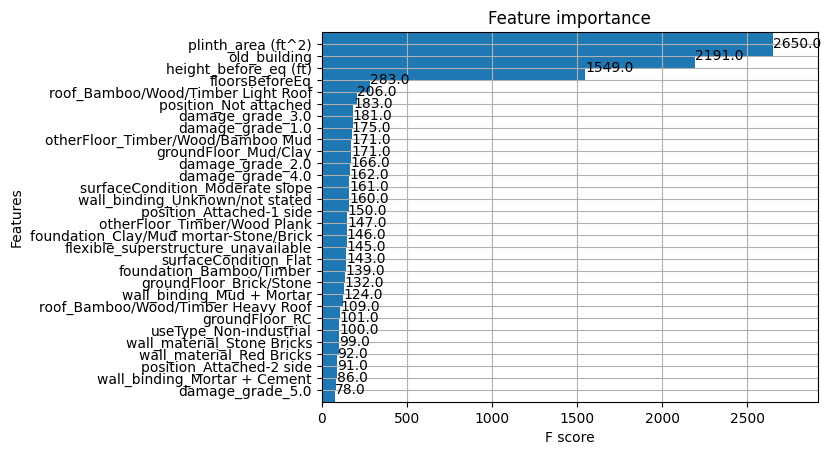

In [ ]:
xgb_cl_ts.fit(X_1_train, y_1_train)
_ = plot_importance(xgb_cl_ts, height = 2.0, max_num_features = 30)

In [ ]:
probs_ts = xgb_cl_ts.predict(X_1_val)

print("Untuned XGB classifier F1 Score: " + str(f1_score(y_1_val, probs_ts, average = 'macro')))

Untuned XGB classifier F1 Score: 0.8355550642099675


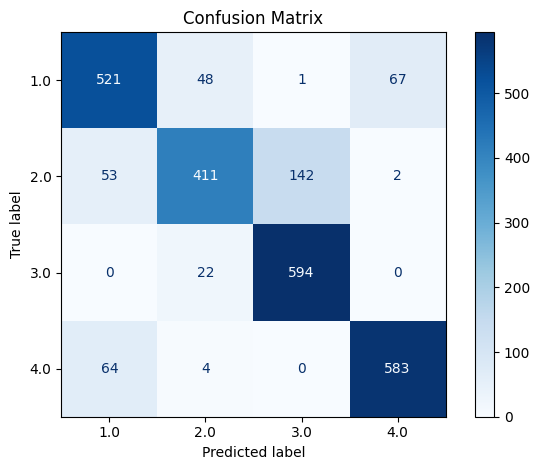

In [ ]:
## Plotting the confusion matrix
plt.style.use('default')
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_1_val, probs_ts), display_labels = ['1.0', '2.0', '3.0', '4.0'])
disp.plot(cmap = 'Blues', values_format = '')

plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Using the Model to Predict the Rest of the Data

Since the model is trained on about 12k data, we will use this to predict the rest of the non-null dataset

### Data Cleaning - 2 - Dealing with New Data

Since now the column we're predicting is technical_solution_proposed, we will delete this first instead

In [ ]:
## Deleting Columns that Wont be Used (Possibly Unrelated or Too Many Null)
columns_to_drop = [
    'govermental_use_type', 'public_place_type', 
    'no_family_residing', 'residential_type', 'has_secondary_use', 
    'legal_ownership_status', 'technical_solution_proposed'
]

In [ ]:
df_csv_2_cleaning = df_csv.copy()

df_csv_2_cleaning = df_csv_2_cleaning.drop(columns = columns_to_drop)

In [ ]:
## Checking total dropped columns on train set

df_csv_2_cleaning.isna().sum()

floors_before_eq (total)          166403
old_building                      119602
plinth_area (ft^2)                218404
height_before_eq (ft)             166403
land_surface_condition            150803
type_of_foundation                119602
type_of_roof                      218404
type_of_ground_floor              166403
type_of_other_floor               150803
position                          156003
building_plan_configuration       150803
type_of_reinforcement_concrete    145603
industrial_use_type                57201
flexible_superstructure            31200
wall_binding                       31200
wall_material                     114402
damage_grade                           0
dtype: int64

In [ ]:
## Dropping the null rows
df_csv_2_cleaning_2 = df_csv_2_cleaning.dropna()
df_csv_2_cleaning_2 = df_csv_2_cleaning_2.reset_index()
df_csv_2_cleaning_2 = df_csv_2_cleaning_2.drop(columns = ['index'])

In [ ]:
df_csv_2_cleaning_2

floors_before_eq (total)  old_building plinth_area (ft^2)  \
0                     floor two           1.0           256 ft^2   
1                       Floor 3           3.0           985 ft^2   
2                           two          18.0           185 ft^2   
3                  just 2 floor          22.0           290 ft^2   
4        There is 2 Floor/Story          40.0           504 ft^2   
...                         ...           ...                ...   
301602                  Floor 1          30.0           276 ft^2   
301603   There is 2 Floor/Story           8.0           432 ft^2   
301604                  2 floor          26.0           392 ft^2   
301605                        2          17.0           300 ft^2   
301606                  Floor 2           5.0           300 ft^2   

        height_before_eq (ft) land_surface_condition  \
0                        22.0                   Flat   
1                        18.0                   Flat   
2                        15.0                   Flat   
3                        17.0                   Flat   
4                        14.0                   Flat   
...                       ...                    ...   
301602                    9.0         Moderate slope   
301603                   14.0                   Flat   
301604                   19.0                   Flat   
301605                   16.0                   Flat   
301606                   14.0                   Flat   

                        type_of_foundation  \
0                         Bamboo or Timber   
1       Clay Sand Mixed mortar-Stone/Brick   
2       Clay Sand Mixed mortar-Stone/Brick   
3       Clay Sand Mixed mortar-Stone/Brick   
4                  Clay mortar-Stone/Brick   
...                                    ...   
301602  Clay Sand Mixed mortar-Stone/Brick   
301603                       Bamboo/Timber   
301604  Clay Sand Mixed mortar-Stone/Brick   
301605             Clay mortar-Stone/Brick   
301606                    Bamboo or Timber   

                                type_of_roof type_of_ground_floor  \
0                   Bamboo/Timber Light roof                 Clay   
1       Wood Light Roof or Bamboo Heavy Roof                 Clay   
2       Wood Light Roof or Bamboo Light Roof                 Clay   
3                Bamboo or Timber Light roof                 Clay   
4                   Bamboo/Timber Light roof                 Clay   
...                                      ...                  ...   
301602  Wood Light Roof or Bamboo Light Roof                 Clay   
301603  Wood Light Roof or Bamboo Heavy Roof                 Clay   
301604              Bamboo/TImber-Light Roof                 Clay   
301605  Wood Light Roof or Bamboo Light Roof                 Clay   
301606              Bamboo/Timber Light roof                  mud   

             type_of_other_floor      position building_plan_configuration  \
0              TImber/Bamboo-Mud  Not attached                 Rectangular   
1              TImber/Bamboo-Mud  Not attached                      Square   
2              TImber/Bamboo-Mud  Not attached                 Rectangular   
3       Timber Mud or Bamboo-Mud  Not attached                 Rectangular   
4              TImber/Bamboo-Mud  Not attached                 Rectangular   
...                          ...           ...                         ...   
301602            Not applicable  Not attached                 Rectangular   
301603                Wood-Plank  Not attached                 Rectangular   
301604         TImber/Bamboo-Mud  Not attached                 Rectangular   
301605    Wood-Mud or Bamboo Mud  Not attached                 Rectangular   
301606         TImber/Bamboo-Mud  Not attached                 Rectangular   

        type_of_reinforcement_concrete industrial_use_type  \
0                                  0.0      Non-industrial   
1                                  0.0      Non-industrial   
2           

Resample, but now based on the damage_grade feature. This is so that not only benefit the next model (to predict damage_grade), but also the distribution of the technical_solution_proposed feature values.

In [ ]:
temp = df_csv_2_cleaning_2.copy()

count_1, count_2, count_3, count_4, count_5 = temp.damage_grade.value_counts()

temp_class_0 = temp[temp['damage_grade'] == 1.0]
temp_class_1 = temp[temp['damage_grade'] == 2.0]
temp_class_2 = temp[temp['damage_grade'] == 3.0]
temp_class_3 = temp[temp['damage_grade'] == 4.0]
temp_class_4 = temp[temp['damage_grade'] == 5.0]

temp_class_4_under = temp_class_4.sample(count_5, random_state = 42)
temp_class_3_under = temp_class_3.sample(count_5, random_state = 42)
temp_class_2_under = temp_class_2.sample(count_5, random_state = 42)
temp_class_1_under = temp_class_1.sample(count_5, random_state = 42)

temp_under = pd.concat([temp_class_4_under, temp_class_3_under, temp_class_2_under, temp_class_1_under, temp_class_0], axis=0)

In [ ]:
temp_under = temp_under.reset_index()
temp_under = temp_under.drop(columns = 'index')
df_csv_2_cleaning_2 = temp_under

### Data Preprocessing - 2

In [ ]:
df_csv_2_preprocessed = df_csv_2_cleaning_2.copy()

#### Working with Numerical Features

In [ ]:
def floors_before_eq(df_csv):
  replace_dict = {'floor two': 2, 'Floor 3': 3, 'Two Floor': 2, 'two': 2, ' just 2 floor': 2,
                  'There is 2 Floor/Story': 2, 'Floor two': 2, '1st Story': 1, 'Floor 2': 2,
                  'fifth': 5, 'Three floor': 3, 'floor one': 1, '2': 2, 'Has 1 floor': 1,
                  'one story': 1, 'two story': 2, 'floor second': 2, 'floor third': 3, 
                  '3.00': 3, '1': 1, ' has 3 Floor': 3, '2 floor': 2, 'three Story': 3,
                  'Floor 1': 1, 'floor 1st': 1, 'one': 1, 'Just 1 floor': 1, 'Floor-three': 3,
                  'Three': 3, 'four floor': 4, 'Four Story': 4, 'Four': 4, 'Floor Fifth': 5,
                  'five Floor': 5, ' Has Five fl': 5, '8': 8, '9': 9, '7': 7, 'Has Five fl': 5,
                  'four Floor': 4, ' has Four fl': 4, 'Fl four': 4, 'Fl Five': 5, 'Floor 4': 4,
                  'floor four': 4, '6': 6, '5': 5, '4': 4}
  df_csv['floors_before_eq (total)'] = df_csv['floors_before_eq (total)'].replace(replace_dict)

  return df_csv

df_csv_2_preprocessed = floors_before_eq(df_csv_2_preprocessed)

In [ ]:
## Plinth Area
df_csv_2_preprocessed_2 = df_csv_2_preprocessed.copy()
df_csv_2_preprocessed_2['plinth_area (ft^2)'] = df_csv_2_preprocessed_2['plinth_area (ft^2)'].astype('string')

def plinth_area(df):
  ## Dealing with the first part
  df['plinth_area (ft^2)'] = df['plinth_area (ft^2)'].replace({'More than 1000 ft^2': 1000})
  ## Dealing with the rest
  for i in range(0, len(df)):
      if df['plinth_area (ft^2)'][i] == 1000:
          pass
      else:
          df['plinth_area (ft^2)'][i] = df['plinth_area (ft^2)'][i][0:3]
  return df

df_csv_2_preprocessed_2 = plinth_area(df_csv_2_preprocessed_2)

<ipython-input-509-899b561534ea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['plinth_area (ft^2)'][i] = df['plinth_area (ft^2)'][i][0:3]
<ipython-input-509-899b561534ea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['plinth_area (ft^2)'][i] = 1000


#### Working with Categorical Features

In [ ]:
## Grouping Categorical Features 1: Types of Foundation, Roof, and Floors

def categorical_grouping(df):
    ## Type of Foundation
    replace_dict_1 = {
        'Bamboo/TImber': 'Bamboo/Timber', 
        'Bamboo or Timber': 'Bamboo/Timber',
        'RC': 'Reinforced Concrete',
        'Cement-Stone or Cement-Brick': 'Cement-Stone/Brick',
        'Clay Sand Mixed mortar-Stone/Brick': 'Clay/Mud mortar-Stone/Brick',
        'Clay mortar-Stone/Brick': 'Clay/Mud mortar-Stone/Brick',
        'Mud mortar-Stone/Brick': 'Clay/Mud mortar-Stone/Brick',
        'Other': 'Others'
    }

    replace_dict_2 = {
        'Bamboo/Timber Light roof': 'Bamboo/Wood/Timber Light Roof', 
        'Bamboo/TImber-Light Roof': 'Bamboo/Wood/Timber Light Roof',
        'Bamboo or Timber Light roof': 'Bamboo/Wood/Timber Light Roof',
        'Bamboo/Timber Heavy roof': 'Bamboo/Wood/Timber Heavy Roof',
        'Bamboo/TImber-Heavy Roof': 'Bamboo/Wood/Timber Heavy Roof',
        'Bamboo or Timber Heavy roof': 'Bamboo/Wood/Timber Heavy Roof',
        'reinforced cement concrete/rb/rbc': 'rcc/rb/rbc',
        'Wood Light Roof or Bamboo Heavy Roof': 'Bamboo/Wood/Timber Heavy Roof',
        'Wood Light Roof or Bamboo Light Roof': 'Bamboo/Wood/Timber Light Roof',
        'Reinforced Brick Slab/rcc/rbc': 'rcc/rb/rbc',
        'Reinforced brick concrete/rcc/rbc': 'rcc/rb/rbc'
    }

    replace_dict_3 = {
        'Brick or Stone': 'Brick/Stone',
        'Clay': 'Mud/Clay',
        'brick/stone': 'Brick/Stone',
        'Brick/Stone': 'Brick/Stone',
        'TImber': 'Wood/Timber',
        'Timber': 'Wood/Timber',
        'Lumber': 'Wood/Timber',
        'Wood': 'Wood/Timber',
        'mud': 'Mud/Clay',
        'reinforced concrete': 'RC',
        'Reinforced Concrete': 'RC',
        'soil, water, loam Mixed': 'Other'
    }

    replace_dict_4 = {
        'reinforced cement concrete/rb/rbc': 'RC',
        'Reinforced brick concrete/rcc/rbc': 'RC',
        'rcc/rb/rbc': 'RC',
        'TImber/Bamboo-Mud': 'Timber/Wood/Bamboo Mud',
        'Wood or Bamboo Mud': 'Timber/Wood/Bamboo Mud',
        'Timber Mud or Bamboo-Mud': 'Timber/Wood/Bamboo Mud',
        'Wood-Mud or Bamboo Mud': 'Timber/Wood/Bamboo Mud',
        'Timber-Planck': 'Timber/Wood Plank',
        'Lumber-plank': 'Timber/Wood Plank',
        'Wood-Plank': 'Timber/Wood Plank'
    }

    replace_dict_5 = {
        0.0: 'No reinforcement concrete',
        1.0: 'Has non-engineered reinforcement concrete',
        2.0: 'Has engineered reinforcement concrete',
        3.0: 'Has both',
    }

    replace_dict_6 = {
        0.0: 'Unknown/not stated',
        1.0: 'Clay',
        2.0: 'Mortar + Cement',
        3.0: 'Mortar + Cement',
        5.0: 'Mud + Mortar',
        7.0: 'Mud + Mortar'
    }

    replace_dict_7 = {
        0.0: 'Unknown/not stated',
        1.0: 'Red Bricks',
        2.0: 'Stone Bricks',
        3.0: 'Red Bricks, Stone Bricks',
    }

    df['type_of_foundation'] = df['type_of_foundation'].replace(replace_dict_1)
    df['type_of_roof'] = df['type_of_roof'].replace(replace_dict_2)
    df['type_of_ground_floor'] = df['type_of_ground_floor'].replace(replace_dict_3)
    df['type_of_other_floor'] = df['type_of_other_floor'].replace(replace_dict_4)
    df['type_of_reinforcement_concrete'] = df['type_of_reinforcement_concrete'].replace(replace_dict_5)
    df['wall_binding'] = df['wall_binding'].replace(replace_dict_6)
    df['wall_material'] = df['wall_material'].replace(replace_dict_7)

    return df

df_csv_2_preprocessed_3 = categorical_grouping(df_csv_2_preprocessed_2)

#### Correcting the Data Type

In [ ]:
df_csv_2_preprocessed_3.dtypes

floors_before_eq (total)            int64
old_building                      float64
plinth_area (ft^2)                 object
height_before_eq (ft)             float64
land_surface_condition             object
type_of_foundation                 object
type_of_roof                       object
type_of_ground_floor               object
type_of_other_floor                object
position                           object
building_plan_configuration        object
type_of_reinforcement_concrete     object
industrial_use_type                object
flexible_superstructure            object
wall_binding                       object
wall_material                      object
damage_grade                      float64
dtype: object

In [ ]:
## Change type to the Correct One
df_csv_2_preprocessed_4 = df_csv_2_preprocessed_3.copy()

In [ ]:
df_csv_2_preprocessed_4 = df_csv_2_preprocessed_4.astype(
    {
        'floors_before_eq (total)': 'int64',
        'old_building': 'int64',
        'plinth_area (ft^2)': 'int64',
        'height_before_eq (ft)': 'int64',
        'damage_grade': 'object',
    }
)

In [ ]:
df_csv_2_preprocessed_4.dtypes

floors_before_eq (total)           int64
old_building                       int64
plinth_area (ft^2)                 int64
height_before_eq (ft)              int64
land_surface_condition            object
type_of_foundation                object
type_of_roof                      object
type_of_ground_floor              object
type_of_other_floor               object
position                          object
building_plan_configuration       object
type_of_reinforcement_concrete    object
industrial_use_type               object
flexible_superstructure           object
wall_binding                      object
wall_material                     object
damage_grade                      object
dtype: object

### Feature Engineering - 2

In [ ]:
df_csv_2_engineered = df_csv_2_preprocessed_4.copy()

#### Outlier Removal

Pretty much the same as in before

In [ ]:
## RobustScaler()
robust_scaler = RobustScaler(quantile_range = (0, 0.8))
df_csv_2_engineered[['old_building', 'plinth_area (ft^2)']] = robust_scaler.fit_transform(df_csv_2_engineered[['old_building', 'plinth_area (ft^2)']])

In [ ]:
## 2nd Scaler: StandardScaler() and MinMaxScaler(), applied on every numerical features
features_num = df_csv_1_engineered.drop(columns = 'damage_grade').select_dtypes(np.number).columns ## Listing all the numerical features
features_num

Index(['floors_before_eq (total)', 'old_building', 'plinth_area (ft^2)',
       'height_before_eq (ft)'],
      dtype='object')

In [ ]:
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

df_csv_2_engineered[features_num] = standard_scaler.fit_transform(df_csv_2_engineered[features_num])
df_csv_2_engineered[features_num] = minmax_scaler.fit_transform(df_csv_2_engineered[features_num])

In [ ]:
df_csv_2_engineered.head()

floors_before_eq (total)  old_building  plinth_area (ft^2)  \
0                     0.125      0.001001            0.456989   
1                     0.250      0.023023            0.444086   
2                     0.375      0.020020            0.272043   
3                     0.125      0.022022            0.311828   
4                     0.125      0.007007            0.295699   

   height_before_eq (ft) land_surface_condition           type_of_foundation  \
0               0.064516                   Flat  Clay/Mud mortar-Stone/Brick   
1               0.225806         Moderate slope  Clay/Mud mortar-Stone/Brick   
2               0.172043                   Flat  Clay/Mud mortar-Stone/Brick   
3               0.064516                   Flat  Clay/Mud mortar-Stone/Brick   
4               0.129032                   Flat  Clay/Mud mortar-Stone/Brick   

                    type_of_roof type_of_ground_floor     type_of_other_floor  \
0  Bamboo/Wood/Timber Heavy Roof             Mud/Clay  Timber/Wood/Bamboo Mud   
1  Bamboo/Wood/Timber Light Roof             Mud/Clay  Timber/Wood/Bamboo Mud   
2  Bamboo/Wood/Timber Heavy Roof             Mud/Clay       Timber/Wood Plank   
3  Bamboo/Wood/Timber Light Roof             Mud/Clay  Timber/Wood/Bamboo Mud   
4  Bamboo/Wood/Timber Heavy Roof             Mud/Clay  Timber/Wood/Bamboo Mud   

          position building_plan_configuration type_of_reinforcement_concrete  \
0     Not attached                 Rectangular      No reinforcement concrete   
1     Not attached                 Rectangular      No reinforcement concrete   
2  Attached-1 side                 Rectangular      No reinforcement concrete   
3     Not attached                 Rectangular      No reinforcement concrete   
4  Attached-1 side                 Rectangular      No reinforcement concrete   

  industrial_use_type flexible_superstructure  wall_binding wall_material  \
0      Non-industrial             unavailable  Mud + Mortar  Stone Bricks   
1      Non-industrial             unavailable  Mud + Mortar  Stone Bricks   
2      Non-industrial             unavailable  Mud + Mortar  Stone Bricks   
3      Non-industrial             unavailable  Mud + Mortar  Stone Bricks   
4      Non-industrial             unavailable  Mud + Mortar  Stone Bricks   

  damage_grade  
0          5.0  
1          5.0  
2          5.0  
3          5.0  
4          5.0

In [ ]:
df_csv_2_engineered[['floors_before_eq (total)', 'old_building', 'plinth_area (ft^2)', 'height_before_eq (ft)']].describe()

floors_before_eq (total)   old_building  plinth_area (ft^2)  \
count             156685.000000  156685.000000       156685.000000   
mean                   0.128310       0.022484            0.366164   
std                    0.085712       0.064860            0.211898   
min                    0.000000       0.000000            0.000000   
25%                    0.125000       0.007007            0.225806   
50%                    0.125000       0.015015            0.311828   
75%                    0.125000       0.025025            0.456989   
max                    1.000000       1.000000            1.000000   

       height_before_eq (ft)  
count          156685.000000  
mean                0.106352  
std                 0.062845  
min                 0.000000  
25%                 0.064516  
50%                 0.096774  
75%                 0.129032  
max                 1.000000

#### One Hot Encoding

In [ ]:
## Renaming the categorical names, for better usage
df_csv_2_engineered_2 = df_csv_2_engineered.rename(columns = {
    'floors_before_eq (total)': 'floorsBeforeEq',
    'land_surface_condition': 'surfaceCondition',
    'type_of_foundation': 'foundation',
    'type_of_reinforcement_concrete': 'rcType',
    'type_of_roof': 'roof',
    'type_of_ground_floor': 'groundFloor',
    'type_of_other_floor': 'otherFloor',
    'industrial_use_type': 'useType',
    'building_plan_configuration': 'planConfiguration'
})

In [ ]:
df_csv_2_engineered_2.dtypes

floorsBeforeEq             float64
old_building               float64
plinth_area (ft^2)         float64
height_before_eq (ft)      float64
surfaceCondition            object
foundation                  object
roof                        object
groundFloor                 object
otherFloor                  object
position                    object
planConfiguration           object
rcType                      object
useType                     object
flexible_superstructure     object
wall_binding                object
wall_material               object
damage_grade                object
dtype: object

In [ ]:
categories = [
    ('surfaceCondition', train_3_csv_preprocessed_cleaned_2['surfaceCondition'].unique()),
    ('foundation', train_3_csv_preprocessed_cleaned_2['foundation'].unique()),
    ('roof', train_3_csv_preprocessed_cleaned_2['roof'].unique()),
    ('groundFloor', train_3_csv_preprocessed_cleaned_2['groundFloor'].unique()),
    ('otherFloor', train_3_csv_preprocessed_cleaned_2['otherFloor'].unique()),
    ('position', train_3_csv_preprocessed_cleaned_2['position'].unique()),
    ('planConfiguration', train_3_csv_preprocessed_cleaned_2['planConfiguration'].unique()),
    ('rcType', train_3_csv_preprocessed_cleaned_2['rcType'].unique()),
    ('useType', train_3_csv_preprocessed_cleaned_2['useType'].unique()),
    ('flexible_superstructure', train_3_csv_preprocessed_cleaned_2['flexible_superstructure'].unique()),
    ('wall_binding', train_3_csv_preprocessed_cleaned_2['wall_binding'].unique()),
    ('wall_material', train_3_csv_preprocessed_cleaned_2['wall_material'].unique()),
    ('damage_grade', train_3_csv_preprocessed_cleaned_2['damage_grade'].unique())
]

In [ ]:
df_csv_2_engineered_2['damage_grade'] = df_csv_2_engineered_2['damage_grade'].astype('object')

In [ ]:
## Setting up one hot encoder for training set
df_csv_2_engineered_3 = df_csv_2_engineered_2.copy()

ohe_columns_1 = [x[0] for x in categories_1]
ohe_categories_1 = [x[1] for x in categories_1]
enc_1 = OneHotEncoder(sparse_output = False, categories = ohe_categories_1)

df_csv_2_engineered_3 = pd.DataFrame(
    enc_1.fit_transform(df_csv_2_engineered_2[ohe_columns_1]),
    columns = enc_1.get_feature_names_out(),
    index = df_csv_2_engineered_2.index
)

df_csv_2_engineered_3 = pd.concat([df_csv_2_engineered_2.drop(ohe_columns_1, axis = 1), df_csv_2_engineered_3], axis = 1)

In [ ]:
df_csv_2_engineered_3

floorsBeforeEq  old_building  plinth_area (ft^2)  \
0                0.125      0.001001            0.456989   
1                0.250      0.023023            0.444086   
2                0.375      0.020020            0.272043   
3                0.125      0.022022            0.311828   
4                0.125      0.007007            0.295699   
...                ...           ...                 ...   
156680           0.000      0.010010            0.204301   
156681           0.125      0.008008            0.086022   
156682           0.000      0.001001            1.000000   
156683           0.000      0.010010            0.208602   
156684           0.125      0.005005            0.247312   

        height_before_eq (ft)  surfaceCondition_Flat  \
0                    0.064516                    1.0   
1                    0.225806                    0.0   
2                    0.172043                    1.0   
3                    0.064516                    1.0   
4                    0.129032                    1.0   
...                       ...                    ...   
156680               0.021505                    1.0   
156681               0.064516                    1.0   
156682               0.032258                    1.0   
156683               0.000000                    0.0   
156684               0.086022                    1.0   

        surfaceCondition_Moderate slope  surfaceCondition_Steep slope  \
0                                   0.0                           0.0   
1                                   1.0                           0.0   
2                                   0.0                           0.0   
3                                   0.0                           0.0   
4                                   0.0                           0.0   
...                                 ...                           ...   
156680                              0.0                           0.0   
156681                              0.0                           0.0   
156682                              0.0                           0.0   
156683                              1.0                           0.0   
156684                              0.0                           0.0   

        foundation_Clay/Mud mortar-Stone/Brick  foundation_Cement-Stone/Brick  \
0                                          1.0                            0.0   
1                                          1.0                            0.0   
2                                          1.0                            0.0   
3                                          1.0                            0.0   
4                                          1.0                            0.0   
...                                        ...                            ...   
156680                                     0.0                            0.0   
156681                                     0.0                            0.0   
156682                                     0.0                            0.0   
156683                                     1.0                            0.0   
156684                                     0.0                            0.0   

        foundation_Others  ...  wall_binding_Clay  wall_material_Stone Bricks  \
0                     0.0  ...                0.0                         1.0   
1                     0.0  ...                0.0                         1.0   
2                     0.0  ...                0.0                         1.0   
3                     0.0  ...                0.0                         1.0   
4                     0.0  ...                0.0                         1.0   
...                   ...  ...                ...                         ...   
156680                0.0  ...                0.0                         0.0   
156681                0.0  ...                0.0                         0.0   
156682                0.0  ...     

### Predicting the Data

We will use previous training data used to create the technical solution proposed model to reorder the dataset's column

In [ ]:
## Remember df_csv_1_final is the finalized dataset used for train_test_split for the technical_solution_proposed model
column_order = df_csv_1_final.columns.tolist()

In [ ]:
## Reindex the column
df_csv_2_engineered_4 = df_csv_2_engineered_3.reindex(columns = column_order)

In [ ]:
probs_ts_2 = xgb_cl_ts.predict(df_csv_2_engineered_4)

In [ ]:
df_csv_2_engineered_4['technical_solution_proposed'] = probs_ts_2

In [ ]:
df_csv_2_engineered_4['technical_solution_proposed'].value_counts()

3    58560
0    35551
1    32941
2    29633
Name: technical_solution_proposed, dtype: int64

Save the dataset which contains the predicted technical solution proposed

In [ ]:
df_csv_2_engineered_4[['technical_solution_proposed']].to_csv('technical_solution_proposed_3.csv')

# Data Overview - 2

Next step is to use the predicted dataset and combine them with original dataset (by merging and deleting duplicated rows)

In [179]:
## Exporting created dataset
technical_solution = pd.read_csv('/content/drive/MyDrive/Joints/technical_solution_proposed_3.csv', index_col = 0)

Both df_csv and test_csv used are still the same as in the beginning steps

In [180]:
## Selecting up to the latest unique column only
df_csv = df_csv[:520011]

# Data Cleaning - 2


We will now include the test dataset to be cleaned, preprocessed, and engineered.

In [181]:
## Deleting Columns that Wont be Used (Possibly Unrelated or Too Many Null)
columns_to_drop_1 = [
    'govermental_use_type', 'public_place_type', 
    'no_family_residing', 'residential_type', 'has_secondary_use', 
    'legal_ownership_status'
]

columns_to_drop_2 = [
    'govermental_use_type', 'public_place_type', 
    'no_family_residing', 'residential_type', 'has_secondary_use', 
    'legal_ownership_status', 'technical_solution_proposed'
]

We will differentiate df_csv_3_cleaning and df_csv_4_cleaning, where df_csv_3_cleaning will be filled with the original dataset, while df_csv_4_cleaning will be filled with the created dataset instead

In [182]:
df_csv_3_cleaning = df_csv.copy()
df_csv_3_cleaning = df_csv_3_cleaning.drop(columns = columns_to_drop_1)

test_csv_preprocessed = test_csv.copy()
test_csv_preprocessed = test_csv_preprocessed.drop(columns = columns_to_drop_1)

df_csv_4_cleaning = df_csv.copy()
df_csv_4_cleaning = df_csv_4_cleaning.drop(columns = columns_to_drop_2)

In [183]:
## Checking total dropped columns on train set
df_csv_3_cleaning.isna().sum()

floors_before_eq (total)          166403
old_building                      119602
plinth_area (ft^2)                218404
height_before_eq (ft)             166403
land_surface_condition            150803
type_of_foundation                119602
type_of_roof                      218404
type_of_ground_floor              166403
type_of_other_floor               150803
position                          156003
building_plan_configuration       150803
technical_solution_proposed       473210
type_of_reinforcement_concrete    145603
industrial_use_type                57201
flexible_superstructure            31200
wall_binding                       31200
wall_material                     114402
damage_grade                           0
dtype: int64

In [184]:
## Dropping the null rows
df_csv_3_cleaning_2 = df_csv_3_cleaning.dropna()

In [185]:
df_csv_3_cleaning_2

floors_before_eq (total)  old_building plinth_area (ft^2)  \
21                  Has 1 floor          22.0           300 ft^2   
27                  Three floor          22.0           360 ft^2   
43                      Floor 2           8.0           380 ft^2   
46                          two          22.0           250 ft^2   
92                    Floor two           7.0           312 ft^2   
...                         ...           ...                ...   
519918                        2           8.0           547 ft^2   
519956                floor one          24.0           234 ft^2   
519969                Floor two          10.0           415 ft^2   
519980                     3.00          85.0           410 ft^2   
519995              three Story          15.0           400 ft^2   

        height_before_eq (ft) land_surface_condition  \
21                       10.0         Moderate slope   
27                       18.0                   Flat   
43                       17.0                   Flat   
46                       14.0                   Flat   
92                       13.0                   Flat   
...                       ...                    ...   
519918                   17.0                   Flat   
519956                   10.0                   Flat   
519969                   16.0                   Flat   
519980                   22.0                   Flat   
519995                   18.0                   Flat   

                        type_of_foundation  \
21      Clay Sand Mixed mortar-Stone/Brick   
27                 Clay mortar-Stone/Brick   
43                 Clay mortar-Stone/Brick   
46                 Clay mortar-Stone/Brick   
92      Clay Sand Mixed mortar-Stone/Brick   
...                                    ...   
519918  Clay Sand Mixed mortar-Stone/Brick   
519956             Clay mortar-Stone/Brick   
519969             Clay mortar-Stone/Brick   
519980             Clay mortar-Stone/Brick   
519995  Clay Sand Mixed mortar-Stone/Brick   

                                type_of_roof type_of_ground_floor  \
21                  Bamboo/Timber Light roof                  mud   
27      Wood Light Roof or Bamboo Heavy Roof                 Clay   
43      Wood Light Roof or Bamboo Light Roof       Brick or Stone   
46                  Bamboo/Timber Light roof                 Clay   
92               Bamboo or Timber Light roof                 Clay   
...                                      ...                  ...   
519918           Bamboo or Timber Heavy roof                 Clay   
519956           Bamboo or Timber Light roof                 Clay   
519969              Bamboo/Timber Light roof                 Clay   
519980              Bamboo/Timber Light roof                 Clay   
519995              Bamboo/TImber-Light Roof                 Clay   

       type_of_other_floor         position building_plan_configuration  \
21          Not applicable     Not attached                 Rectangular   
27       TImber/Bamboo-Mud     Not attached                 Rectangular   
43           Timber-Planck     Not attached                 Rectangular   
46       TImber/Bamboo-Mud     Not attached                 Rectangular   
92       TImber/Bamboo-Mud     Not attached                 Rectangular   
...                    ...              ...                         ...   
519918   TImber/Bamboo-Mud  Attached-1 side                 Rectangular   
519956      Not applicable     Not attached                 Rectangular   
519969   TImber/Bamboo-Mud     Not attached                 Rectangular   
519980   TImber/Bamboo-Mud     Not attached                 Rectangular   
519995          Wood-Plank  Attached-1 side                 Rectangular   

       technical_solution_proposed  type_of_reinforcement_concrete  \
21                  Reconstruction                             0.0   
27                  Reconstruction                             0.0   
43                  Reco

Since the columns to be dropped are not included with the technical_solutions_proposed, this 46k rows are the ones where the feature has non-null value

In [186]:
## Dropping the null rows on 2nd train set
df_csv_4_cleaning_2 = df_csv_4_cleaning.dropna()

In [187]:
df_csv_4_cleaning_2

floors_before_eq (total)  old_building plinth_area (ft^2)  \
0                     floor two           1.0           256 ft^2   
1                       Floor 3           3.0           985 ft^2   
3                           two          18.0           185 ft^2   
4                  just 2 floor          22.0           290 ft^2   
7        There is 2 Floor/Story          40.0           504 ft^2   
...                         ...           ...                ...   
520004                  Floor 1          30.0           276 ft^2   
520006   There is 2 Floor/Story           8.0           432 ft^2   
520007                  2 floor          26.0           392 ft^2   
520009                        2          17.0           300 ft^2   
520010                  Floor 2           5.0           300 ft^2   

        height_before_eq (ft) land_surface_condition  \
0                        22.0                   Flat   
1                        18.0                   Flat   
3                        15.0                   Flat   
4                        17.0                   Flat   
7                        14.0                   Flat   
...                       ...                    ...   
520004                    9.0         Moderate slope   
520006                   14.0                   Flat   
520007                   19.0                   Flat   
520009                   16.0                   Flat   
520010                   14.0                   Flat   

                        type_of_foundation  \
0                         Bamboo or Timber   
1       Clay Sand Mixed mortar-Stone/Brick   
3       Clay Sand Mixed mortar-Stone/Brick   
4       Clay Sand Mixed mortar-Stone/Brick   
7                  Clay mortar-Stone/Brick   
...                                    ...   
520004  Clay Sand Mixed mortar-Stone/Brick   
520006                       Bamboo/Timber   
520007  Clay Sand Mixed mortar-Stone/Brick   
520009             Clay mortar-Stone/Brick   
520010                    Bamboo or Timber   

                                type_of_roof type_of_ground_floor  \
0                   Bamboo/Timber Light roof                 Clay   
1       Wood Light Roof or Bamboo Heavy Roof                 Clay   
3       Wood Light Roof or Bamboo Light Roof                 Clay   
4                Bamboo or Timber Light roof                 Clay   
7                   Bamboo/Timber Light roof                 Clay   
...                                      ...                  ...   
520004  Wood Light Roof or Bamboo Light Roof                 Clay   
520006  Wood Light Roof or Bamboo Heavy Roof                 Clay   
520007              Bamboo/TImber-Light Roof                 Clay   
520009  Wood Light Roof or Bamboo Light Roof                 Clay   
520010              Bamboo/Timber Light roof                  mud   

             type_of_other_floor      position building_plan_configuration  \
0              TImber/Bamboo-Mud  Not attached                 Rectangular   
1              TImber/Bamboo-Mud  Not attached                      Square   
3              TImber/Bamboo-Mud  Not attached                 Rectangular   
4       Timber Mud or Bamboo-Mud  Not attached                 Rectangular   
7              TImber/Bamboo-Mud  Not attached                 Rectangular   
...                          ...           ...                         ...   
520004            Not applicable  Not attached                 Rectangular   
520006                Wood-Plank  Not attached                 Rectangular   
520007         TImber/Bamboo-Mud  Not attached                 Rectangular   
520009    Wood-Mud or Bamboo Mud  Not attached                 Rectangular   
520010         TImber/Bamboo-Mud  Not attached                 Rectangular   

        type_of_reinforcement_concrete industrial_use_type  \
0                                  0.0      Non-industrial   
1                                  0.0      Non-industrial   
3           

As seen above, the ones where the columns include technical_solution_proposed to be dropped will result in much more rows of data, since from EDA in the beginning showed that the feature has too many null values

## Combining both training set, all while resampling

Checking the total rows of the created dataset

In [188]:
technical_solution['technical_solution_proposed'].shape

(156685,)

The number 156685 is from undersampling. We also applied random_state before so that the resampling process does stay the same for the same number of seed

In [189]:
temp = df_csv_4_cleaning_2.copy()

In [190]:
count_1, count_2, count_3, count_4, count_5 = temp.damage_grade.value_counts()

temp_class_0 = temp[temp['damage_grade'] == 1.0]
temp_class_1 = temp[temp['damage_grade'] == 2.0]
temp_class_2 = temp[temp['damage_grade'] == 3.0]
temp_class_3 = temp[temp['damage_grade'] == 4.0]
temp_class_4 = temp[temp['damage_grade'] == 5.0]

temp_class_4_under = temp_class_4.sample(count_5, random_state = 42)
temp_class_3_under = temp_class_3.sample(count_5, random_state = 42)
temp_class_2_under = temp_class_2.sample(count_5, random_state = 42)
temp_class_1_under = temp_class_1.sample(count_5, random_state = 42)

temp_under = pd.concat([temp_class_4_under, temp_class_3_under, temp_class_2_under, temp_class_1_under, temp_class_0], axis=0)

In [191]:
temp_under

floors_before_eq (total)  old_building   plinth_area (ft^2)  \
369572             just 2 floor           1.0             495 ft^2   
325714                    Three          23.0             483 ft^2   
196513                        4          20.0             323 ft^2   
353288             just 2 floor          22.0             360 ft^2   
362995   There is 2 Floor/Story           7.0             345 ft^2   
...                         ...           ...                  ...   
519942                one story          10.0             260 ft^2   
519960                two story           8.0             150 ft^2   
519975                floor 1st           1.0  More than 1000 ft^2   
519998                      one          10.0             264 ft^2   
520010                  Floor 2           5.0             300 ft^2   

        height_before_eq (ft) land_surface_condition  \
369572                   12.0                   Flat   
325714                   27.0         Moderate slope   
196513                   22.0                   Flat   
353288                   12.0                   Flat   
362995                   18.0                   Flat   
...                       ...                    ...   
519942                    8.0                   Flat   
519960                   12.0                   Flat   
519975                    9.0                   Flat   
519998                    6.0         Moderate slope   
520010                   14.0                   Flat   

                        type_of_foundation  \
369572  Clay Sand Mixed mortar-Stone/Brick   
325714  Clay Sand Mixed mortar-Stone/Brick   
196513  Clay Sand Mixed mortar-Stone/Brick   
353288  Clay Sand Mixed mortar-Stone/Brick   
362995             Clay mortar-Stone/Brick   
...                                    ...   
519942                       Bamboo/Timber   
519960                       Bamboo/TImber   
519975                                  RC   
519998  Clay Sand Mixed mortar-Stone/Brick   
520010                    Bamboo or Timber   

                                type_of_roof type_of_ground_floor  \
369572  Wood Light Roof or Bamboo Heavy Roof                 Clay   
325714              Bamboo/Timber Light roof                 Clay   
196513  Wood Light Roof or Bamboo Heavy Roof                 Clay   
353288  Wood Light Roof or Bamboo Light Roof                 Clay   
362995  Wood Light Roof or Bamboo Heavy Roof                 Clay   
...                                      ...                  ...   
519942  Wood Light Roof or Bamboo Heavy Roof                  mud   
519960              Bamboo/Timber Light roof                  Mud   
519975     reinforced cement concrete/rb/rbc  reinforced concrete   
519998              Bamboo/Timber Light roof                 Clay   
520010              Bamboo/Timber Light roof                  mud   

       type_of_other_floor         position building_plan_configuration  \
369572   TImber/Bamboo-Mud     Not attached                 Rectangular   
325714   TImber/Bamboo-Mud     Not attached                 Rectangular   
196513        Lumber-plank  Attached-1 side                 Rectangular   
353288   TImber/Bamboo-Mud     Not attached                 Rectangular   
362995   TImber/Bamboo-Mud  Attached-1 side                 Rectangular   
...                    ...              ...                         ...   
519942      Not applicable     Not attached                 Rectangular   
519960   TImber/Bamboo-Mud     Not attached                 Rectangular   
519975      Not applicable     Not attached                 Rectangular   
519998      Not applicable     Not attached                 Rectangular   
520010   TImber/Bamboo-Mud     Not attached                 Rectangular   

        type_of_reinforcement_concrete industrial_use_type  \
369572                             0.0      Non-industrial   
325714                             0.0      Non-industrial   
196513                  

In [192]:
df_csv_4_cleaning_2 = temp_under

In [193]:
## Resetting the index, but without dropping the 'index' column
df_csv_3_cleaning_2 = df_csv_3_cleaning_2.reset_index()
df_csv_4_cleaning_2 = df_csv_4_cleaning_2.reset_index()

In [194]:
df_csv_4_cleaning_2

index floors_before_eq (total)  old_building   plinth_area (ft^2)  \
0       369572             just 2 floor           1.0             495 ft^2   
1       325714                    Three          23.0             483 ft^2   
2       196513                        4          20.0             323 ft^2   
3       353288             just 2 floor          22.0             360 ft^2   
4       362995   There is 2 Floor/Story           7.0             345 ft^2   
...        ...                      ...           ...                  ...   
156680  519942                one story          10.0             260 ft^2   
156681  519960                two story           8.0             150 ft^2   
156682  519975                floor 1st           1.0  More than 1000 ft^2   
156683  519998                      one          10.0             264 ft^2   
156684  520010                  Floor 2           5.0             300 ft^2   

        height_before_eq (ft) land_surface_condition  \
0                        12.0                   Flat   
1                        27.0         Moderate slope   
2                        22.0                   Flat   
3                        12.0                   Flat   
4                        18.0                   Flat   
...                       ...                    ...   
156680                    8.0                   Flat   
156681                   12.0                   Flat   
156682                    9.0                   Flat   
156683                    6.0         Moderate slope   
156684                   14.0                   Flat   

                        type_of_foundation  \
0       Clay Sand Mixed mortar-Stone/Brick   
1       Clay Sand Mixed mortar-Stone/Brick   
2       Clay Sand Mixed mortar-Stone/Brick   
3       Clay Sand Mixed mortar-Stone/Brick   
4                  Clay mortar-Stone/Brick   
...                                    ...   
156680                       Bamboo/Timber   
156681                       Bamboo/TImber   
156682                                  RC   
156683  Clay Sand Mixed mortar-Stone/Brick   
156684                    Bamboo or Timber   

                                type_of_roof type_of_ground_floor  \
0       Wood Light Roof or Bamboo Heavy Roof                 Clay   
1                   Bamboo/Timber Light roof                 Clay   
2       Wood Light Roof or Bamboo Heavy Roof                 Clay   
3       Wood Light Roof or Bamboo Light Roof                 Clay   
4       Wood Light Roof or Bamboo Heavy Roof                 Clay   
...                                      ...                  ...   
156680  Wood Light Roof or Bamboo Heavy Roof                  mud   
156681              Bamboo/Timber Light roof                  Mud   
156682     reinforced cement concrete/rb/rbc  reinforced concrete   
156683              Bamboo/Timber Light roof                 Clay   
156684              Bamboo/Timber Light roof                  mud   

       type_of_other_floor         position building_plan_configuration  \
0        TImber/Bamboo-Mud     Not attached                 Rectangular   
1        TImber/Bamboo-Mud     Not attached                 Rectangular   
2             Lumber-plank  Attached-1 side                 Rectangular   
3        TImber/Bamboo-Mud     Not attached                 Rectangular   
4        TImber/Bamboo-Mud  Attached-1 side                 Rectangular   
...                    ...              ...                         ...   
156680      Not applicable     Not attached                 Rectangular   
156681   TImber/Bamboo-Mud     Not attached                 Rectangular   
156682      Not applicable     Not attached                 Rectangular   
156683      Not applicable     Not attached                 Rectangular   
156684   TImber/Bamboo-Mud     Not attached                 Rectangular   

        type_of_reinforcement_concrete industrial_use_type  \
0                                  0.0      Non-indust

Assign the technical_solution_proposed value to the dataset

In [195]:
df_csv_4_cleaning_2['technical_solution_proposed'] = technical_solution['technical_solution_proposed']

Since both dataset still has the target feature type as "float64", we will convert this first

In [196]:
df_csv_3_cleaning_2['damage_grade'] = df_csv_3_cleaning_2['damage_grade'].astype('object')
df_csv_4_cleaning_2['damage_grade'] = df_csv_4_cleaning_2['damage_grade'].astype('object')

Note that since the prediction results are still in labelled index from the LabelEncoder(), we will revert this back to usual

In [197]:
## Renaming Columns

def rename_label(df):
    ## Type of Foundation
    replace_dict_1 = {
        0.0: 'Major repair', 
        1.0: 'Minor repair',
        2.0: 'No need',
        3.0: 'Reconstruction',
    }

    df['technical_solution_proposed'] = df['technical_solution_proposed'].replace(replace_dict_1)

    return df

df_csv_4_cleaning_2 = rename_label(df_csv_4_cleaning_2)

In [198]:
df_csv_4_cleaning_2.head()

index floors_before_eq (total)  old_building plinth_area (ft^2)  \
0  369572             just 2 floor           1.0           495 ft^2   
1  325714                    Three          23.0           483 ft^2   
2  196513                        4          20.0           323 ft^2   
3  353288             just 2 floor          22.0           360 ft^2   
4  362995   There is 2 Floor/Story           7.0           345 ft^2   

   height_before_eq (ft) land_surface_condition  \
0                   12.0                   Flat   
1                   27.0         Moderate slope   
2                   22.0                   Flat   
3                   12.0                   Flat   
4                   18.0                   Flat   

                   type_of_foundation                          type_of_roof  \
0  Clay Sand Mixed mortar-Stone/Brick  Wood Light Roof or Bamboo Heavy Roof   
1  Clay Sand Mixed mortar-Stone/Brick              Bamboo/Timber Light roof   
2  Clay Sand Mixed mortar-Stone/Brick  Wood Light Roof or Bamboo Heavy Roof   
3  Clay Sand Mixed mortar-Stone/Brick  Wood Light Roof or Bamboo Light Roof   
4             Clay mortar-Stone/Brick  Wood Light Roof or Bamboo Heavy Roof   

  type_of_ground_floor type_of_other_floor         position  \
0                 Clay   TImber/Bamboo-Mud     Not attached   
1                 Clay   TImber/Bamboo-Mud     Not attached   
2                 Clay        Lumber-plank  Attached-1 side   
3                 Clay   TImber/Bamboo-Mud     Not attached   
4                 Clay   TImber/Bamboo-Mud  Attached-1 side   

  building_plan_configuration  type_of_reinforcement_concrete  \
0                 Rectangular                             0.0   
1                 Rectangular                             0.0   
2                 Rectangular                             0.0   
3                 Rectangular                             0.0   
4                 Rectangular                             0.0   

  industrial_use_type flexible_superstructure  wall_binding  wall_material  \
0      Non-industrial             unavailable           5.0            2.0   
1      Non-industrial             unavailable           5.0            2.0   
2      Non-industrial             unavailable           5.0            2.0   
3      Non-industrial             unavailable           5.0            2.0   
4      Non-industrial             unavailable           5.0            2.0   

  damage_grade technical_solution_proposed  
0          5.0              Reconstruction  
1          5.0              Reconstruction  
2          5.0              Reconstruction  
3          5.0              Reconstruction  
4          5.0              Reconstruction

In [199]:
df_csv_3_cleaning_2.dtypes

index                               int64
floors_before_eq (total)           object
old_building                      float64
plinth_area (ft^2)                 object
height_before_eq (ft)             float64
land_surface_condition             object
type_of_foundation                 object
type_of_roof                       object
type_of_ground_floor               object
type_of_other_floor                object
position                           object
building_plan_configuration        object
technical_solution_proposed        object
type_of_reinforcement_concrete    float64
industrial_use_type                object
flexible_superstructure            object
wall_binding                      float64
wall_material                     float64
damage_grade                       object
dtype: object

In [200]:
df_csv_4_cleaning_2.dtypes

index                               int64
floors_before_eq (total)           object
old_building                      float64
plinth_area (ft^2)                 object
height_before_eq (ft)             float64
land_surface_condition             object
type_of_foundation                 object
type_of_roof                       object
type_of_ground_floor               object
type_of_other_floor                object
position                           object
building_plan_configuration        object
type_of_reinforcement_concrete    float64
industrial_use_type                object
flexible_superstructure            object
wall_binding                      float64
wall_material                     float64
damage_grade                       object
technical_solution_proposed        object
dtype: object

As seen above from the dtypes property, it can be seen that both dataset's column are not ordered the same. We'll reorder one of the dataset's column to be the same as the other one.

In [201]:
col_list = df_csv_3_cleaning_2.columns.tolist()

In [202]:
df_csv_4_cleaning_2 = df_csv_4_cleaning_2.reindex(columns = col_list)

In [203]:
## Set again the resetted index back as the index
df_csv_4_cleaning_2 = df_csv_4_cleaning_2.set_index('index')
df_csv_3_cleaning_2 = df_csv_3_cleaning_2.set_index('index')

In [204]:
## Concat both dataset
train_csv_preprocessed_2 = pd.concat([df_csv_3_cleaning_2, df_csv_4_cleaning_2]).drop_duplicates().reset_index()
train_csv_preprocessed_2 = train_csv_preprocessed_2.drop(columns = 'index')

In [205]:
train_csv_preprocessed_2.isna().sum()

floors_before_eq (total)          0
old_building                      0
plinth_area (ft^2)                0
height_before_eq (ft)             0
land_surface_condition            0
type_of_foundation                0
type_of_roof                      0
type_of_ground_floor              0
type_of_other_floor               0
position                          0
building_plan_configuration       0
technical_solution_proposed       0
type_of_reinforcement_concrete    0
industrial_use_type               0
flexible_superstructure           0
wall_binding                      0
wall_material                     0
damage_grade                      0
dtype: int64

# Data Preprocessing - 2

In [206]:
## Checking columns to work with
train_csv_preprocessed_2.head()

floors_before_eq (total)  old_building plinth_area (ft^2)  \
0              Has 1 floor          22.0           300 ft^2   
1              Three floor          22.0           360 ft^2   
2                  Floor 2           8.0           380 ft^2   
3                      two          22.0           250 ft^2   
4                Floor two           7.0           312 ft^2   

   height_before_eq (ft) land_surface_condition  \
0                   10.0         Moderate slope   
1                   18.0                   Flat   
2                   17.0                   Flat   
3                   14.0                   Flat   
4                   13.0                   Flat   

                   type_of_foundation                          type_of_roof  \
0  Clay Sand Mixed mortar-Stone/Brick              Bamboo/Timber Light roof   
1             Clay mortar-Stone/Brick  Wood Light Roof or Bamboo Heavy Roof   
2             Clay mortar-Stone/Brick  Wood Light Roof or Bamboo Light Roof   
3             Clay mortar-Stone/Brick              Bamboo/Timber Light roof   
4  Clay Sand Mixed mortar-Stone/Brick           Bamboo or Timber Light roof   

  type_of_ground_floor type_of_other_floor      position  \
0                  mud      Not applicable  Not attached   
1                 Clay   TImber/Bamboo-Mud  Not attached   
2       Brick or Stone       Timber-Planck  Not attached   
3                 Clay   TImber/Bamboo-Mud  Not attached   
4                 Clay   TImber/Bamboo-Mud  Not attached   

  building_plan_configuration technical_solution_proposed  \
0                 Rectangular              Reconstruction   
1                 Rectangular              Reconstruction   
2                 Rectangular              Reconstruction   
3                 Rectangular              Reconstruction   
4                 Rectangular                Major repair   

   type_of_reinforcement_concrete industrial_use_type flexible_superstructure  \
0                             0.0      Non-industrial             unavailable   
1                             0.0      Non-industrial             unavailable   
2                             0.0      Non-industrial             unavailable   
3                             0.0      Non-industrial             unavailable   
4                             0.0      Non-industrial               available   

   wall_binding  wall_material damage_grade  
0           5.0            2.0          5.0  
1           5.0            2.0          4.0  
2           5.0            2.0          5.0  
3           5.0            2.0          5.0  
4           5.0            2.0          2.0

## Working with Numerical Features

Columns to work with:
- floors_before_eq (total)
- plinth_area (ft^2)

In [207]:
def floors_before_eq(df_csv):
  replace_dict = {'floor two': 2, 'Floor 3': 3, 'Two Floor': 2, 'two': 2, ' just 2 floor': 2,
                  'There is 2 Floor/Story': 2, 'Floor two': 2, '1st Story': 1, 'Floor 2': 2,
                  'fifth': 5, 'Three floor': 3, 'floor one': 1, '2': 2, 'Has 1 floor': 1,
                  'one story': 1, 'two story': 2, 'floor second': 2, 'floor third': 3, 
                  '3.00': 3, '1': 1, ' has 3 Floor': 3, '2 floor': 2, 'three Story': 3,
                  'Floor 1': 1, 'floor 1st': 1, 'one': 1, 'Just 1 floor': 1, 'Floor-three': 3,
                  'Three': 3, 'four floor': 4, 'Four Story': 4, 'Four': 4, 'Floor Fifth': 5,
                  'five Floor': 5, ' Has Five fl': 5, '8': 8, '9': 9, '7': 7, 'Has Five fl': 5,
                  'four Floor': 4, ' has Four fl': 4, 'Fl four': 4, 'Fl Five': 5, 'Floor 4': 4,
                  'floor four': 4, '6': 6, '5': 5, '4': 4}
  df_csv['floors_before_eq (total)'] = df_csv['floors_before_eq (total)'].replace(replace_dict)

  return df_csv

train_csv_preprocessed_3 = floors_before_eq(train_csv_preprocessed_2)
test_csv_preprocessed_3 = floors_before_eq(test_csv_preprocessed)

In [208]:
print(train_csv_preprocessed_3['floors_before_eq (total)'].unique())
print(test_csv_preprocessed_3['floors_before_eq (total)'].unique())

[1 3 2 4 6 5 7 9 8]
[2 3 1 5 4 6 7 9]


In [209]:
## Plinth Area

def plinth_area(df):
  ## Dealing with the first part
  df['plinth_area (ft^2)'] = df['plinth_area (ft^2)'].replace({'More than 1000 ft^2': 1000})
  ## Dealing with the rest
  for i in range(0, len(df)):
      if df['plinth_area (ft^2)'][i] == 1000:
          pass
      else:
          df['plinth_area (ft^2)'][i] = df['plinth_area (ft^2)'][i][0:3]
  return df

train_csv_preprocessed_4 = plinth_area(train_csv_preprocessed_3)
test_csv_preprocessed_4 = plinth_area(test_csv_preprocessed_3)

<ipython-input-209-3a905c646eae>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['plinth_area (ft^2)'][i] = df['plinth_area (ft^2)'][i][0:3]


## Working with Categorical Features

- type_of_foundation
- type_of_roof
- type_of_ground_floor
- type_of_other_floor
- type_of_reinforcement_concrete
- wall_materials
- wall_bindings

In [210]:
## Grouping Categorical Features 1: Types of Foundation, Roof, and Floors

def categorical_grouping(df):
    ## Type of Foundation
    replace_dict_1 = {
        'Bamboo/TImber': 'Bamboo/Timber', 
        'Bamboo or Timber': 'Bamboo/Timber',
        'RC': 'Reinforced Concrete',
        'Cement-Stone or Cement-Brick': 'Cement-Stone/Brick',
        'Clay Sand Mixed mortar-Stone/Brick': 'Clay/Mud mortar-Stone/Brick',
        'Clay mortar-Stone/Brick': 'Clay/Mud mortar-Stone/Brick',
        'Mud mortar-Stone/Brick': 'Clay/Mud mortar-Stone/Brick',
        'Other': 'Others'
    }

    replace_dict_2 = {
        'Bamboo/Timber Light roof': 'Bamboo/Wood/Timber Light Roof', 
        'Bamboo/TImber-Light Roof': 'Bamboo/Wood/Timber Light Roof',
        'Bamboo or Timber Light roof': 'Bamboo/Wood/Timber Light Roof',
        'Bamboo/Timber Heavy roof': 'Bamboo/Wood/Timber Heavy Roof',
        'Bamboo/TImber-Heavy Roof': 'Bamboo/Wood/Timber Heavy Roof',
        'Bamboo or Timber Heavy roof': 'Bamboo/Wood/Timber Heavy Roof',
        'reinforced cement concrete/rb/rbc': 'rcc/rb/rbc',
        'Wood Light Roof or Bamboo Heavy Roof': 'Bamboo/Wood/Timber Heavy Roof',
        'Wood Light Roof or Bamboo Light Roof': 'Bamboo/Wood/Timber Light Roof',
        'Reinforced Brick Slab/rcc/rbc': 'rcc/rb/rbc',
        'Reinforced brick concrete/rcc/rbc': 'rcc/rb/rbc'
    }

    replace_dict_3 = {
        'Brick or Stone': 'Brick/Stone',
        'Clay': 'Mud/Clay',
        'brick/stone': 'Brick/Stone',
        'Brick/Stone': 'Brick/Stone',
        'TImber': 'Wood/Timber',
        'Timber': 'Wood/Timber',
        'Lumber': 'Wood/Timber',
        'Wood': 'Wood/Timber',
        'mud': 'Mud/Clay',
        'reinforced concrete': 'RC',
        'Reinforced Concrete': 'RC',
        'soil, water, loam Mixed': 'Other'
    }

    replace_dict_4 = {
        'reinforced cement concrete/rb/rbc': 'RC',
        'Reinforced brick concrete/rcc/rbc': 'RC',
        'rcc/rb/rbc': 'RC',
        'TImber/Bamboo-Mud': 'Timber/Wood/Bamboo Mud',
        'Wood or Bamboo Mud': 'Timber/Wood/Bamboo Mud',
        'Timber Mud or Bamboo-Mud': 'Timber/Wood/Bamboo Mud',
        'Wood-Mud or Bamboo Mud': 'Timber/Wood/Bamboo Mud',
        'Timber-Planck': 'Timber/Wood Plank',
        'Lumber-plank': 'Timber/Wood Plank',
        'Wood-Plank': 'Timber/Wood Plank'
    }

    replace_dict_5 = {
        0.0: 'No reinforcement concrete',
        1.0: 'Has non-engineered reinforcement concrete',
        2.0: 'Has engineered reinforcement concrete',
        3.0: 'Has both',
    }

    replace_dict_6 = {
        0.0: 'Unknown/not stated',
        1.0: 'Clay',
        2.0: 'Mortar + Cement',
        3.0: 'Mortar + Cement',
        5.0: 'Mud + Mortar',
        7.0: 'Mud + Mortar'
    }

    replace_dict_7 = {
        0.0: 'Unknown/not stated',
        1.0: 'Red Bricks',
        2.0: 'Stone Bricks',
        3.0: 'Red Bricks, Stone Bricks',
    }


    df['type_of_foundation'] = df['type_of_foundation'].replace(replace_dict_1)
    df['type_of_roof'] = df['type_of_roof'].replace(replace_dict_2)
    df['type_of_ground_floor'] = df['type_of_ground_floor'].replace(replace_dict_3)
    df['type_of_other_floor'] = df['type_of_other_floor'].replace(replace_dict_4)
    df['type_of_reinforcement_concrete'] = df['type_of_reinforcement_concrete'].replace(replace_dict_5)
    df['wall_binding'] = df['wall_binding'].replace(replace_dict_6)
    df['wall_material'] = df['wall_material'].replace(replace_dict_7)

    return df

train_csv_preprocessed_5 = categorical_grouping(train_csv_preprocessed_4)
test_csv_preprocessed_5 = categorical_grouping(test_csv_preprocessed_4)

## Changing Data Type

In [211]:
train_csv_preprocessed_5.dtypes

floors_before_eq (total)            int64
old_building                      float64
plinth_area (ft^2)                 object
height_before_eq (ft)             float64
land_surface_condition             object
type_of_foundation                 object
type_of_roof                       object
type_of_ground_floor               object
type_of_other_floor                object
position                           object
building_plan_configuration        object
technical_solution_proposed        object
type_of_reinforcement_concrete     object
industrial_use_type                object
flexible_superstructure            object
wall_binding                       object
wall_material                      object
damage_grade                       object
dtype: object

In [212]:
## Change type to the Correct One
train_csv_preprocessed_cleaned = train_csv_preprocessed_5.copy()
test_csv_preprocessed_cleaned = test_csv_preprocessed_5.copy()

In [213]:
train_csv_preprocessed_cleaned = train_csv_preprocessed_cleaned.astype(
    {
        'floors_before_eq (total)': 'int64',
        'old_building': 'int64',
        'plinth_area (ft^2)': 'int64',
        'height_before_eq (ft)': 'int64',
    }
)

test_csv_preprocessed_cleaned = test_csv_preprocessed_cleaned.astype(
    {
        'floors_before_eq (total)': 'int64',
        'old_building': 'int64',
        'plinth_area (ft^2)': 'int64',
        'height_before_eq (ft)': 'int64',
    }
)

In [214]:
train_csv_preprocessed_cleaned.dtypes

floors_before_eq (total)           int64
old_building                       int64
plinth_area (ft^2)                 int64
height_before_eq (ft)              int64
land_surface_condition            object
type_of_foundation                object
type_of_roof                      object
type_of_ground_floor              object
type_of_other_floor               object
position                          object
building_plan_configuration       object
technical_solution_proposed       object
type_of_reinforcement_concrete    object
industrial_use_type               object
flexible_superstructure           object
wall_binding                      object
wall_material                     object
damage_grade                      object
dtype: object

In [215]:
train_csv_preprocessed_cleaned

floors_before_eq (total)  old_building  plinth_area (ft^2)  \
0                              1            22                 300   
1                              3            22                 360   
2                              2             8                 380   
3                              2            22                 250   
4                              2             7                 312   
...                          ...           ...                 ...   
183270                         1            10                 260   
183271                         2             8                 150   
183272                         1             1                1000   
183273                         1            10                 264   
183274                         2             5                 300   

        height_before_eq (ft) land_surface_condition  \
0                          10         Moderate slope   
1                          18                   Flat   
2                          17                   Flat   
3                          14                   Flat   
4                          13                   Flat   
...                       ...                    ...   
183270                      8                   Flat   
183271                     12                   Flat   
183272                      9                   Flat   
183273                      6         Moderate slope   
183274                     14                   Flat   

                 type_of_foundation                   type_of_roof  \
0       Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
1       Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Heavy Roof   
2       Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
3       Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
4       Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
...                             ...                            ...   
183270                Bamboo/Timber  Bamboo/Wood/Timber Heavy Roof   
183271                Bamboo/Timber  Bamboo/Wood/Timber Light Roof   
183272          Reinforced Concrete                     rcc/rb/rbc   
183273  Clay/Mud mortar-Stone/Brick  Bamboo/Wood/Timber Light Roof   
183274                Bamboo/Timber  Bamboo/Wood/Timber Light Roof   

       type_of_ground_floor     type_of_other_floor      position  \
0                  Mud/Clay          Not applicable  Not attached   
1                  Mud/Clay  Timber/Wood/Bamboo Mud  Not attached   
2               Brick/Stone       Timber/Wood Plank  Not attached   
3                  Mud/Clay  Timber/Wood/Bamboo Mud  Not attached   
4                  Mud/Clay  Timber/Wood/Bamboo Mud  Not attached   
...                     ...                     ...           ...   
183270             Mud/Clay          Not applicable  Not attached   
183271                  Mud  Timber/Wood/Bamboo Mud  Not attached   
183272                   RC          Not applicable  Not attached   
183273             Mud/Clay          Not applicable  Not attached   
183274             Mud/Clay  Timber/Wood/Bamboo Mud  Not attached   

       building_plan_configuration technical_solution_proposed  \
0                      Rectangular              Reconstruction   
1                      Rectangular              Reconstruction   
2                      Rectangular              Reconstruction   
3                      Rectangular              Reconstruction   
4                      Rectangular                Major repair   
...                            ...                         ...   
183270                 Rectangular                     No need   
183271                 Rectangular                     No need   
183272                 Rectangular                     No need   
183273                 Rectangular                     No need   
183274                 Rectangular                     No need   

               type_of_reinforc

# Exploratory Data Analysis - 2

We will do the EDA once again but with the merged dataset

### Damage Grade Distribution

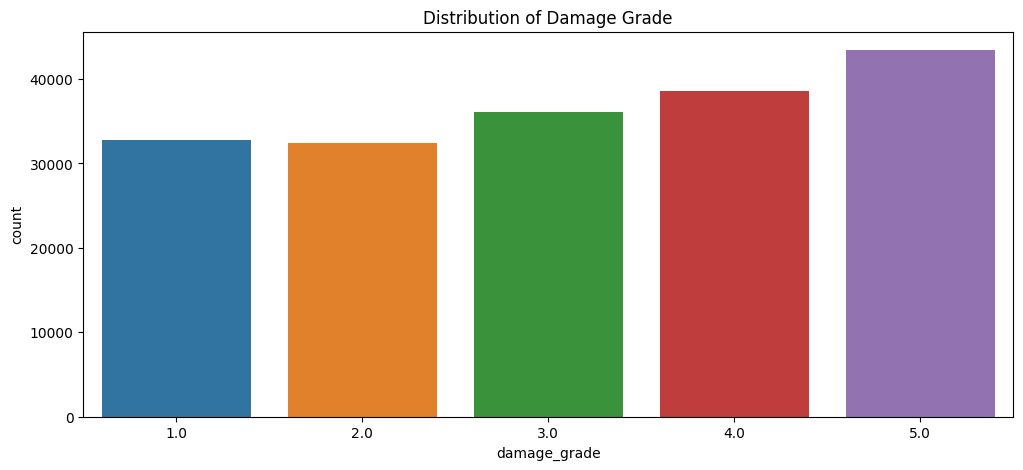

In [141]:
plt.figure(figsize = (12, 5))
ax = sns.countplot(x = 'damage_grade', data = train_csv_preprocessed_cleaned)
plt.title("Distribution of Damage Grade")
plt.show()

<ipython-input-142-5272ea83cefb>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


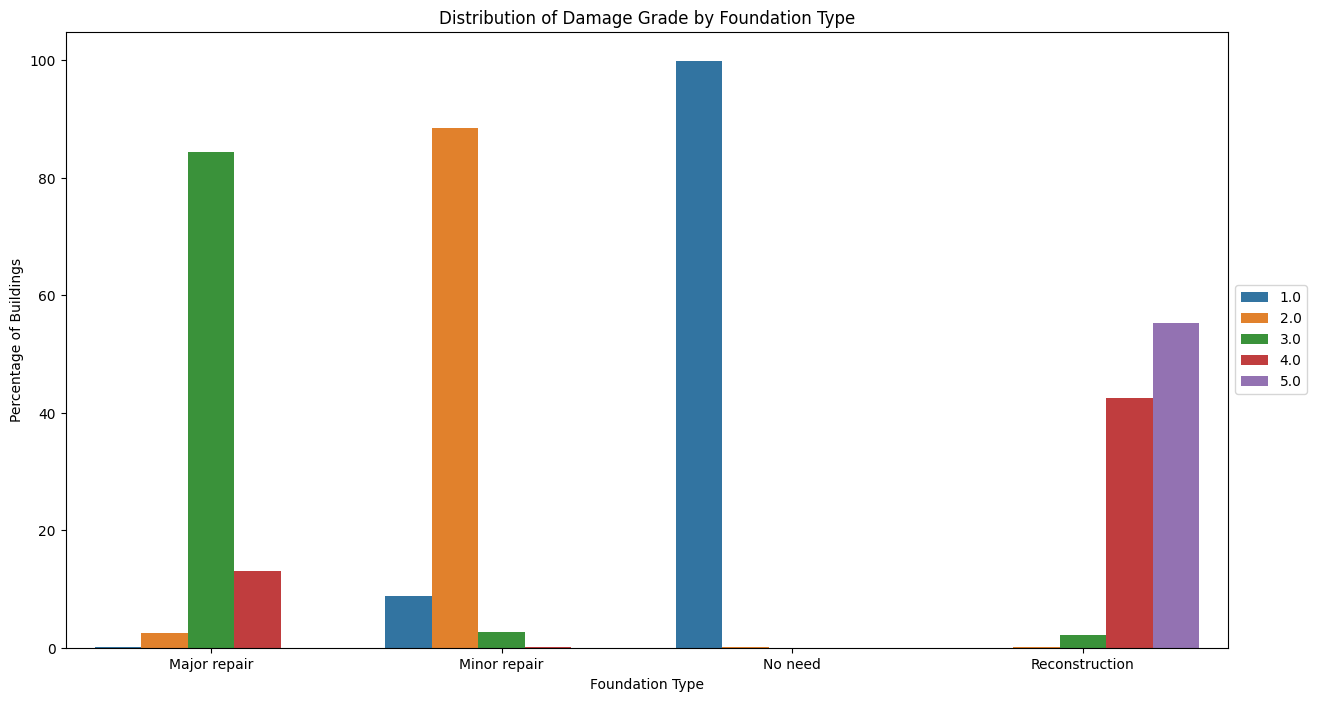

In [142]:
# Calculate counts
df_temp = train_csv_preprocessed_cleaned.groupby(['technical_solution_proposed','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['technical_solution_proposed', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'technical_solution_proposed', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Foundation Type")
plt.xlabel("Foundation Type")
plt.ylabel("Percentage of Buildings")
plt.show()

### Categorical EDA

#### 1. Superstructure Flexibility Usage

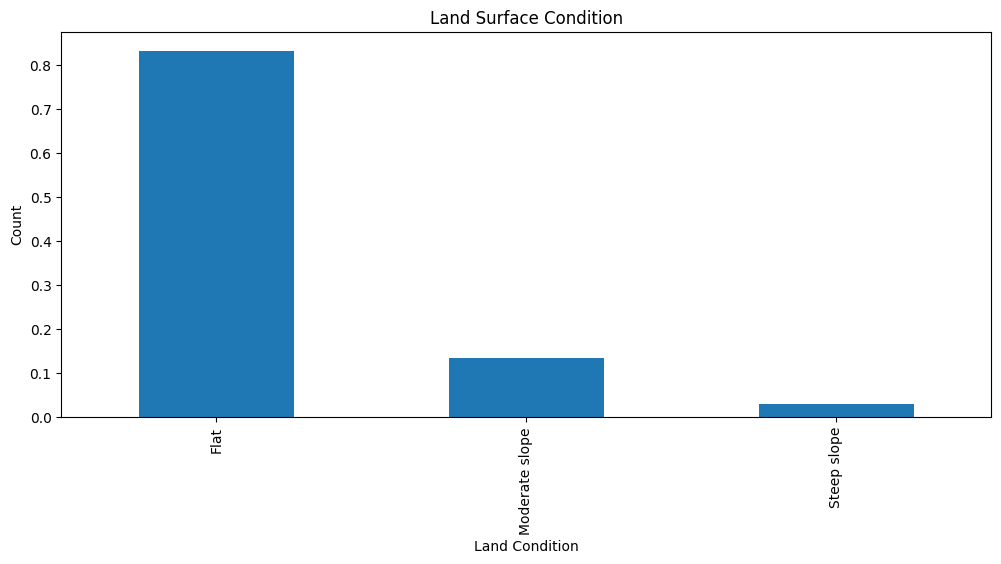

In [143]:
# Create a plot
plt.figure(figsize = (12, 5))
ax = train_csv_preprocessed_cleaned.land_surface_condition.value_counts(normalize = True).plot(kind = "bar")

plt.title("Land Surface Condition")
plt.ylabel("Count")
plt.xlabel("Land Condition")
plt.show()

<ipython-input-144-d4590e56c2b8>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


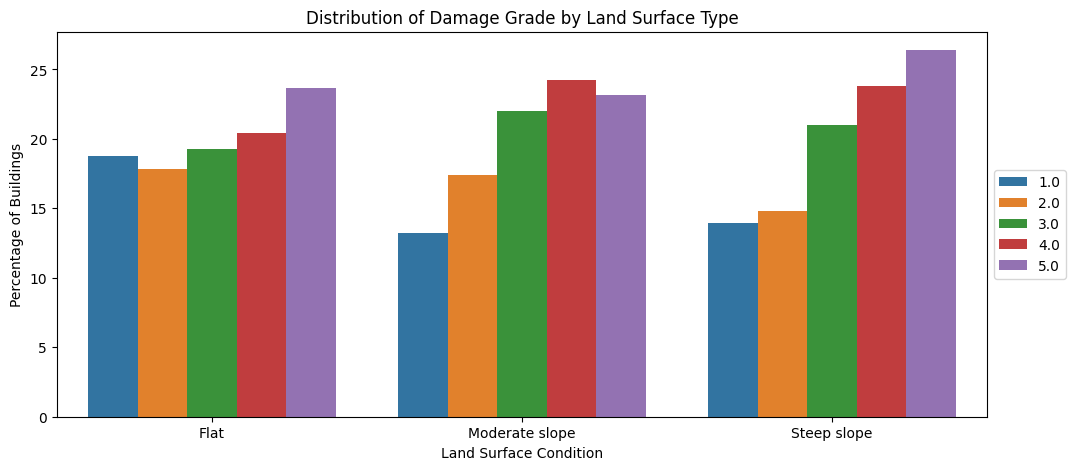

In [144]:
# Calculate counts
df_temp = train_csv_preprocessed_cleaned.groupby(['land_surface_condition','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['land_surface_condition', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (12, 5))
ax = sns.barplot(data = df_temp, 
                 x = 'land_surface_condition', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Land Surface Type")
plt.xlabel("Land Surface Condition")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-145-9d8cb60d161f>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


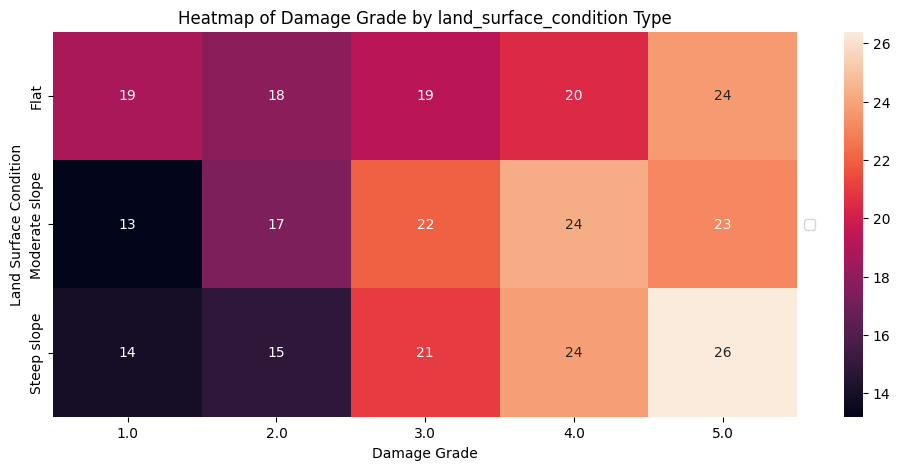

In [145]:
## Heatmap
df_temp = train_csv_preprocessed_cleaned.groupby(['land_surface_condition','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['land_surface_condition', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['land_surface_condition'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by land_surface_condition Type")
plt.xlabel("Damage Grade")
plt.ylabel("Land Surface Condition")
plt.show()

#### 2. Floors before Earthquake

<ipython-input-146-4031dd250db6>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


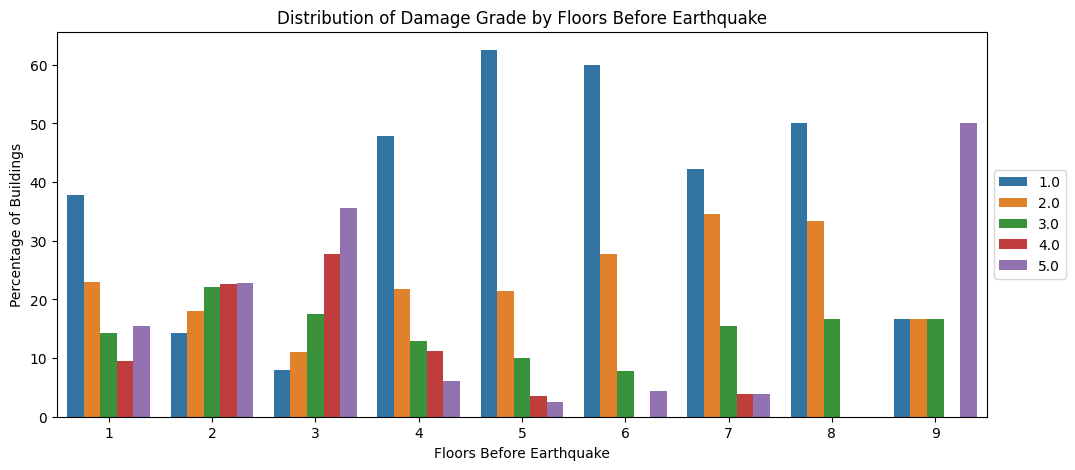

In [146]:
# Calculate counts
df_temp = train_csv_preprocessed_cleaned.groupby(['floors_before_eq (total)','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['floors_before_eq (total)', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (12, 5))
ax = sns.barplot(data = df_temp, 
                 x = 'floors_before_eq (total)', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Floors Before Earthquake")
plt.xlabel("Floors Before Earthquake")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-147-7b81ad0b3270>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


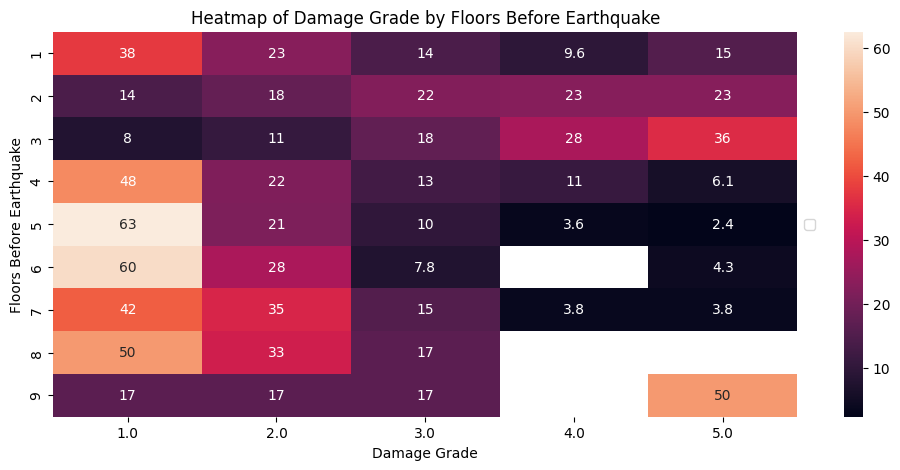

In [147]:
## Heatmap
df_temp = train_csv_preprocessed_cleaned.groupby(['floors_before_eq (total)','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['floors_before_eq (total)', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['floors_before_eq (total)'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Floors Before Earthquake")
plt.xlabel("Damage Grade")
plt.ylabel("Floors Before Earthquake")
plt.show()

#### 3. Land Surface Condition

<ipython-input-148-2724bf396b5f>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


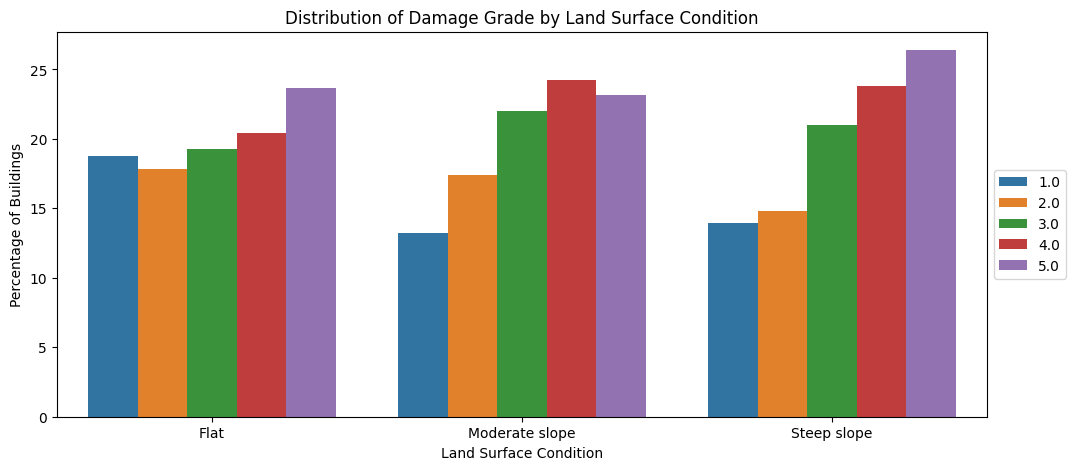

In [148]:
# Calculate counts
df_temp = train_csv_preprocessed_cleaned.groupby(['land_surface_condition','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['land_surface_condition', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (12, 5))
ax = sns.barplot(data = df_temp, 
                 x = 'land_surface_condition', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Land Surface Condition")
plt.xlabel("Land Surface Condition")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-149-349074f7e210>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


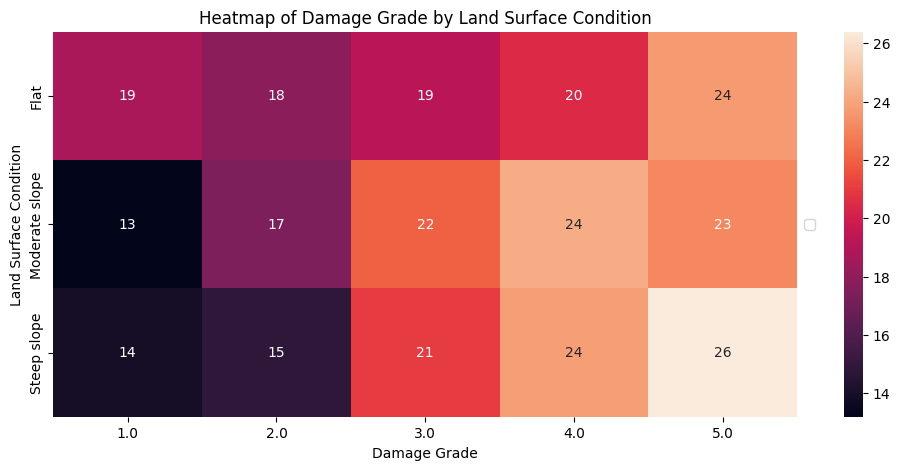

In [149]:
## Heatmap
df_temp = train_csv_preprocessed_cleaned.groupby(['land_surface_condition','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['land_surface_condition', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['land_surface_condition'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Land Surface Condition")
plt.xlabel("Damage Grade")
plt.ylabel("Land Surface Condition")
plt.show()

#### 4. Type of Foundation

<ipython-input-150-664b8a72e7da>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


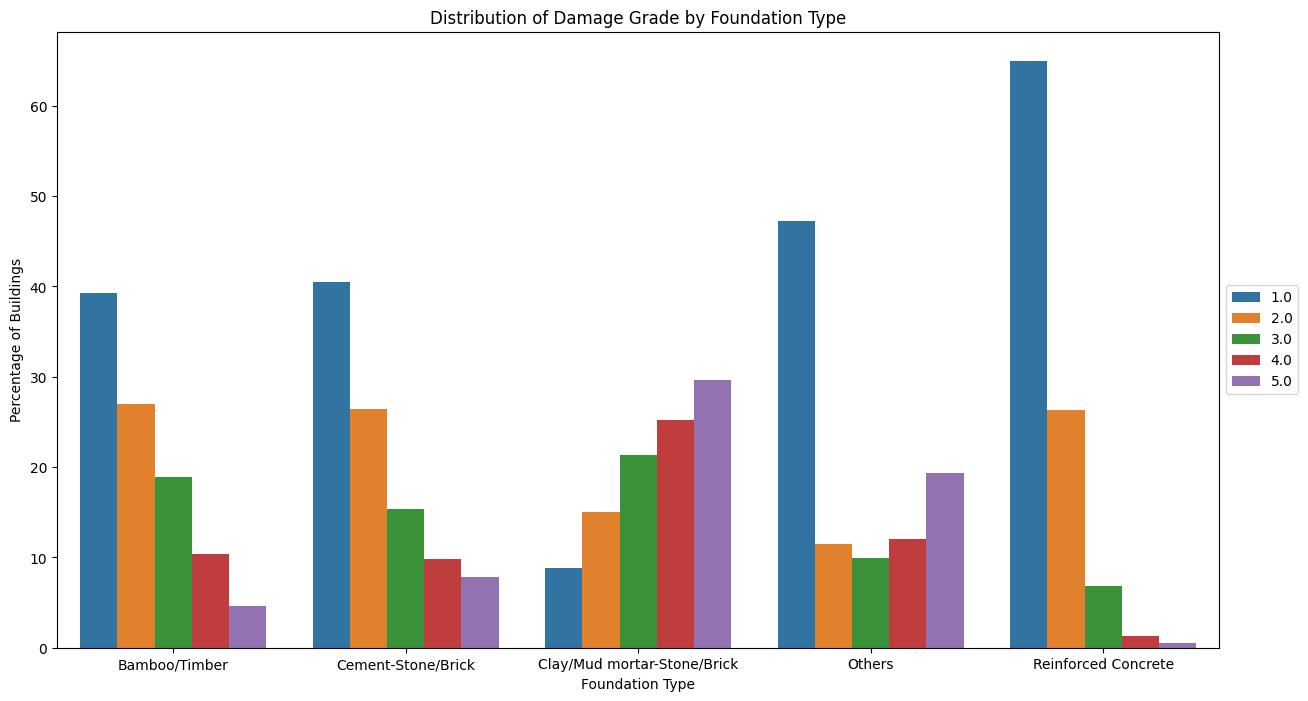

In [150]:
# Calculate counts
df_temp = train_csv_preprocessed_cleaned.groupby(['type_of_foundation','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_foundation', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'type_of_foundation', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Foundation Type")
plt.xlabel("Foundation Type")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-151-7304784099d6>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


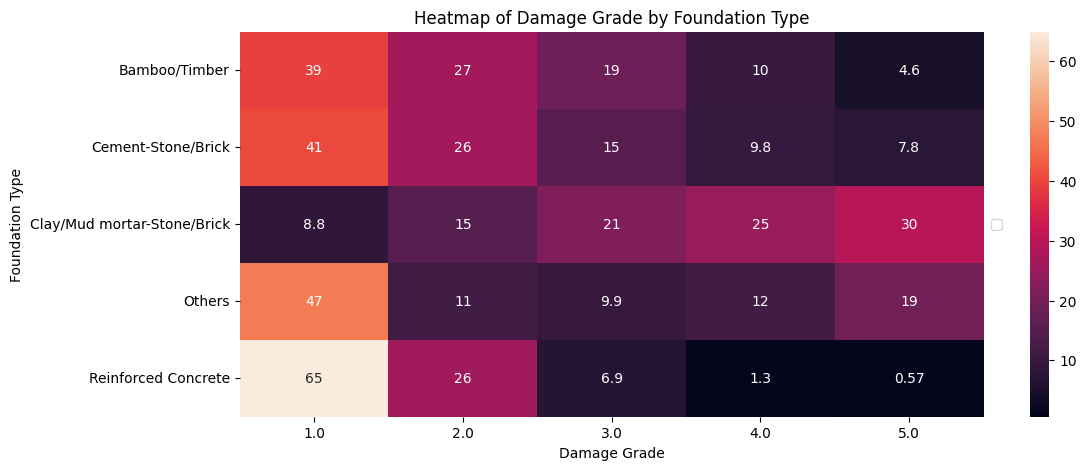

In [151]:
## Heatmap
df_temp = train_csv_preprocessed_cleaned.groupby(['type_of_foundation','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_foundation', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['type_of_foundation'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Foundation Type")
plt.xlabel("Damage Grade")
plt.ylabel("Foundation Type")
plt.show()

#### 5. Type of Roof

<ipython-input-152-190ff4914db1>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


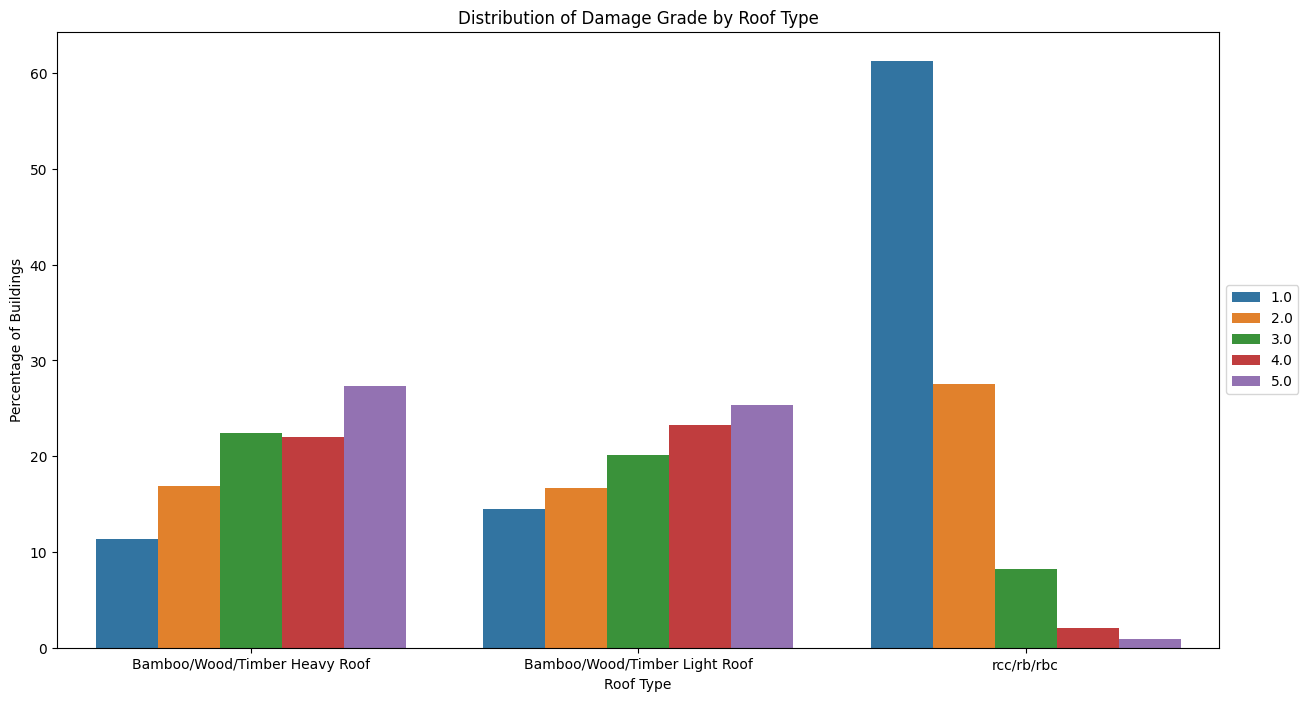

In [152]:
# Calculate counts
df_temp = train_csv_preprocessed_cleaned.groupby(['type_of_roof','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_roof', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'type_of_roof', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Roof Type")
plt.xlabel("Roof Type")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-153-5bdff446f75b>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


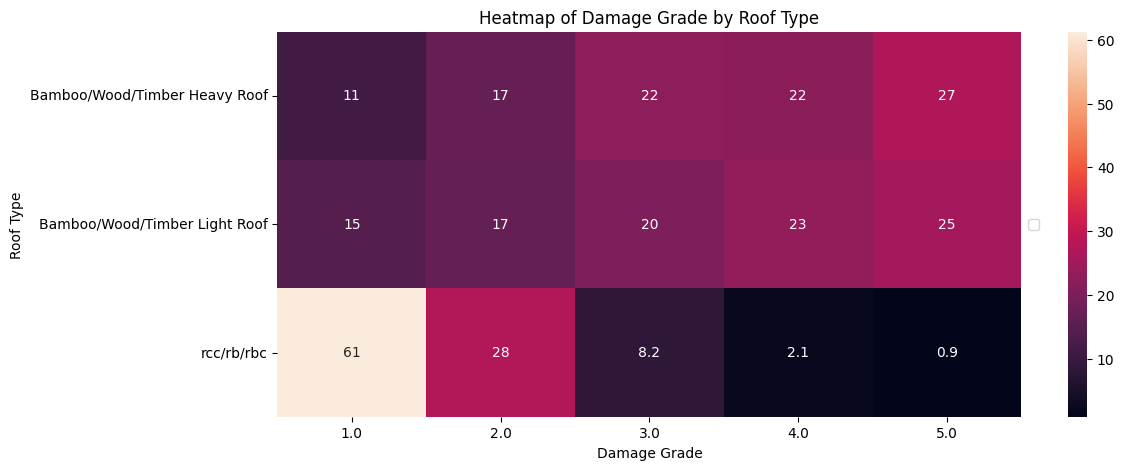

In [153]:
## Heatmap
df_temp = train_csv_preprocessed_cleaned.groupby(['type_of_roof','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_roof', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['type_of_roof'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Roof Type")
plt.xlabel("Damage Grade")
plt.ylabel("Roof Type")
plt.show()

#### 6. Type of Ground Floor

<ipython-input-154-f0344feed90f>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


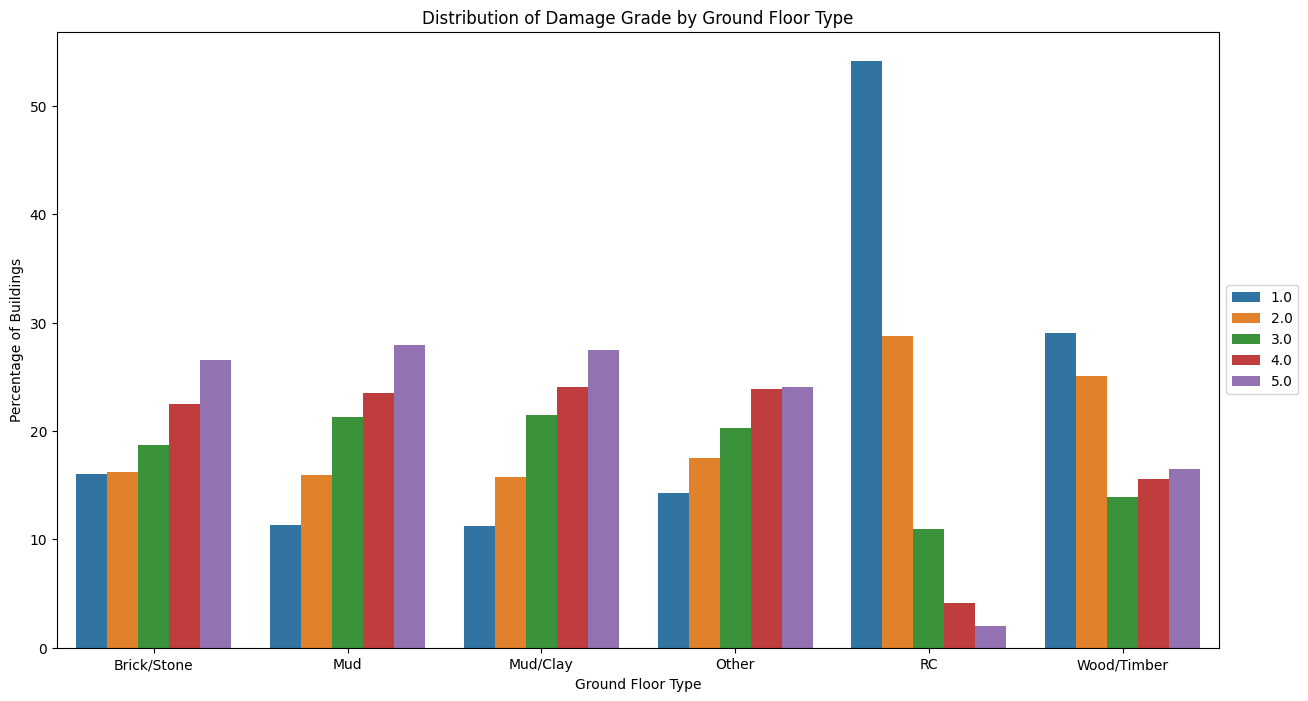

In [154]:
# Calculate counts
df_temp = train_csv_preprocessed_cleaned.groupby(['type_of_ground_floor','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_ground_floor', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'type_of_ground_floor', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Ground Floor Type")
plt.xlabel("Ground Floor Type")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-155-bcb740970ef8>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


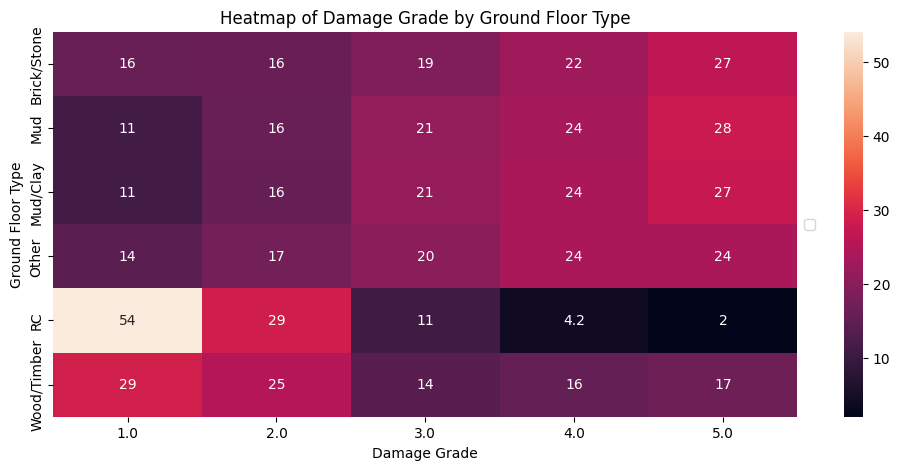

In [155]:
## Heatmap
df_temp = train_csv_preprocessed_cleaned.groupby(['type_of_ground_floor','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_ground_floor', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['type_of_ground_floor'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Ground Floor Type")
plt.xlabel("Damage Grade")
plt.ylabel("Ground Floor Type")
plt.show()

#### 7. Type of Other Floor

<ipython-input-156-c3c17f734040>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


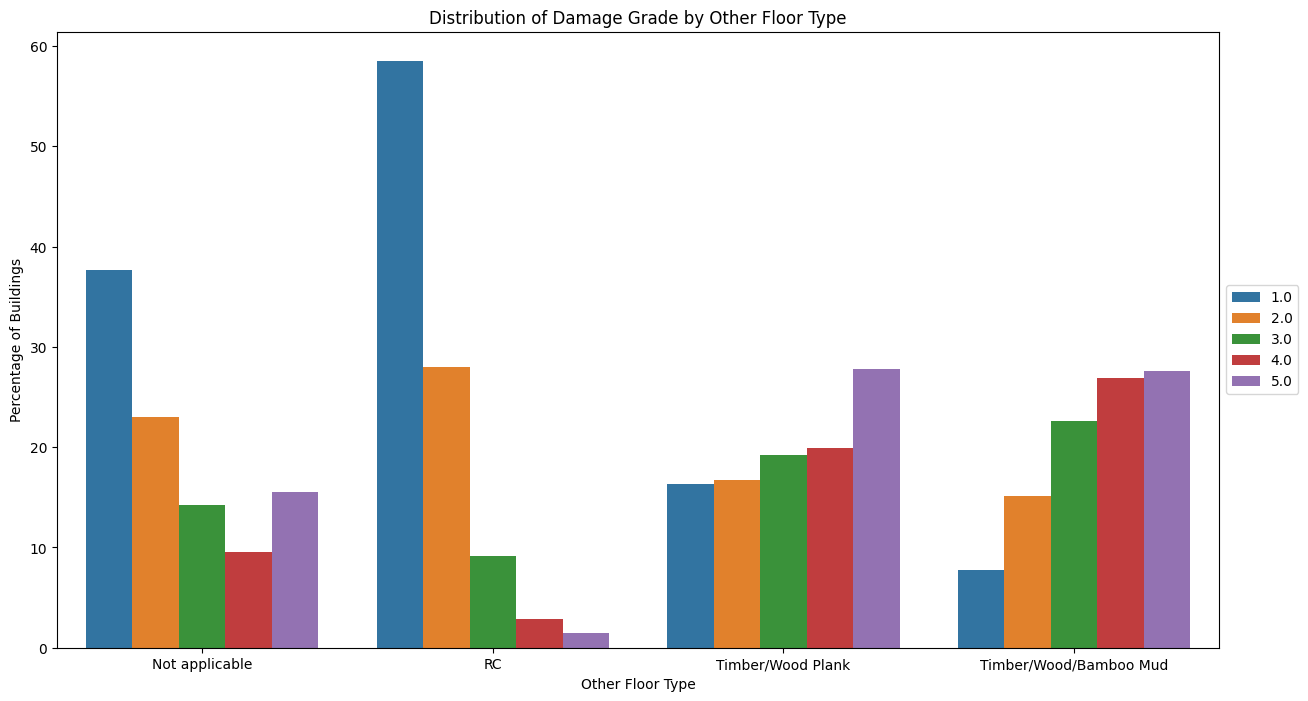

In [156]:
# Calculate counts
df_temp = train_csv_preprocessed_cleaned.groupby(['type_of_other_floor','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_other_floor', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'type_of_other_floor', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Other Floor Type")
plt.xlabel("Other Floor Type")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-157-1f4a7f294e45>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


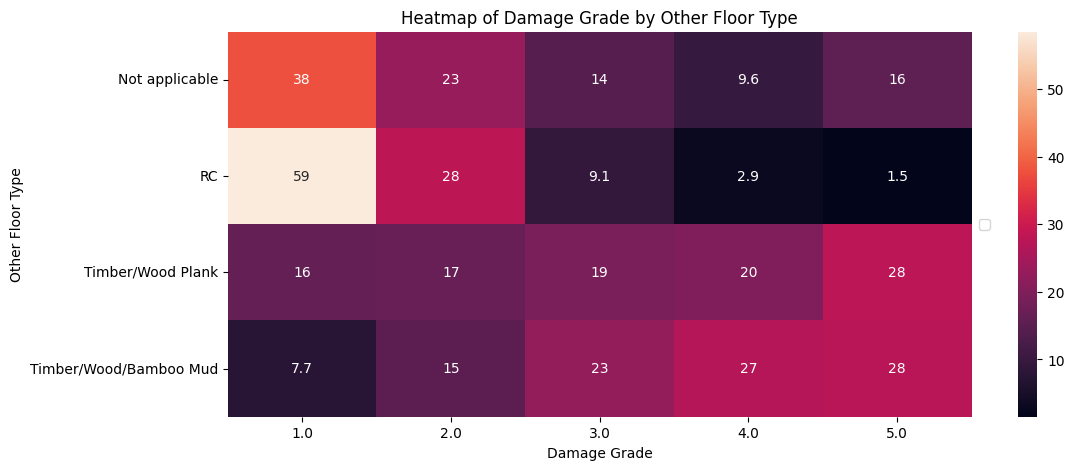

In [157]:
## Heatmap
df_temp = train_csv_preprocessed_cleaned.groupby(['type_of_other_floor','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_other_floor', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['type_of_other_floor'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Other Floor Type")
plt.xlabel("Damage Grade")
plt.ylabel("Other Floor Type")
plt.show()

#### 8. Position

<ipython-input-158-d85eb2c7ba1f>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


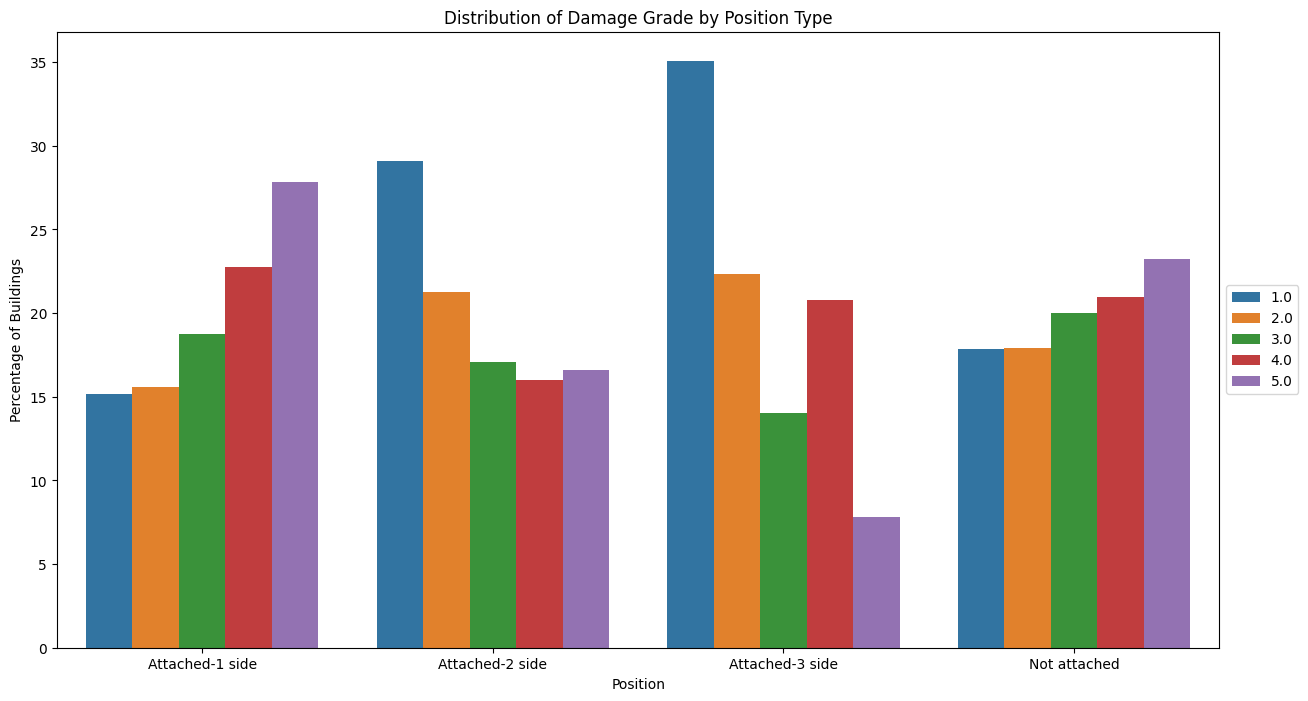

In [158]:
# Calculate counts
df_temp = train_csv_preprocessed_cleaned.groupby(['position','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['position', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'position', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Position Type")
plt.xlabel("Position")
plt.ylabel("Percentage of Buildings")
plt.show()

In [159]:
train_csv_preprocessed_cleaned['position'].value_counts()

Not attached       145751
Attached-1 side     29808
Attached-2 side      7331
Attached-3 side       385
Name: position, dtype: int64

<ipython-input-160-cb735b18c97a>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


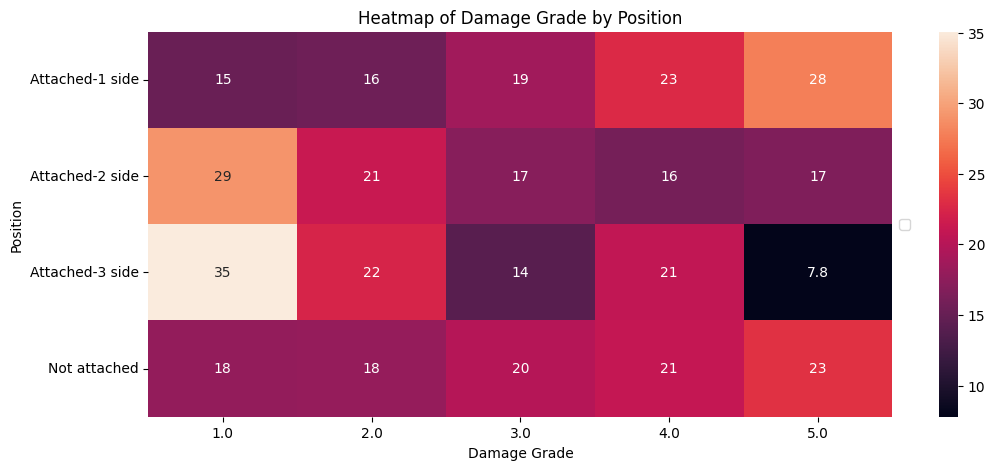

In [160]:
## Heatmap
df_temp = train_csv_preprocessed_cleaned.groupby(['position','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['position', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['position'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Position")
plt.xlabel("Damage Grade")
plt.ylabel("Position")
plt.show()

#### 9. Industrial Use Type

<ipython-input-161-b3ba655faf9b>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


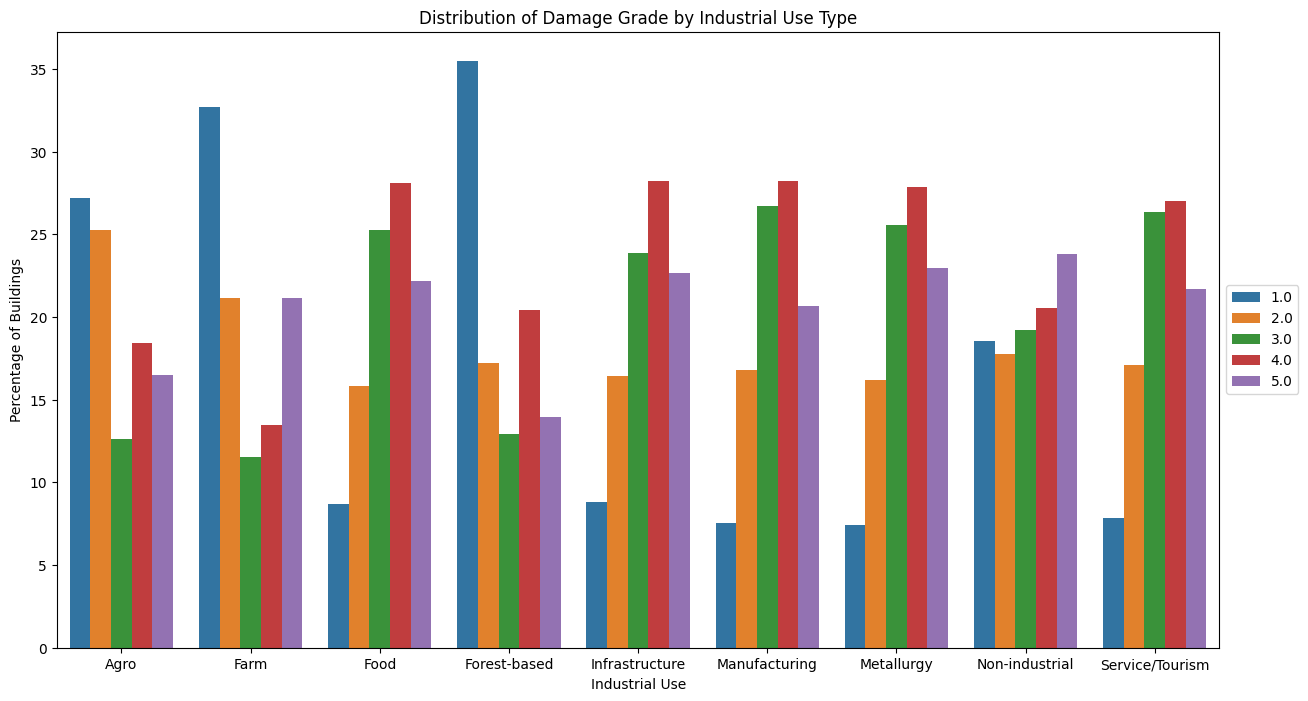

In [161]:
# Calculate counts
df_temp = train_csv_preprocessed_cleaned.groupby(['industrial_use_type','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['industrial_use_type', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'industrial_use_type', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Industrial Use Type")
plt.xlabel("Industrial Use")
plt.ylabel("Percentage of Buildings")
plt.show()

<ipython-input-162-d3199d61420b>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


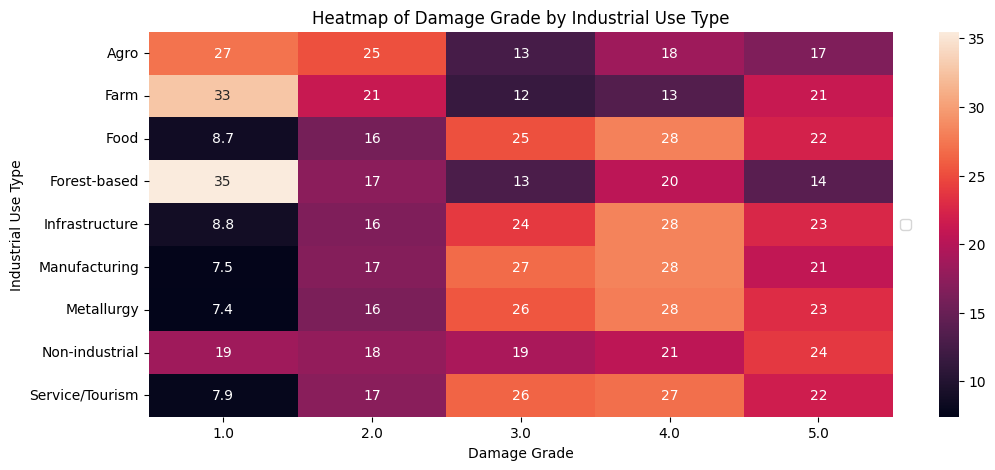

In [162]:
## Heatmap
df_temp = train_csv_preprocessed_cleaned.groupby(['industrial_use_type','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['industrial_use_type', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['industrial_use_type'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Industrial Use Type")
plt.xlabel("Damage Grade")
plt.ylabel("Industrial Use Type")
plt.show()

#### 10. Type of Reinforcement Concrete

<ipython-input-163-89dec3476601>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


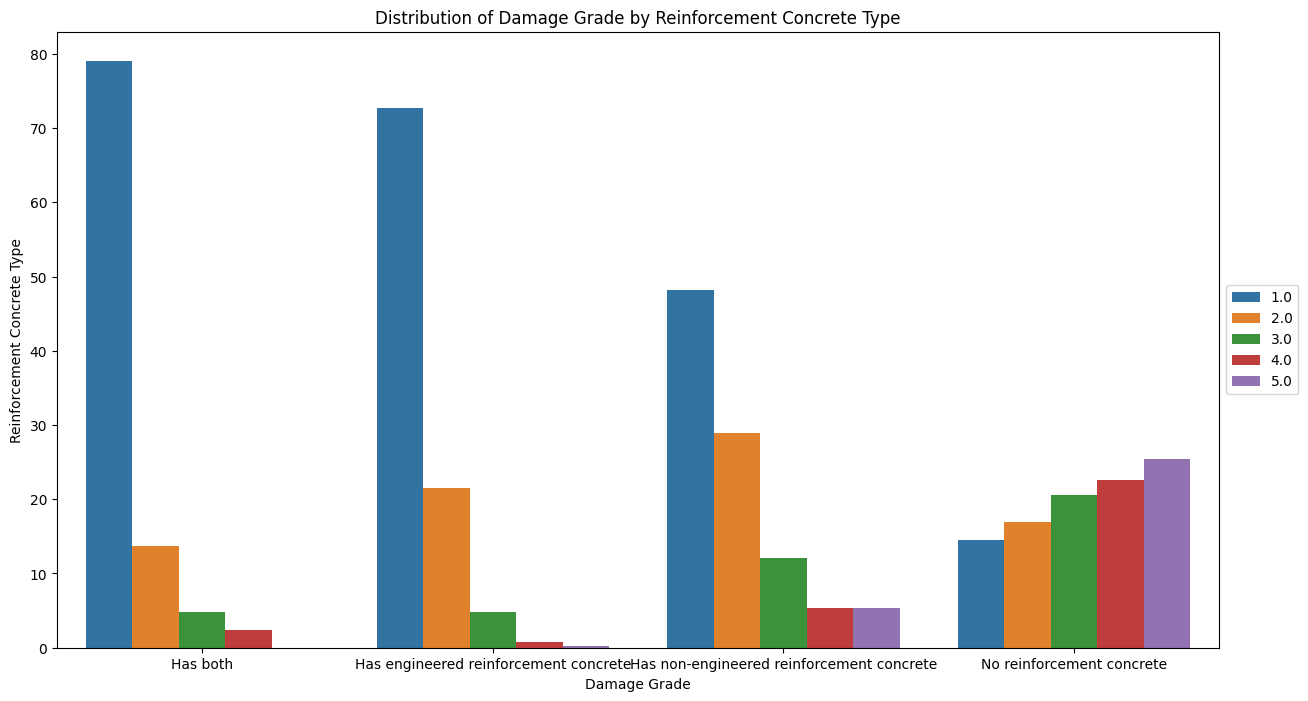

In [163]:
# Calculate counts
df_temp = train_csv_preprocessed_cleaned.groupby(['type_of_reinforcement_concrete','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_reinforcement_concrete', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'type_of_reinforcement_concrete', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Reinforcement Concrete Type")
plt.xlabel("Damage Grade")
plt.ylabel("Reinforcement Concrete Type")
plt.show()

<ipython-input-164-d1120b0e9446>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


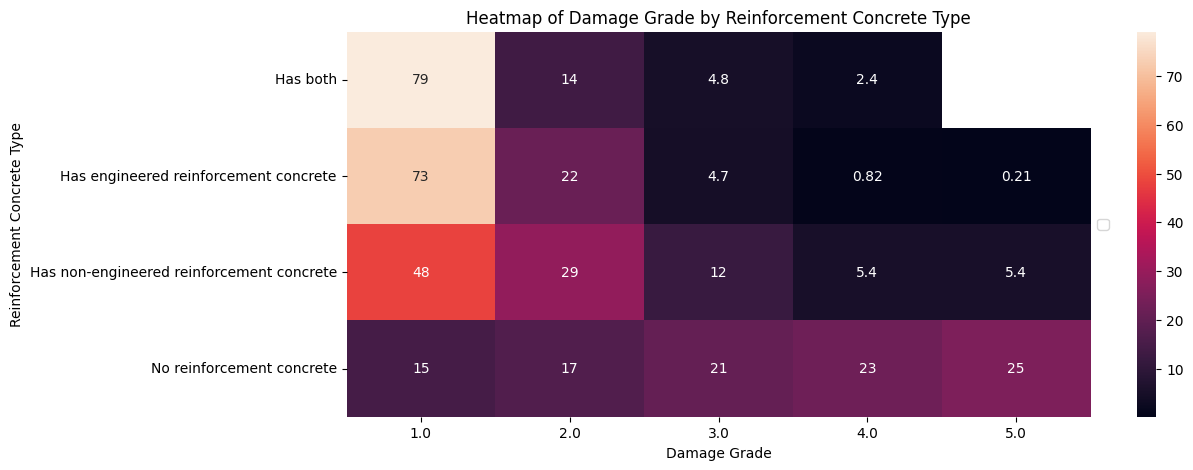

In [164]:
## Heatmap
df_temp = train_csv_preprocessed_cleaned.groupby(['type_of_reinforcement_concrete','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['type_of_reinforcement_concrete', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['type_of_reinforcement_concrete'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Reinforcement Concrete Type")
plt.xlabel("Damage Grade")
plt.ylabel("Reinforcement Concrete Type")
plt.show()

#### 11. Wall Binding

<ipython-input-165-254889deecff>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


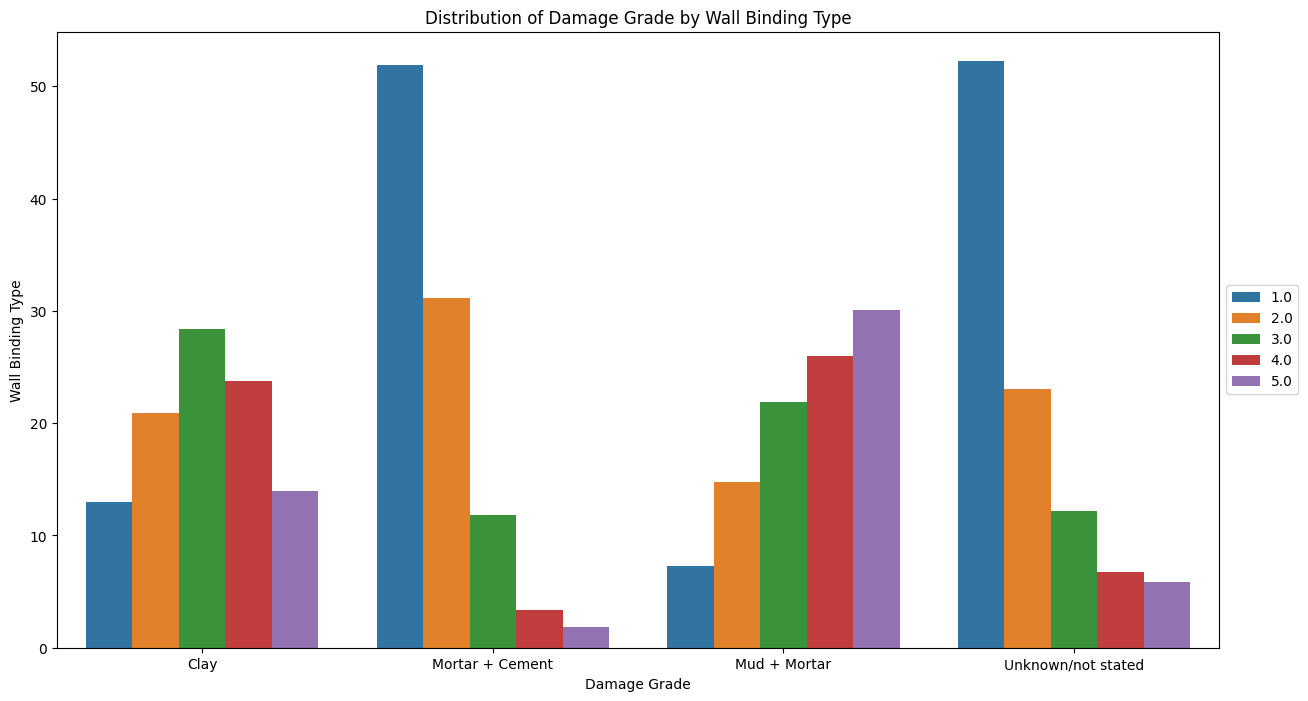

In [165]:
# Calculate counts
df_temp = train_csv_preprocessed_cleaned.groupby(['wall_binding','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['wall_binding', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'wall_binding', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Wall Binding Type")
plt.xlabel("Damage Grade")
plt.ylabel("Wall Binding Type")
plt.show()

<ipython-input-166-b996b272df04>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


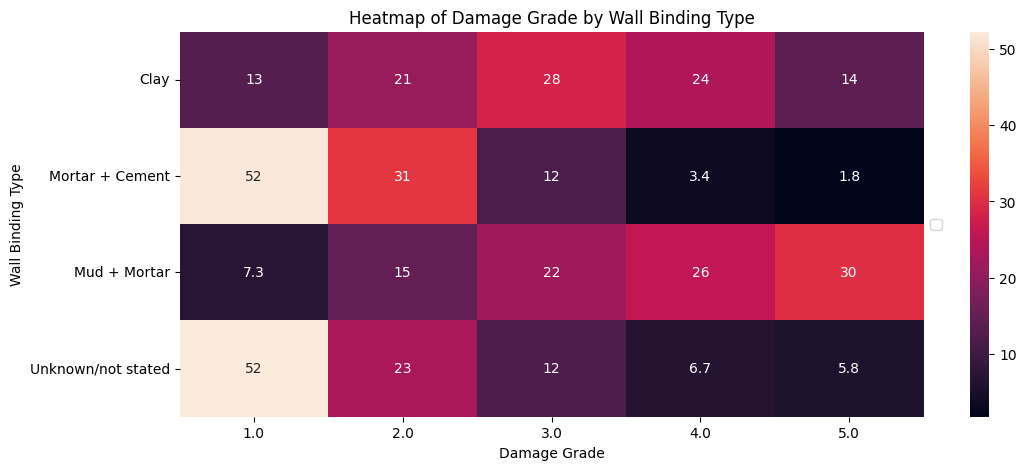

In [166]:
## Heatmap
df_temp = train_csv_preprocessed_cleaned.groupby(['wall_binding','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['wall_binding', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['wall_binding'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Wall Binding Type")
plt.xlabel("Damage Grade")
plt.ylabel("Wall Binding Type")
plt.show()

#### 12. Wall Materials

<ipython-input-167-6ba7c6d5092c>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


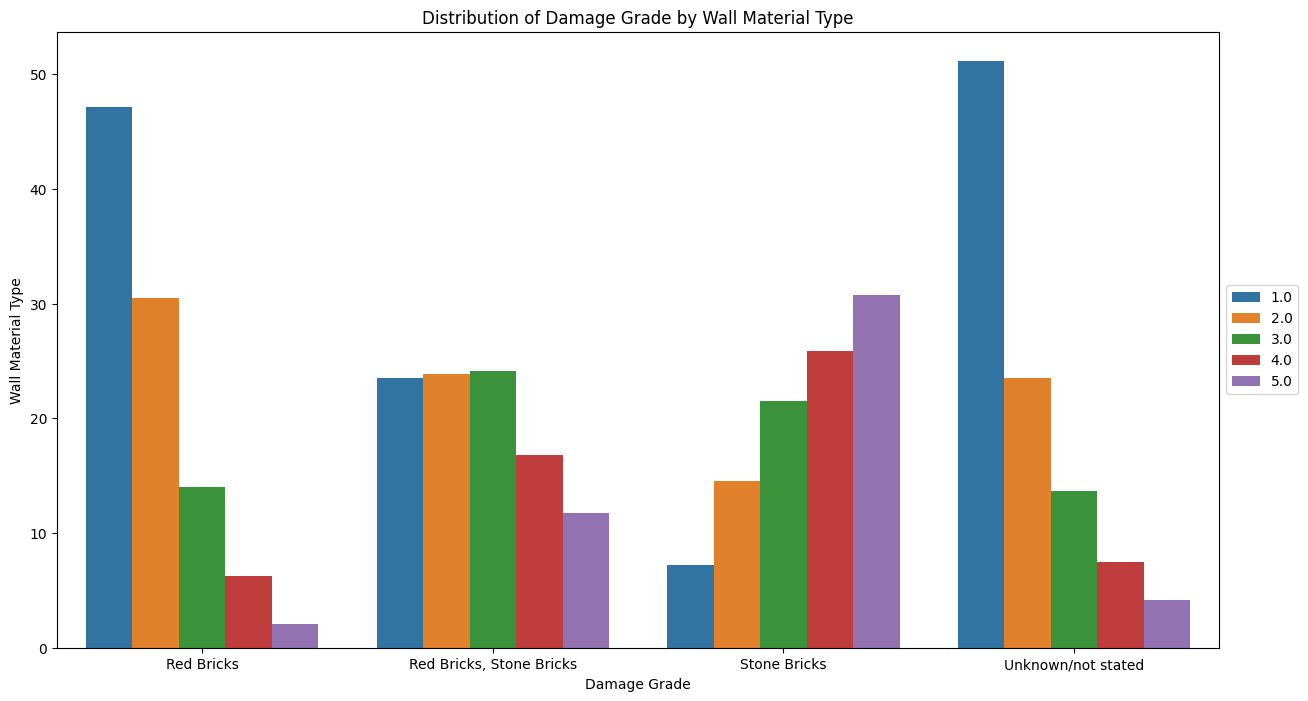

In [167]:
# Calculate counts
df_temp = train_csv_preprocessed_cleaned.groupby(['wall_material','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['wall_material', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'wall_material', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Wall Material Type")
plt.xlabel("Damage Grade")
plt.ylabel("Wall Material Type")
plt.show()

<ipython-input-168-083d9e37ef70>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


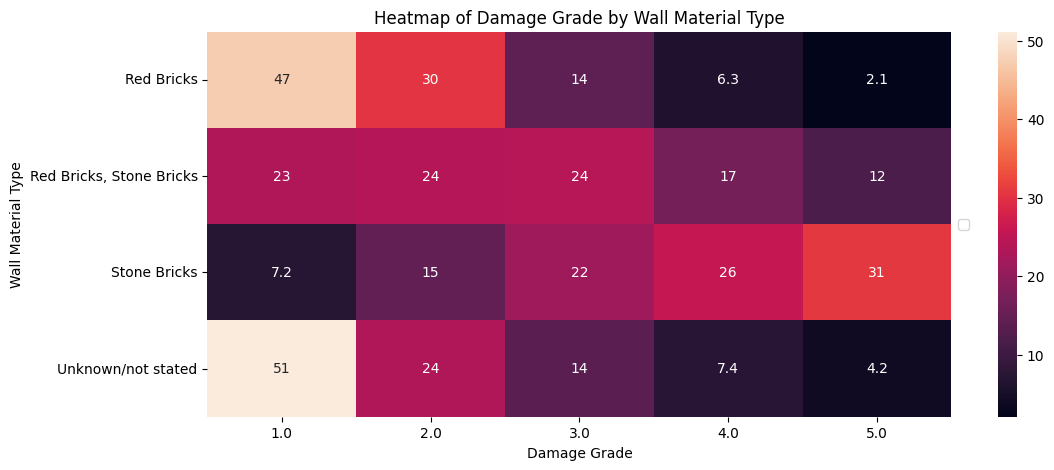

In [168]:
## Heatmap
df_temp = train_csv_preprocessed_cleaned.groupby(['wall_material','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['wall_material', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['wall_material'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Wall Material Type")
plt.xlabel("Damage Grade")
plt.ylabel("Wall Material Type")
plt.show()

#### 13. Building Plan Config

<ipython-input-169-f889e157e319>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


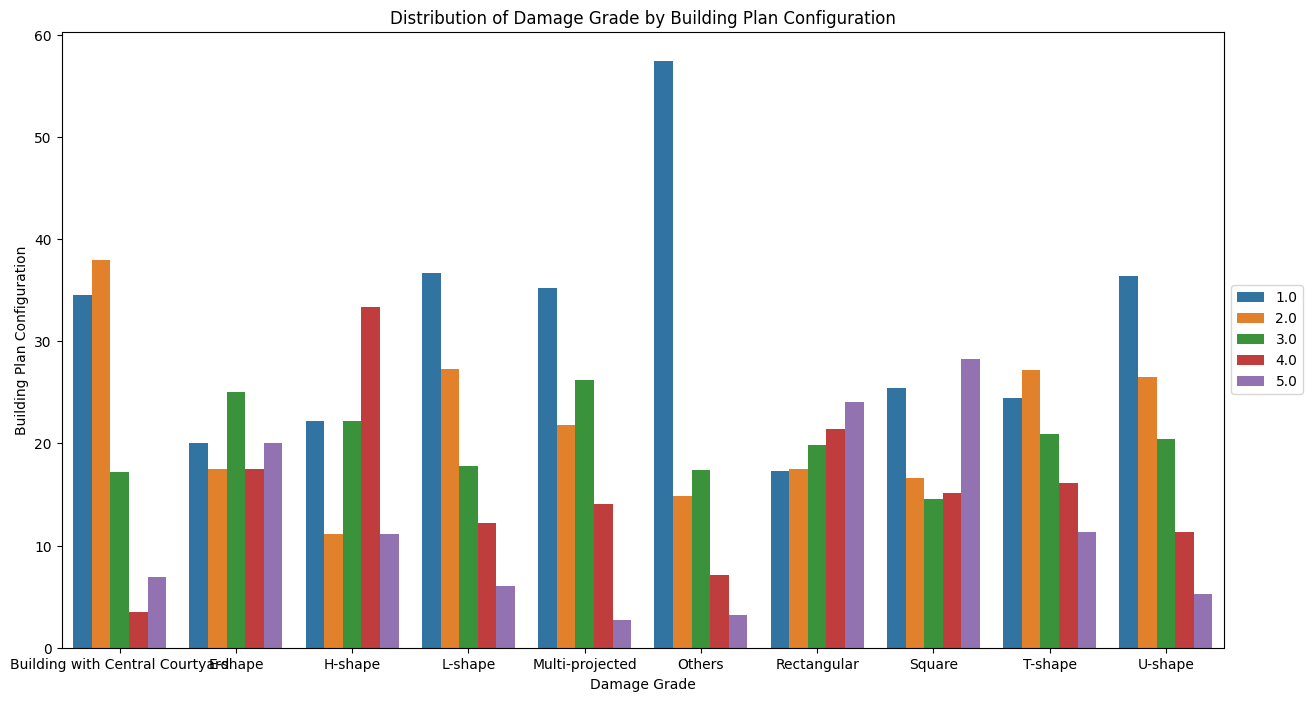

In [169]:
# Calculate counts
df_temp = train_csv_preprocessed_cleaned.groupby(['building_plan_configuration','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['building_plan_configuration', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'building_plan_configuration', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Building Plan Configuration")
plt.xlabel("Damage Grade")
plt.ylabel("Building Plan Configuration")
plt.show()

In [170]:
train_csv_preprocessed_cleaned['building_plan_configuration'].value_counts()

Rectangular                        175049
Square                               4116
L-shape                              3147
Multi-projected                       298
T-shape                               291
Others                                155
U-shape                               132
E-shape                                40
Building with Central Courtyard        29
H-shape                                18
Name: building_plan_configuration, dtype: int64

<ipython-input-171-9a7d958df0e6>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


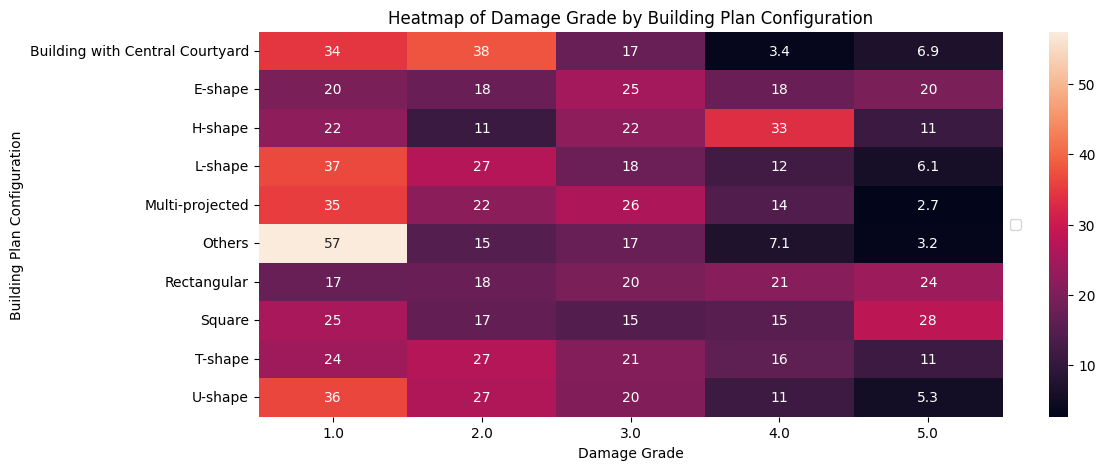

In [171]:
## Heatmap
df_temp = train_csv_preprocessed_cleaned.groupby(['building_plan_configuration','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['building_plan_configuration', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['building_plan_configuration'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Building Plan Configuration")
plt.xlabel("Damage Grade")
plt.ylabel("Building Plan Configuration")
plt.show()

#### 14. Technical Solution Proposed

<ipython-input-172-8e10a09927bd>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


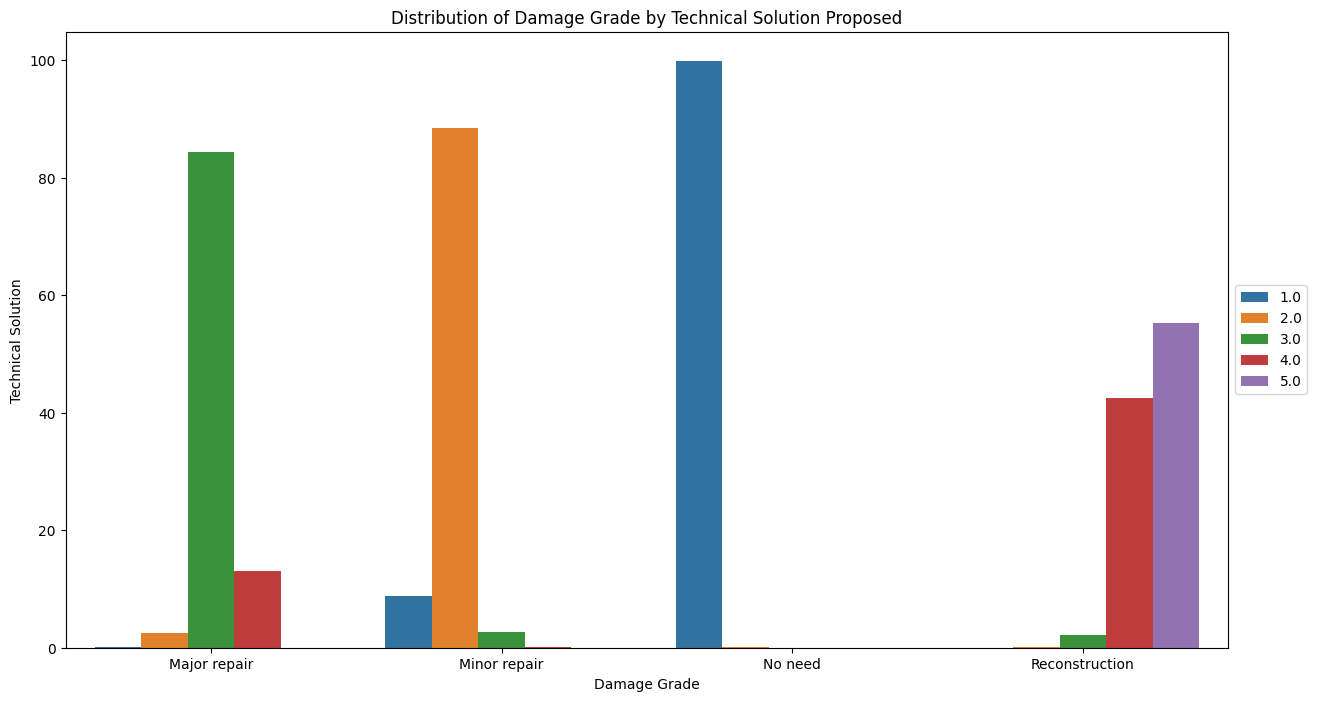

In [172]:
# Calculate counts
df_temp = train_csv_preprocessed_cleaned.groupby(['technical_solution_proposed','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['technical_solution_proposed', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize = (15, 8))
ax = sns.barplot(data = df_temp, 
                 x = 'technical_solution_proposed', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Distribution of Damage Grade by Technical Solution Proposed")
plt.xlabel("Damage Grade")
plt.ylabel("Technical Solution")
plt.show()

<ipython-input-173-25bcd154f075>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()


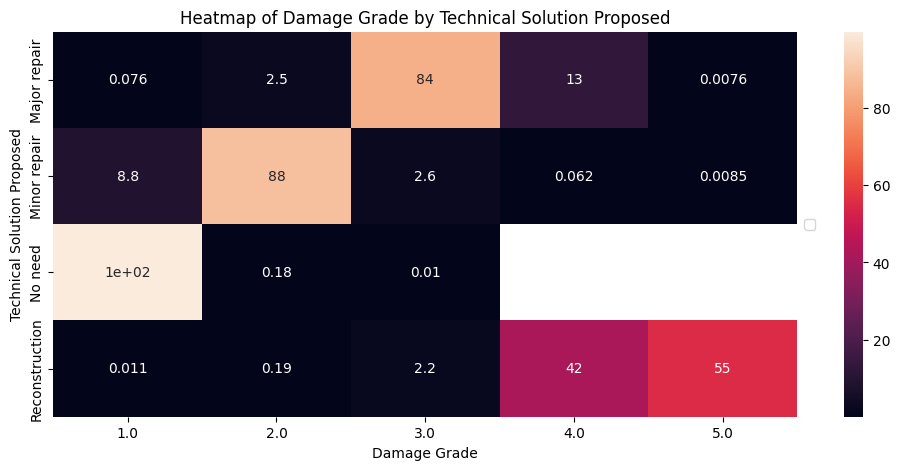

In [173]:
## Heatmap
df_temp = train_csv_preprocessed_cleaned.groupby(['technical_solution_proposed','damage_grade']).size().reset_index(name = 'count')
df_temp = df_temp.set_index(['technical_solution_proposed', 'damage_grade'])
df_temp = df_temp.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values = 'count', index = ['technical_solution_proposed'], columns = 'damage_grade')

# Plot char
plt.figure(figsize = (12, 5))
ax = sns.heatmap(data = df_temp, annot = True )
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), ncol = 1)
plt.title("Heatmap of Damage Grade by Technical Solution Proposed")
plt.xlabel("Damage Grade")
plt.ylabel("Technical Solution Proposed")
plt.show()

In [174]:
train_csv_preprocessed_cleaned['technical_solution_proposed'].value_counts()

Reconstruction    78692
Major repair      39625
Minor repair      35282
No need           29676
Name: technical_solution_proposed, dtype: int64

# Feature Engineering - 2

In [216]:
train_csv_preprocessed_cleaned.dtypes

floors_before_eq (total)           int64
old_building                       int64
plinth_area (ft^2)                 int64
height_before_eq (ft)              int64
land_surface_condition            object
type_of_foundation                object
type_of_roof                      object
type_of_ground_floor              object
type_of_other_floor               object
position                          object
building_plan_configuration       object
technical_solution_proposed       object
type_of_reinforcement_concrete    object
industrial_use_type               object
flexible_superstructure           object
wall_binding                      object
wall_material                     object
damage_grade                      object
dtype: object

Since the data is not as unbalanced as before based on the latest EDA, we won't be doing undersampling this time

## Outlier Removal

In [217]:
## RobustScaler()
train_csv_preprocessed_cleaned_2 = train_csv_preprocessed_cleaned.copy()
robust_scaler = RobustScaler(quantile_range = (0, 0.8))

train_csv_preprocessed_cleaned_2[['old_building', 'plinth_area (ft^2)']] = robust_scaler.fit_transform(train_csv_preprocessed_cleaned[['old_building', 'plinth_area (ft^2)']])
test_csv_preprocessed_cleaned[['old_building', 'plinth_area (ft^2)']] = robust_scaler.fit_transform(test_csv_preprocessed_cleaned[['old_building', 'plinth_area (ft^2)']])

In [218]:
features_num = train_csv_preprocessed_cleaned_2.drop(columns = 'damage_grade').select_dtypes(np.number).columns

In [219]:
features_num

Index(['floors_before_eq (total)', 'old_building', 'plinth_area (ft^2)',
       'height_before_eq (ft)'],
      dtype='object')

## Data Normalization

In [220]:
# StandardScaler() and MinMaxScaler()
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

train_csv_preprocessed_cleaned_2[features_num] = standard_scaler.fit_transform(train_csv_preprocessed_cleaned_2[features_num])
train_csv_preprocessed_cleaned_2[features_num] = minmax_scaler.fit_transform(train_csv_preprocessed_cleaned_2[features_num])

test_csv_preprocessed_cleaned[features_num] = standard_scaler.fit_transform(test_csv_preprocessed_cleaned[features_num])
test_csv_preprocessed_cleaned[features_num] = minmax_scaler.fit_transform(test_csv_preprocessed_cleaned[features_num])

In [221]:
train_csv_preprocessed_cleaned_2.head()

floors_before_eq (total)  old_building  plinth_area (ft^2)  \
0                     0.000      0.022022            0.247312   
1                     0.250      0.022022            0.311828   
2                     0.125      0.008008            0.333333   
3                     0.125      0.022022            0.193548   
4                     0.125      0.007007            0.260215   

   height_before_eq (ft) land_surface_condition           type_of_foundation  \
0               0.043011         Moderate slope  Clay/Mud mortar-Stone/Brick   
1               0.129032                   Flat  Clay/Mud mortar-Stone/Brick   
2               0.118280                   Flat  Clay/Mud mortar-Stone/Brick   
3               0.086022                   Flat  Clay/Mud mortar-Stone/Brick   
4               0.075269                   Flat  Clay/Mud mortar-Stone/Brick   

                    type_of_roof type_of_ground_floor     type_of_other_floor  \
0  Bamboo/Wood/Timber Light Roof             Mud/Clay          Not applicable   
1  Bamboo/Wood/Timber Heavy Roof             Mud/Clay  Timber/Wood/Bamboo Mud   
2  Bamboo/Wood/Timber Light Roof          Brick/Stone       Timber/Wood Plank   
3  Bamboo/Wood/Timber Light Roof             Mud/Clay  Timber/Wood/Bamboo Mud   
4  Bamboo/Wood/Timber Light Roof             Mud/Clay  Timber/Wood/Bamboo Mud   

       position building_plan_configuration technical_solution_proposed  \
0  Not attached                 Rectangular              Reconstruction   
1  Not attached                 Rectangular              Reconstruction   
2  Not attached                 Rectangular              Reconstruction   
3  Not attached                 Rectangular              Reconstruction   
4  Not attached                 Rectangular                Major repair   

  type_of_reinforcement_concrete industrial_use_type flexible_superstructure  \
0      No reinforcement concrete      Non-industrial             unavailable   
1      No reinforcement concrete      Non-industrial             unavailable   
2      No reinforcement concrete      Non-industrial             unavailable   
3      No reinforcement concrete      Non-industrial             unavailable   
4      No reinforcement concrete      Non-industrial               available   

   wall_binding wall_material damage_grade  
0  Mud + Mortar  Stone Bricks          5.0  
1  Mud + Mortar  Stone Bricks          4.0  
2  Mud + Mortar  Stone Bricks          5.0  
3  Mud + Mortar  Stone Bricks          5.0  
4  Mud + Mortar  Stone Bricks          2.0

In [222]:
train_csv_preprocessed_cleaned_2[['floors_before_eq (total)', 'old_building', 'plinth_area (ft^2)', 'height_before_eq (ft)']].describe()

floors_before_eq (total)   old_building  plinth_area (ft^2)  \
count             183275.000000  183275.000000       183275.000000   
mean                   0.130316       0.022993            0.362754   
std                    0.084834       0.065198            0.208428   
min                    0.000000       0.000000            0.000000   
25%                    0.125000       0.007007            0.225806   
50%                    0.125000       0.015015            0.311828   
75%                    0.125000       0.025025            0.447312   
max                    1.000000       1.000000            1.000000   

       height_before_eq (ft)  
count          183275.000000  
mean                0.106919  
std                 0.062004  
min                 0.000000  
25%                 0.064516  
50%                 0.096774  
75%                 0.129032  
max                 1.000000

## One Hot Encoding

In [223]:
## Renaming the categorical names, for better usage
train_csv_preprocessed_cleaned_2 = train_csv_preprocessed_cleaned_2.rename(columns = {
    'floors_before_eq (total)': 'floorsBeforeEq',
    'land_surface_condition': 'surfaceCondition',
    'type_of_foundation': 'foundation',
    'type_of_reinforcement_concrete': 'rcType',
    'type_of_roof': 'roof',
    'type_of_ground_floor': 'groundFloor',
    'type_of_other_floor': 'otherFloor',
    'industrial_use_type': 'useType',
    'building_plan_configuration': 'planConfiguration'
})

test_csv_preprocessed_cleaned_2 = test_csv_preprocessed_cleaned.rename(columns = {
    'floors_before_eq (total)': 'floorsBeforeEq',
    'land_surface_condition': 'surfaceCondition',
    'type_of_foundation': 'foundation',
    'type_of_reinforcement_concrete': 'rcType',
    'type_of_roof': 'roof',
    'type_of_ground_floor': 'groundFloor',
    'type_of_other_floor': 'otherFloor',
    'industrial_use_type': 'useType',
    'building_plan_configuration': 'planConfiguration'
})

In [224]:
train_csv_preprocessed_cleaned_2.dtypes

floorsBeforeEq                 float64
old_building                   float64
plinth_area (ft^2)             float64
height_before_eq (ft)          float64
surfaceCondition                object
foundation                      object
roof                            object
groundFloor                     object
otherFloor                      object
position                        object
planConfiguration               object
technical_solution_proposed     object
rcType                          object
useType                         object
flexible_superstructure         object
wall_binding                    object
wall_material                   object
damage_grade                    object
dtype: object

In [225]:
categories_1 = [
    ('surfaceCondition', train_csv_preprocessed_cleaned_2['surfaceCondition'].unique()),
    ('foundation', train_csv_preprocessed_cleaned_2['foundation'].unique()),
    ('roof', train_csv_preprocessed_cleaned_2['roof'].unique()),
    ('groundFloor', train_csv_preprocessed_cleaned_2['groundFloor'].unique()),
    ('otherFloor', train_csv_preprocessed_cleaned_2['otherFloor'].unique()),
    ('position', train_csv_preprocessed_cleaned_2['position'].unique()),
    ('planConfiguration', train_csv_preprocessed_cleaned_2['planConfiguration'].unique()),
    ('technical_solution_proposed', train_csv_preprocessed_cleaned_2['technical_solution_proposed'].unique()),
    ('rcType', train_csv_preprocessed_cleaned_2['rcType'].unique()),
    ('useType', train_csv_preprocessed_cleaned_2['useType'].unique()),
    ('flexible_superstructure', train_csv_preprocessed_cleaned_2['flexible_superstructure'].unique()),
    ('wall_binding', train_csv_preprocessed_cleaned_2['wall_binding'].unique()),
    ('wall_material', train_csv_preprocessed_cleaned_2['wall_material'].unique()),
]

In [226]:
categories_2 = [
    ('surfaceCondition', test_csv_preprocessed_cleaned_2['surfaceCondition'].unique()),
    ('foundation', test_csv_preprocessed_cleaned_2['foundation'].unique()),
    ('roof', test_csv_preprocessed_cleaned_2['roof'].unique()),
    ('groundFloor', test_csv_preprocessed_cleaned_2['groundFloor'].unique()),
    ('otherFloor', test_csv_preprocessed_cleaned_2['otherFloor'].unique()),
    ('position', test_csv_preprocessed_cleaned_2['position'].unique()),
    ('planConfiguration', test_csv_preprocessed_cleaned_2['planConfiguration'].unique()),
    ('technical_solution_proposed', test_csv_preprocessed_cleaned_2['technical_solution_proposed'].unique()),
    ('rcType', test_csv_preprocessed_cleaned_2['rcType'].unique()),
    ('useType', test_csv_preprocessed_cleaned_2['useType'].unique()),
    ('flexible_superstructure', test_csv_preprocessed_cleaned_2['flexible_superstructure'].unique()),
    ('wall_binding', test_csv_preprocessed_cleaned_2['wall_binding'].unique()),
    ('wall_material', test_csv_preprocessed_cleaned_2['wall_material'].unique()),
]

In [227]:
train_csv_preprocessed_cleaned_2['damage_grade'] = train_csv_preprocessed_cleaned_2['damage_grade'].astype('object')

In [228]:
## Setting up one hot encoder for training set
train_csv_engineered = train_csv_preprocessed_cleaned_2.copy()

ohe_columns_1 = [x[0] for x in categories_1]
ohe_categories_1 = [x[1] for x in categories_1]
enc_1 = OneHotEncoder(sparse_output = False, categories = ohe_categories_1)

train_csv_engineered = pd.DataFrame(
    enc_1.fit_transform(train_csv_preprocessed_cleaned_2[ohe_columns_1]),
    columns = enc_1.get_feature_names_out(),
    index = train_csv_preprocessed_cleaned_2.index
)

train_csv_engineered = pd.concat([train_csv_preprocessed_cleaned_2.drop(ohe_columns_1, axis = 1), train_csv_engineered], axis = 1)
temp = train_csv_engineered['damage_grade']
train_csv_engineered = train_csv_engineered.drop(columns = ['damage_grade'])
train_csv_engineered['damage_grade'] = temp

In [229]:
## Setting up one hot encoder for test set
test_csv_engineered = test_csv_preprocessed_cleaned_2.copy()

ohe_columns_2 = [x[0] for x in categories_2]
ohe_categories_2 = [x[1] for x in categories_2]
enc_2 = OneHotEncoder(sparse_output = False, categories = ohe_categories_2)


test_csv_engineered = pd.DataFrame(
    enc_2.fit_transform(test_csv_preprocessed_cleaned_2[ohe_columns_2]),
    columns = enc_2.get_feature_names_out(),
    index = test_csv_preprocessed_cleaned_2.index
)

test_csv_engineered = pd.concat([test_csv_preprocessed_cleaned_2.drop(ohe_columns_2, axis = 1), test_csv_engineered], axis = 1)

In [230]:
## Cleaning the column order and naming
temp = train_csv_engineered['damage_grade']
train_csv_engineered = train_csv_engineered.drop(columns = 'damage_grade')

train_csv_engineered = train_csv_engineered.rename({
    'rcType_0.0': 'rcType_0',
    'rcType_2.0': 'rcType_2', 
    'rcType_1.0': 'rcType_1',
    'rcType_3.0': 'rcType_3'
}, axis = 'columns')

temp_list = list(train_csv_engineered.columns)
test_csv_engineered_temp = test_csv_engineered[temp_list]
test_csv_engineered = test_csv_engineered_temp

In [231]:
train_csv_engineered.columns

Index(['floorsBeforeEq', 'old_building', 'plinth_area (ft^2)',
       'height_before_eq (ft)', 'surfaceCondition_Moderate slope',
       'surfaceCondition_Flat', 'surfaceCondition_Steep slope',
       'foundation_Clay/Mud mortar-Stone/Brick',
       'foundation_Cement-Stone/Brick', 'foundation_Reinforced Concrete',
       'foundation_Bamboo/Timber', 'foundation_Others',
       'roof_Bamboo/Wood/Timber Light Roof',
       'roof_Bamboo/Wood/Timber Heavy Roof', 'roof_rcc/rb/rbc',
       'groundFloor_Mud/Clay', 'groundFloor_Brick/Stone', 'groundFloor_RC',
       'groundFloor_Other', 'groundFloor_Mud', 'groundFloor_Wood/Timber',
       'otherFloor_Not applicable', 'otherFloor_Timber/Wood/Bamboo Mud',
       'otherFloor_Timber/Wood Plank', 'otherFloor_RC',
       'position_Not attached', 'position_Attached-2 side',
       'position_Attached-1 side', 'position_Attached-3 side',
       'planConfiguration_Rectangular', 'planConfiguration_Square',
       'planConfiguration_L-shape', 'planConfigu

In [232]:
test_csv_engineered.columns

Index(['floorsBeforeEq', 'old_building', 'plinth_area (ft^2)',
       'height_before_eq (ft)', 'surfaceCondition_Moderate slope',
       'surfaceCondition_Flat', 'surfaceCondition_Steep slope',
       'foundation_Clay/Mud mortar-Stone/Brick',
       'foundation_Cement-Stone/Brick', 'foundation_Reinforced Concrete',
       'foundation_Bamboo/Timber', 'foundation_Others',
       'roof_Bamboo/Wood/Timber Light Roof',
       'roof_Bamboo/Wood/Timber Heavy Roof', 'roof_rcc/rb/rbc',
       'groundFloor_Mud/Clay', 'groundFloor_Brick/Stone', 'groundFloor_RC',
       'groundFloor_Other', 'groundFloor_Mud', 'groundFloor_Wood/Timber',
       'otherFloor_Not applicable', 'otherFloor_Timber/Wood/Bamboo Mud',
       'otherFloor_Timber/Wood Plank', 'otherFloor_RC',
       'position_Not attached', 'position_Attached-2 side',
       'position_Attached-1 side', 'position_Attached-3 side',
       'planConfiguration_Rectangular', 'planConfiguration_Square',
       'planConfiguration_L-shape', 'planConfigu

In [233]:
train_csv_engineered['damage_grade'] = temp

## Principal Component Analysis

Normally we would want to use only PCA' selected features for the modelling, but instead we'll use both original and PCA features for better score modelling.

In [234]:
pca = PCA(n_components = 40)
train_csv_decomposed = pca.fit_transform(train_csv_engineered.drop(columns = 'damage_grade'))

In [235]:
columns = ['pca_comp_%i' % i for i in range(40)]

In [236]:
pca.explained_variance_ratio_.cumsum()

array([0.23737497, 0.32339964, 0.40133487, 0.46272746, 0.52135539,
       0.57468782, 0.62404837, 0.66633522, 0.70622301, 0.73985232,
       0.77106052, 0.79804416, 0.82364016, 0.8441622 , 0.86252974,
       0.87541716, 0.88800669, 0.89930814, 0.91043487, 0.92022605,
       0.92938281, 0.93709317, 0.94413735, 0.95072859, 0.9564393 ,
       0.96213653, 0.96756896, 0.97243076, 0.97662317, 0.98066722,
       0.9846235 , 0.98803356, 0.9899647 , 0.99163395, 0.99286064,
       0.99384732, 0.9947707 , 0.99563336, 0.99646846, 0.99722246])

In [237]:
train_pca = pd.DataFrame(pca.fit_transform(train_csv_engineered.drop(columns = 'damage_grade')), columns = columns, index = train_csv_engineered.index)
train_csv_engineered_2 = pd.concat([train_csv_engineered, train_pca], axis = 1)

test_pca = pd.DataFrame(pca.transform(test_csv_engineered), columns = columns, index = test_csv_engineered.index)
test_csv_engineered_2 = pd.concat([test_csv_engineered, test_pca], axis = 1)

In [238]:
test_csv_engineered_2 = test_csv_engineered_2.reset_index()
test_csv_engineered_2 = test_csv_engineered_2.drop(columns = 'id')

In [239]:
train_csv_engineered_2.head()

floorsBeforeEq  old_building  plinth_area (ft^2)  height_before_eq (ft)  \
0           0.000      0.022022            0.247312               0.043011   
1           0.250      0.022022            0.311828               0.129032   
2           0.125      0.008008            0.333333               0.118280   
3           0.125      0.022022            0.193548               0.086022   
4           0.125      0.007007            0.260215               0.075269   

   surfaceCondition_Moderate slope  surfaceCondition_Flat  \
0                              1.0                    0.0   
1                              0.0                    1.0   
2                              0.0                    1.0   
3                              0.0                    1.0   
4                              0.0                    1.0   

   surfaceCondition_Steep slope  foundation_Clay/Mud mortar-Stone/Brick  \
0                           0.0                                     1.0   
1                           0.0                                     1.0   
2                           0.0                                     1.0   
3                           0.0                                     1.0   
4                           0.0                                     1.0   

   foundation_Cement-Stone/Brick  foundation_Reinforced Concrete  ...  \
0                            0.0                             0.0  ...   
1                            0.0                             0.0  ...   
2                            0.0                             0.0  ...   
3                            0.0                             0.0  ...   
4                            0.0                             0.0  ...   

   pca_comp_30  pca_comp_31  pca_comp_32  pca_comp_33  pca_comp_34  \
0     0.012073     0.010402    -0.003317    -0.007063    -0.012533   
1    -0.005964    -0.004103    -0.002895    -0.005228     0.004277   
2    -0.000921    -0.005248    -0.002307    -0.013266    -0.017000   
3     0.026020     0.013194    -0.002724    -0.002153     0.000045   
4     0.010049    -0.033039    -0.004659    -0.005329     0.011533   

   pca_comp_35  pca_comp_36  pca_comp_37  pca_comp_38  pca_comp_39  
0    -0.000311     0.002228     0.000089    -0.002910     0.000326  
1    -0.001591    -0.005730     0.041521     0.053553     0.000596  
2    -0.000745    -0.020433    -0.009654    -0.019051    -0.001063  
3    -0.000026    -0.009542    -0.024141    -0.031542    -0.000358  
4    -0.000416    -0.014516    -0.028372    -0.017881     0.001063  

[5 rows x 107 columns]

In [240]:
test_csv_engineered_2.head()

floorsBeforeEq  old_building  plinth_area (ft^2)  height_before_eq (ft)  \
0           0.125      0.007007            0.374194               0.086022   
1           0.250      0.013013            0.350538               0.161290   
2           0.250      0.040040            0.354839               0.129032   
3           0.125      0.025025            0.331183               0.150538   
4           0.125      0.005005            0.327957               0.150538   

   surfaceCondition_Moderate slope  surfaceCondition_Flat  \
0                              0.0                    1.0   
1                              0.0                    1.0   
2                              0.0                    1.0   
3                              0.0                    1.0   
4                              0.0                    1.0   

   surfaceCondition_Steep slope  foundation_Clay/Mud mortar-Stone/Brick  \
0                           0.0                                     1.0   
1                           0.0                                     1.0   
2                           0.0                                     1.0   
3                           0.0                                     0.0   
4                           0.0                                     1.0   

   foundation_Cement-Stone/Brick  foundation_Reinforced Concrete  ...  \
0                            0.0                             0.0  ...   
1                            0.0                             0.0  ...   
2                            0.0                             0.0  ...   
3                            0.0                             0.0  ...   
4                            0.0                             0.0  ...   

   pca_comp_30  pca_comp_31  pca_comp_32  pca_comp_33  pca_comp_34  \
0     0.005647     0.003515    -0.002536    -0.002873    -0.001842   
1    -0.022614    -0.004898    -0.002318    -0.000949    -0.008488   
2     0.006004     0.002650    -0.002824    -0.003404     0.000754   
3    -0.033298     0.075336    -0.000150     0.020488    -0.008445   
4     0.008114    -0.005525    -0.004196    -0.003473     0.001502   

   pca_comp_35  pca_comp_36  pca_comp_37  pca_comp_38  pca_comp_39  
0    -0.000470    -0.021895    -0.035989    -0.030167    -0.000238  
1    -0.001383    -0.005637     0.050099     0.071079     0.000535  
2    -0.001796     0.004162     0.059934     0.050178    -0.000003  
3     0.000246     0.012011    -0.042160    -0.023191     0.001467  
4    -0.001868    -0.022441    -0.006530     0.005844    -0.000631  

[5 rows x 106 columns]

## ANOVA F-Test (Feature Selection)

We will use ANOVA F-Test to select important features and to check multicolinarity of every features

In [254]:
## Dropping the label again
train_csv_engineered_3 = train_csv_engineered_2.select_dtypes(include = ['float', 'int'])
test_csv_engineered_3 = test_csv_engineered_2.select_dtypes(include = ['float', 'int'])

y = train_csv_engineered_2[['damage_grade']]
y['damage_grade'] = y['damage_grade'].astype('float')

<ipython-input-254-5ea4f0933db9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['damage_grade'] = y['damage_grade'].astype('float')


In [255]:
#ANOVA test
f_score, p_value = f_regression(train_csv_engineered_3, y)

f_test = pd.DataFrame()
f_test["Variable"] = train_csv_engineered_3.columns
f_test["f_score"] = f_score
f_test["p_value"] = p_value

f_test = f_test.sort_values(by = ["f_score"],ascending = False)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [256]:
f_test

Variable        f_score   p_value
39   technical_solution_proposed_Reconstruction  432452.383798  0.000000
41          technical_solution_proposed_No need  143729.908655  0.000000
66                                   pca_comp_0  127529.983407  0.000000
62                   wall_material_Stone Bricks   64975.214979  0.000000
58                    wall_binding_Mud + Mortar   63254.776995  0.000000
..                                          ...            ...       ...
91                                  pca_comp_25       0.363705  0.546457
105                                 pca_comp_39       0.258460  0.611181
37                    planConfiguration_H-shape       0.199720  0.654948
99                                  pca_comp_33       0.141811  0.706487
98                                  pca_comp_32       0.030892  0.860481

[106 rows x 3 columns]

In [257]:
## Feature Selection
features_selected = np.array(f_test[(f_test["p_value"] < 0.05) & (~f_test["p_value"].isnull())]["Variable"])
train_csv_engineered_3 = train_csv_engineered_3[features_selected]
test_csv_engineered_3 = test_csv_engineered_3[features_selected]

In [258]:
## Change the target feature to categorical
y['damage_grade'] = y['damage_grade'].astype('category')

<ipython-input-258-ce9d9f8f87ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['damage_grade'] = y['damage_grade'].astype('category')


In [259]:
train_csv_engineered_3['damage_grade'] = y

## Exporting Finalized Data

In [261]:
train_csv_engineered_3.to_csv('train_df_final.csv')
test_csv_engineered_3.to_csv('test_df_final.csv')

In [262]:
!cp train_df_final.csv '/content/drive/MyDrive/Joints/'

In [263]:
!cp test_df_final.csv '/content/drive/MyDrive/Joints/'

# Modeling - 2

In [ ]:
## importing the final dataset from Google Drive
train_df = pd.read_csv('train_df_final.csv', index_col = 0)
test_df = pd.read_csv('test_df_final.csv', index_col = 0)

In [264]:
## importing the final dataset from local run
train_df = train_csv_engineered_3.copy()
test_df = test_csv_engineered_3.copy()

In [265]:
train_df.head()

technical_solution_proposed_Reconstruction  \
0                                         1.0   
1                                         1.0   
2                                         1.0   
3                                         1.0   
4                                         0.0   

   technical_solution_proposed_No need  pca_comp_0  \
0                                  0.0   -0.532232   
1                                  0.0   -0.791153   
2                                  0.0   -0.350379   
3                                  0.0   -0.933777   
4                                  0.0   -0.659351   

   wall_material_Stone Bricks  wall_binding_Mud + Mortar  pca_comp_12  \
0                         1.0                        1.0    -0.259037   
1                         1.0                        1.0    -0.053156   
2                         1.0                        1.0     0.116369   
3                         1.0                        1.0    -0.116890   
4                         1.0                        1.0    -0.301377   

   foundation_Clay/Mud mortar-Stone/Brick  \
0                                     1.0   
1                                     1.0   
2                                     1.0   
3                                     1.0   
4                                     1.0   

   technical_solution_proposed_Minor repair  groundFloor_RC  roof_rcc/rb/rbc  \
0                                       0.0             0.0              0.0   
1                                       0.0             0.0              0.0   
2                                       0.0             0.0              0.0   
3                                       0.0             0.0              0.0   
4                                       0.0             0.0              0.0   

   ...  useType_Forest-based  pca_comp_29  pca_comp_16  useType_Agro  \
0  ...                   0.0    -0.039665    -0.052223           0.0   
1  ...                   0.0     0.007244    -0.031670           0.0   
2  ...                   0.0    -0.036484    -0.018866           0.0   
3  ...                   0.0     0.002556    -0.026565           0.0   
4  ...                   0.0     0.004389    -0.028247           0.0   

   pca_comp_21  pca_comp_26  pca_comp_27  useType_Farm  pca_comp_30  \
0     0.045380     0.058792     0.043263           0.0     0.012073   
1    -0.019906     0.002093     0.020659           0.0    -0.005964   
2    -0.097046     0.010641    -0.048651           0.0    -0.000921   
3    -0.037939    -0.020964    -0.021534           0.0     0.026020   
4    -0.053853    -0.024869    -0.020926           0.0     0.010049   

   damage_grade  
0           5.0  
1           4.0  
2           5.0  
3           5.0  
4           2.0  

[5 rows x 89 columns]

In [266]:
test_df.head()

technical_solution_proposed_Reconstruction  \
0                                         1.0   
1                                         1.0   
2                                         1.0   
3                                         1.0   
4                                         0.0   

   technical_solution_proposed_No need  pca_comp_0  \
0                                  0.0   -0.920988   
1                                  0.0   -0.527076   
2                                  0.0   -0.924823   
3                                  0.0   -0.301571   
4                                  0.0   -0.515505   

   wall_material_Stone Bricks  wall_binding_Mud + Mortar  pca_comp_12  \
0                         1.0                        1.0    -0.123425   
1                         1.0                        1.0     0.115918   
2                         1.0                        1.0    -0.121400   
3                         1.0                        1.0    -0.055700   
4                         1.0                        1.0     0.363620   

   foundation_Clay/Mud mortar-Stone/Brick  \
0                                     1.0   
1                                     1.0   
2                                     1.0   
3                                     0.0   
4                                     1.0   

   technical_solution_proposed_Minor repair  groundFloor_RC  roof_rcc/rb/rbc  \
0                                       0.0             0.0              0.0   
1                                       0.0             0.0              0.0   
2                                       0.0             0.0              0.0   
3                                       0.0             0.0              0.0   
4                                       1.0             0.0              0.0   

   ...  pca_comp_34  useType_Forest-based  pca_comp_29  pca_comp_16  \
0  ...    -0.001842                   0.0     0.008799    -0.009134   
1  ...    -0.008488                   0.0    -0.020947     0.011744   
2  ...     0.000754                   0.0     0.005829    -0.011595   
3  ...    -0.008445                   0.0    -0.053941    -0.131436   
4  ...     0.001502                   0.0     0.004644    -0.006045   

   useType_Agro  pca_comp_21  pca_comp_26  pca_comp_27  useType_Farm  \
0           0.0    -0.029705    -0.011024    -0.007646           0.0   
1           0.0    -0.112624     0.030368     0.009626           0.0   
2           0.0    -0.026417    -0.009935    -0.003233           0.0   
3           0.0    -0.129251     0.154547    -0.092925           0.0   
4           0.0    -0.030418    -0.011759    -0.010778           0.0   

   pca_comp_30  
0     0.005647  
1    -0.022614  
2     0.006004  
3    -0.033298  
4     0.008114  

[5 rows x 88 columns]

## XGBoost Model

We will use two models: base XGBoost (untuned), and tuned XGBoost using Bayesian Optimization

In [ ]:
y = train_df[['damage_grade']]
train_df = train_df.drop(columns = 'damage_grade')

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Untuned

In [ ]:
# Setting the basic classifier
xgb_cl_untuned = XGBClassifier(tree_method='gpu_hist')

In [ ]:
## Train test split
X_train, X_val, y_train, y_val = train_test_split(train_df, y_train, random_state = 42, test_size = 0.2)

In [ ]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
cv_scores = cross_val_score(xgb_cl_untuned, X_train, y_train, cv = kf, scoring = 'f1_macro')

print(cv_scores)

[0.77543326 0.77488046 0.77320996 0.77527172 0.77664425]


In [ ]:
probs = xgb_cl_untuned.predict(X_val)

print("Untuned XGB classifier F1 Score: " + str(f1_score(y_val, probs, average = 'macro')))

Untuned XGB classifier F1 Score: 0.7774462552021077


Plotting the feature importance and confusion matrix

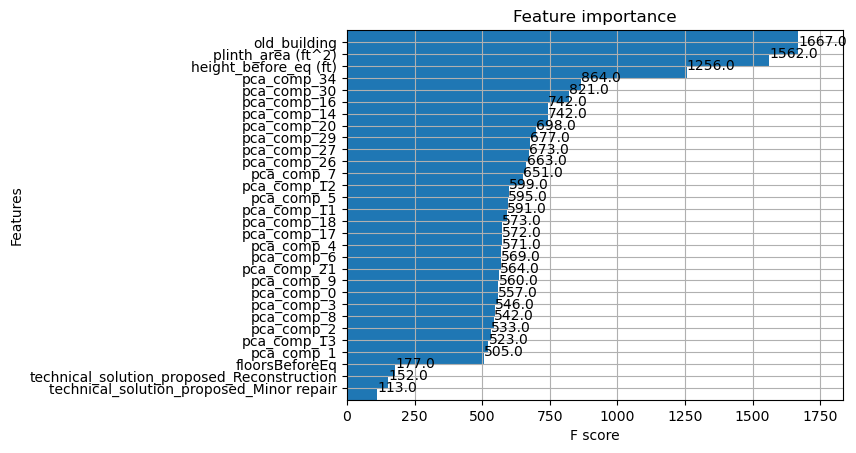

In [ ]:
xgb_cl.fit(X_train, y_train)
_ = plot_importance(xgb_cl, height = 2.0, max_num_features = 30)

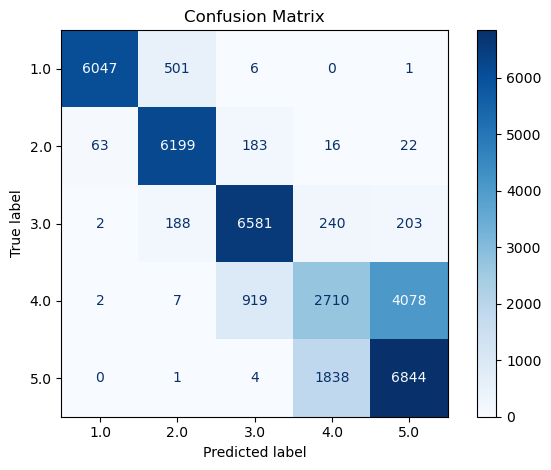

In [ ]:
plt.style.use('default')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, probs), display_labels=['1.0', '2.0', '3.0', '4.0', '5.0'])
disp.plot(cmap='Blues', values_format='')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Tuned

In [ ]:
# Setting the basic classifier
xgb_cl_untuned = XGBClassifier(tree_method='gpu_hist')

In [ ]:
def report_perf(optimizer, X, y, title, callbacks = None):
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback = callbacks)
    else:
        optimizer.fit(X, y)
    best_score = optimizer.best_score_
    best_score_std = optimizer.cv_results_['std_test_score'][optimizer.best_index_]
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [ ]:
search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'max_depth': Integer(2, 12),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'n_estimators': Integer(50, 5000)
   }

In [ ]:
opt = BayesSearchCV(estimator = xgb_cl_untuned,
                    search_spaces = search_spaces,
                    cv = 5,
                    n_jobs = 1,
                    n_iter = 10,
                    return_train_score = False,
                    refit = True,
                    iid = False,                                        # if not iid it optimizes on the cv score                                                               
                    optimizer_kwargs = {'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state = 0,
                    verbose = 100)

/opt/conda/lib/python3.7/site-packages/skopt/searchcv.py:300: UserWarning: The `iid` parameter has been deprecated and will be ignored.
  warnings.warn("The `iid` parameter has been deprecated "


In [ ]:
best_params = report_perf(opt, X_train, y_train,'XGBoost', 
                          callbacks = [DeltaYStopper(0.0001)])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768
[CV 1/5; 1/1] END colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768;, score=0.767 total time=  38.6s
[CV 2/5; 1/1] START colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768
[CV 2/5; 1/1] END colsample_bytree=0.5778677484569327, learning_rate=0.6793187137881445, max_depth=8, n_estimators=3251, reg_alpha=85.87438316565517, reg_lambda=98.05562626781331, subsample=0.21526179068277768;, score=0.764 total time=  38.1s
[CV 3/5; 1/1] START colsample_b

In [ ]:
## Checking the best params
best_params

OrderedDict([('colsample_bytree', 0.5758225678679059),
             ('learning_rate', 0.06731886525659495),
             ('max_depth', 5),
             ('n_estimators', 998),
             ('reg_alpha', 24.04631523135751),
             ('reg_lambda', 34.21270253201294),
             ('subsample', 0.6778671495585501)])

In [ ]:
xgb_cl_tuned = XGBClassifier(
    colsample_bytree = 0.18284904721469425,
    learning_rate = 0.897210891680092,
    max_depth = 10,
    n_estimators = 4671,
    reg_alpha = 44.85985541928477,
    reg_lambda = 34.21270253201294,
    subsample = 0.6778671495585501, tree_method='gpu_hist'
)

In [ ]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
cv_scores = cross_val_score(xgb_tuned, X_train, y_train, cv = kf, scoring = 'f1_macro')

print(cv_scores)

[0.7734725  0.77422476 0.77546203 0.7739808  0.77709277]


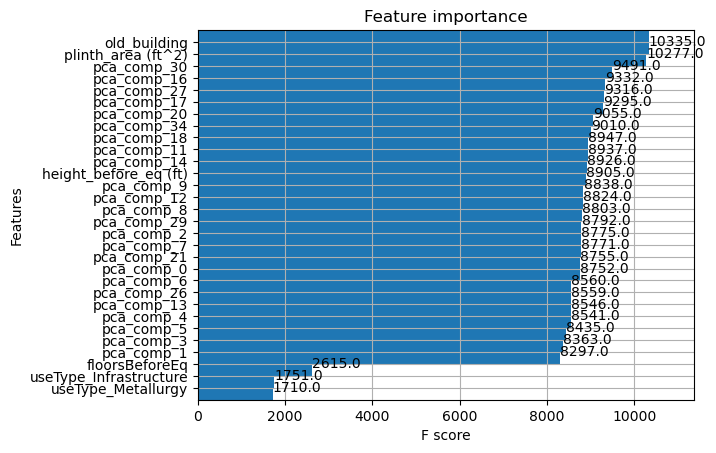

In [ ]:
xgb_tuned.fit(X_train, y_train)
_ = plot_importance(xgb_tuned, height = 2.0, max_num_features = 30)

In [ ]:
probs = xgb_tuned.predict(X_val)

print("Tuned XGB classifier F1 Score: " + str(f1_score(y_val, probs, average = 'macro')))

Tuned XGB classifier F1 Score: 0.7796895269889073


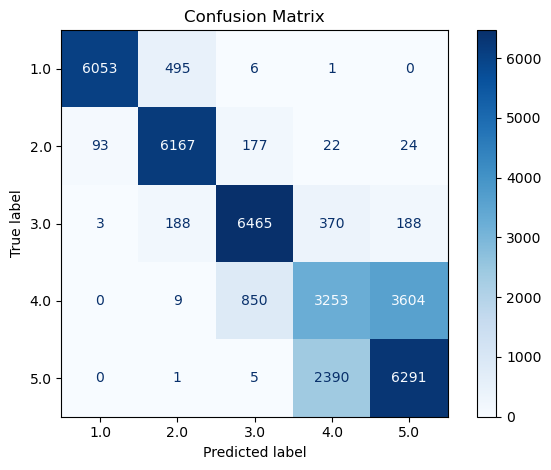

In [ ]:
plt.style.use('default')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, probs), display_labels=['1.0', '2.0', '3.0', '4.0', '5.0'])
disp.plot(cmap='Blues', values_format='')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Create Submission File

In [ ]:
sample_submission

damage_grade
id                  
0                  5
1                  1
2                  4
3                  4
4                  4
...              ...
242077             3
242078             3
242079             4
242080             1
242081             1

[242082 rows x 1 columns]

In [ ]:
sample_submission_2 = sample_submission.copy()

In [ ]:
submission = probs_tuned.predict(test_df)

In [ ]:
submission

array([3, 4, 4, ..., 0, 3, 3])

In [ ]:
sample_submission_2['damage_grade'] = submission + 1

In [ ]:
sample_submission_2.dtypes

damage_grade    int64
dtype: object

In [ ]:
sample_submission_2

damage_grade
id                  
0                  4
1                  5
2                  5
3                  4
4                  2
...              ...
242077             3
242078             5
242079             1
242080             4
242081             4

[242082 rows x 1 columns]

In [ ]:
sample_submission_2.to_csv('submission_5.csv', index = True)